# The purpose of this notebook is to take the sound_cat data and format it in the same way as ELV

In [2]:
import os
import pandas as pd
import glob
import numpy as np
# import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import statistics as stats
import data_handlers as dh
from tqdm import tqdm
from scipy.optimize import curve_fit
from scipy.stats import norm
from matplotlib.lines import Line2D
import warnings
import matplotlib.patches as mpatches


%matplotlib inline

ModuleNotFoundError: No module named 'seaborn'

In [ ]:
data_path = '/Volumes/akrami/Quentin/Head_Fixed_Behavior/Data/'
# data_path = '/Volumes/winstor/swc/akrami/Quentin/Head_Fixed_Behavior/Data/'
cache_path = '/Users/quentin/Desktop/HeadFixedBehavior/Data/'
figures_path = '/Users/quentin/Desktop/HeadFixedBehavior/Analysis/Figures/'
h_f_b = dh.head_fixed_behavior()
ad = dh.AD()

In [3]:
# pd.read_csv('/Volumes/winstor/swc/akrami/Quentin/Head_Fixed_Behavior/Data/QP066/PRO_ANTI_QP066_2023_1_17/Trial_Summary2023-01-17T17_57_21.csv')

#

## Functions

In [4]:
def psychometric (s, mu , sigma , lapse1 , lapse2):
    """
    Psychometric function to be used for fitting purposes
    :param s: stimulus (distance from the boundary)
    :param m: mean of the gaussian distribution
    :param sigma: std of the gaussian distribution (related to the slope of the curve)
    :param lapse1: lower lapse of the curve (or lambda)
    :param lapse2: upper lapse of the curve (or lambda)
    :return: probability of choosing option B (going left)
    """
    psyc = lapse1 + (1 - lapse1 - lapse2) * norm.cdf(s, mu, sigma)

    return psyc

def bootstrap(samples, choices, num_iters = 500): 
    x_store =  np.zeros((num_iters, len(x)))
    y_store =  np.zeros((num_iters, len(x)))

    for iters in range(num_iters):
        boot = np.random.choice(np.arange(len(x)),len(x))
        x_boot = samples[boot]
        y_boot = choices[boot]
        x_store[iters,:] = x_boot
        y_store[iters,:] = y_boot
    return(x_store, y_store)

def normalize_amp(val):
    if not np.isnan(val) and 60 <= val <= 92:
        return (val - 76) / 16
    return val
def normalize_oct(val):
    if not np.isnan(val) and 0 <= val <= 2:
        return (val - 1) / 1
    return val

def filter_min_trials(df, threshold):
    # Create an empty list to store the filtered dataframes
    filtered_dfs = []

    # Iterate over unique animal IDs
    for animal_id in df['Participant_ID'].unique():
        # Create a dataframe for the current animal ID
        animal_df = df[df['Participant_ID'] == animal_id]

        # Iterate over unique sessions for the current animal ID
        for session in animal_df['block'].unique():
            # Create a dataframe for the current session
            session_df = animal_df[animal_df['block'] == session]

            # Count the number of rows where 'Abort_Trial' == False
            count = session_df.query("No_response == False").shape[0]

            # If the count is greater than or equal to the threshold,
            # append the session dataframe to the filtered_dfs list
            if count >= threshold:
                filtered_dfs.append(session_df)

    # Concatenate all filtered dataframes into a single dataframe
    filtered_df = pd.concat(filtered_dfs, ignore_index=True)

    return filtered_df

def make_blocks_equal(df):
    """Takes dataframe and ensures that all participants and distributions have the same number of blocks
    Args:
        df(pd.dataframe): dataframe to be processed
    Returns: 
        dataframe with sessions exceeding lowest common session for each participant and distribution removed
    """
    block_counts = df.groupby(['Participant_ID','Distribution'])['block'].nunique()
    block_counts = block_counts.reset_index()
    min_dist_dict = []
    for distribution in block_counts.Distribution.unique():
        distrbution_block_counts = block_counts[block_counts.Distribution == distribution]
        distribution_df = df[df.Distribution == distribution]
        dist_block_min = distrbution_block_counts.block.min()
        min_dist_dict.append(distribution_df[distribution_df.dist_block <= dist_block_min])
    filtered_df = pd.concat(min_dist_dict)
    return filtered_df

def check_distributions(df, n=3):
    """Takes a dataframe and ensures n distributions are present.
    
    Args:
        df (pd.DataFrame): The dataframe to be processed.
        n (int): The number of distributions to ensure are present.
        
    Returns: 
        A filtered dataframe with participants without n distributions removed and reindexed rows.
    """
    filtered_df = df.groupby('Participant_ID').filter(lambda x: x['Distribution'].nunique() == n)
    filtered_df.reset_index(drop=True, inplace=True)
    return filtered_df

def set_fontsize(size):
    plt.rc('xtick', labelsize=size)
    plt.rc('ytick', labelsize=size)
    plt.rc('axes', labelsize=size)
    plt.rc('legend', fontsize=size)
set_fontsize(14)
    
def filter_transitions_sessions(df, distributions_to_filter, session_threshold):
    """Takes dataframe removes sessions beyond a certain threshold for specified distributions
    Args:
        df(pd.dataframe): dataframe to be processed
        distributions_to_filter(list): list of distributions to filter
        session_threshold(int): session beyond which data in retained
    Returns: 
        dataframe with sessions below session_threshold for specified distributions removed 
    """ 
    my_list = []
    for participant in df.Participant_ID.unique():
        participant_df = df[df.Participant_ID == participant]
        for distribution in participant_df.Distribution.unique():
            distribution_df = participant_df[participant_df.Distribution == distribution]
            if distribution in distributions_to_filter:
                distribution_df_filtered = distribution_df[distribution_df.dist_block > session_threshold]
                my_list.append(distribution_df_filtered)
            else:
                my_list.append(distribution_df)
    filtered_df = pd.concat(my_list)
    filtered_df = filtered_df.reset_index(drop = True)
    return filtered_df

def gen_animal_list(n,m):
    animal_list = []
    for i in range(n, m+1):
        animal_name = f'QP{i:03}'
        animal_list.append(animal_name)
    return animal_list

def add_dist_block(df):
    # add block change column to detect when block changes for each participant and distribution
    df['block_change'] = df.groupby(['Participant_ID', 'Distribution'])['block'].diff().ne(0).astype(int)
    
    # add dist_block column to keep track of block changes within each participant and distribution
    df['dist_block'] = df.groupby(['Participant_ID', 'Distribution'])['block_change'].cumsum()
    
    # drop the block_change column since it's no longer needed
    df.drop('block_change', axis=1, inplace=True)
    
    return df

def relabel_ELV(df):
    # convert tone to octave
    df['Octave'] = df.apply(lambda row: round((np.log(row.Tone/4)) / np.log(2), 7), axis=1)
    
    # rename Distribution values like Victor
    df['Distribution'] = df['Distribution'].replace({'Asym_Left': 'Asym_left', 'Asym_Right': 'Asym_right'})
    
    # label columns like ELV
    df['block'] = df['block'].apply(lambda x: x - 1) # apply 0 indexing to block
    df['TrialNumber'] = df['TrialNumber'].apply(lambda x: x - 1) # apply 0 indexing to TrialNumber
    df['Tone'] = df['Tone'].apply(lambda x: x * 1000) # go from kHz to Hz
    df['stimulus'] = np.where(np.isnan(df['Tone']), df['WN_Amp'], df['Tone'])
    df['stim_relative'] = np.where(np.isnan(df['Octave']), 
                                   df['WN_Amp'].apply(normalize_amp), df['Octave'].apply(normalize_oct))
    df['stim_relative_binned'], cut_bin = pd.qcut(df['stim_relative'],  
                                              q = 8, labels = np.arange(-0.875,0.9,0.25),retbins = True)
    df['stim_type'] = np.where(np.isnan(df['Tone']), 'WN', np.where(np.isnan(df['WN_Amp']), 'PT', 'NA'))
    df['choice'] = df['FirstLick'].apply(lambda x: x - 1) # 0 for left (A), 1 for B (right)
    
    df = df.rename(columns={'Animal_ID': 'Participant_ID', 'TrialNumber': 'Trial', 
                            'Correct': 'correct', 'AbortTrial': 'No_response'})
    df['Rule_Right'] = np.where(df['stim_relative']>0, 1, 0)

    df['Choice_Rule_Diff'] = df['choice'] - df['Rule_Right']
#     return df
    # only keep columns used by ELV
    df = df[['Participant_ID', 'Distribution', 'Trial', 'correct', 'block',
             'stimulus',  'stim_relative', 'stim_relative_binned', 'choice', 'No_response', 
             'Response_Latency', 'stim_type', 'Choice_Rule_Diff', 'Anti_Bias' 
             ]]
    
    # label relevant rows as np.nan for no_response trials
    df.loc[df['No_response'] == True, 'correct'] = np.nan
    df.loc[df['No_response'] == True, 'choice'] = np.nan
    df.loc[df['No_response'] == True, 'Response_Latency'] = np.nan
    df.loc[df['No_response'] == True, 'Choice_Rule_Diff'] = np.nan

    return df

def threshold_cutoff(df, threshold=0.7):
    # group the dataframe by 'Participant_ID' and 'block'
    valid_blocks = df.groupby(['Participant_ID', 'block'])['correct'].mean()
    
    # filter out blocks where average 'correct' is less than threshold and add new block index
    valid_blocks = valid_blocks[valid_blocks >= threshold].reset_index()
    
    # re-index blocks
    valid_blocks['new_block_index'] = valid_blocks.groupby('Participant_ID').cumcount()
    valid_blocks = valid_blocks[['Participant_ID', 'block', 'new_block_index']]
    
    # merge with original DataFrame to filter out invalid blocks
    filtered_df = df.merge(valid_blocks, on=['Participant_ID', 'block'])
    
    # remove old block column and rename new block column
    filtered_df = filtered_df.drop(columns=['block']).rename(columns={'new_block_index': 'block'})
    
    return filtered_df


def filter_lapses(df, threshold=0.80):
    """
    Takes a pandas dataframe `df` and removes each `block` 
    for each `Participant` where the performance on lapses (`df[df.stim_relative_binned == -0.875]`
    or `df[df.stim_relative_binned == 0.875]`) is less than threshold. 
    
    Parameters:
        df (pandas.DataFrame): The dataframe containing the data to filter.
        threshold (float): threshold performance on lapse rates
        
    Returns:
        pandas.DataFrame: The filtered dataframe.
    """
    # Create a new dataframe to store the filtered data
    filtered_df = pd.DataFrame()

    # Loop through each participant
    for participant in df['Participant_ID'].unique():
        # Get the data for this participant
        participant_data = df[df['Participant_ID'] == participant]
        
        # Initialize a variable to keep track of the new block index
        new_block_index = 0

        # Loop through each block
        for block in participant_data['block'].unique():
            # Get the data for this block
            block_data = participant_data[participant_data['block'] == block]

            # Check if the performance is less than threshold for the relevant stim_relative_binned values
            if ((block_data[block_data['stim_relative_binned'] == -0.875]['correct'].mean() < threshold) or 
                (block_data[block_data['stim_relative_binned'] == 0.875]['correct'].mean() < threshold)):
                # If the performance is less than threshold, don't include this block in the filtered data
                continue

            # If the performance is greater than or equal to threshold, include this block in the filtered data
            # Add a new column with the updated block index
            block_data['block'] = new_block_index
            
            # Add the updated block data to the filtered data
            filtered_df = pd.concat([filtered_df, block_data])

            # Increment the new block index
            new_block_index += 1

    # Re-index the rows in the filtered data
    filtered_df = filtered_df.reset_index(drop=True)

    # Return the filtered data
    return filtered_df

def sort_consec_dist(df, desired_order):
    """
    Takes a dataframe and removes all blocks that do not followed the imposed order:

    Args:
        df (pd.DataFrame): original dataframe
        desired_order (str): desired distribution order e.g. ['Uniform', 'Asym_right', 'Asym_left']

    Returns:
        pd.DataFrame: A new dataframe where blocks not following the imposed order are removed
    """
    
    filtered_df = df[df['Distribution'].notna()]
    ordered_distributions = []
    concatenated_dfs = []
    for participant in filtered_df.Participant_ID.unique():
        last_dist = None  # reset last_dist for each new participant
        participant_df = filtered_df[filtered_df.Participant_ID == participant]
        block_dfs = []
        for block in participant_df.block.unique():
            block_df = participant_df[participant_df.block == block]
            if (last_dist is not None) and (desired_order.index(block_df.Distribution.unique()[0]) 
                                            < desired_order.index(last_dist)):
                continue  # discard element not in the desired order
            block_dfs.append(block_df)
            last_dist = block_df.Distribution.unique()[0]
        # Discard any trailing 'Uniform's or 'Asym_right's
        while block_dfs and block_dfs[-1]['Distribution'].iloc[0] in ['Uniform', 'Asym_right']:
            block_dfs.pop()
        concatenated_dfs.append(pd.concat(block_dfs))
    filtered_df = pd.concat(concatenated_dfs)
    filtered_df.reset_index(drop=True, inplace=True)
    return filtered_df

def calculate_entropy(seq):
    ones_count = seq.count(1)
    zeros_count = seq.count(0)
    total_count = ones_count + zeros_count
    ones_prob = ones_count / total_count
    zeros_prob = zeros_count / total_count
    entropy = 0
    if ones_prob > 0:
        entropy -= ones_prob * math.log2(ones_prob)
    if zeros_prob > 0:
        entropy -= zeros_prob * math.log2(zeros_prob)
    return entropy

def calc_conf_interval(group):
    # calculate the mean and count of 'choice' for the group
    mean = group['choice'].mean()
    count = group['choice'].count()
    
    # calculate the standard error of the mean
    std_error = np.sqrt(mean*(1-mean)/count)
    
    # calculate the 95% confidence interval
    conf_interval = 1.96 * std_error
    
    # return the mean and confidence interval as a series
    return pd.Series({'mean': mean, 'count': count, 'conf_interval': conf_interval})

## Fetch Data

In [14]:
# Import the os and pickle modules
import os
import pickle

# Animal_List = gen_animal_list(1,100)
Animal_List = ['QP062', 'QP063', 'QP070', 'QP071']
            
Protocol = 'SOUND_CAT_CONT'
File_Type = 'Trial_Summary'

# Define a function for loading the data for a single animal
def load_data(animal):
    # Load the data for the current animal
    mouse_data = h_f_b.get_animal_data(
        animal, Protocol, File_Type, data_path
    )
    return mouse_data

# Define the path to the cache file
# cache_path = '/Users/quentin/Desktop/HeadFixedBehavior/Data/'
cache_file = os.path.join(cache_path, "all_data_cont.pkl")

# Check if the cache file exists
if os.path.exists(cache_file):
    # If the cache file exists, load the data from the cache
    with open(cache_file, "rb") as f:
        
        all_data_cont = pickle.load(f)
else:
    # If the cache file does not exist, load the data from the remote server
    all_data_cont = pd.DataFrame()
    for animal in Animal_List:
        try:
            # Load the data for the current animal and add it to the dictionary
            mouse_data = load_data(animal)
            all_data_cont = pd.concat([all_data_cont,mouse_data])
        except:
            # If there is an error loading the data, skip the current animal
            pass

    # Save the data to the cache file
    with open(cache_file, "wb") as f:
        pickle.dump(all_data_cont, f)

QP071 progress: 100%|███████████████████████████| 17/17 [00:27<00:00,  1.62s/it]


### Read file if data already fetched

In [15]:
all_data_cont = pd.read_pickle(cache_path +"all_data_cont.pkl")

### Re-label appropriately

In [16]:
df = relabel_ELV(all_data_cont)

### Keep at least 100 valid trials per sessions


In [46]:
df = filter_min_trials(df, 100)

### Only keeps sessions where antibias is off 

In [17]:
df = df[df.Anti_Bias == False].reset_index(drop=True)

### Only keep sessions where %correct is > threshold

In [9]:
df = threshold_cutoff(df, threshold = 0.7)

### Remove sessions with lapse rates > 20%

In [10]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    df = filter_lapses(df, threshold = 0.75)

### Track distribution and mouse specific block_nbs

In [18]:
df = add_dist_block(df)

### Check thal all subjects have been exposed to all distributions

In [12]:
df = check_distributions(df, n = 3)

### Check that all subjects have same number of blocks on each distribution (optional) 

In [13]:
# df = make_blocks_equal(df)

### Check distributions are valid

In [19]:
df = df[df['Distribution'].notna()]

### Ensure thal all blocks follow the desired order (e.g.   ['Uniform', 'Asym_right', 'Asym_left'])

In [15]:
df = sort_consec_dist(df, ['Uniform', 'Asym_right', 'Asym_left'])

### Save data for analysis in Victor's notebook (optional) 

In [112]:
distribution = 'Uniform'
unif_df = df[df['Distribution'] == distribution]

# remove first n sessions of asym_right
n = 0
distribution = 'Asym_right'
asym_right_df = df[df['Distribution'] == distribution]
asym_right_df = asym_right_df[asym_right_df.dist_block > n]

# remove first n sessions of asym_left
m = 12
distribution = 'Asym_left'
asym_left_df = df[df['Distribution'] == distribution]
asym_left_df = asym_left_df[asym_left_df.dist_block > m]


stable_after_switch = pd.concat([unif_df, asym_right_df, asym_left_df])
stable_after_switch = stable_after_switch.reset_index(drop=True)

# easiest hack to check mega-subject in Victor's code
stable_after_switch.loc[:, 'Participant_ID'] = 'Mega_Subject'

stable_after_switch.to_csv(cache_path + 'stable_after_switch.csv') # save dataframe as .csv

In [17]:
# re-plot for sanity check

In [10]:
# remove NoResponse trials
filtered_df = stable_after_switch[stable_after_switch.No_response == False]

# remove trials where Distribution in NaN
filtered_df = filtered_df[filtered_df['Distribution'].notna()]

distributions = ['Uniform', 
                 'Asym_right', 
                 'Asym_left'
                ]
filtered_df = filtered_df[filtered_df['Distribution'].isin(distributions)]

colors = {'Uniform': '#2F9A76', 'Asym_left': '#007dc7', 'Asym_right': '#c23f63'}

for distribution in filtered_df.Distribution.unique():
    
    # Filter the dataframe to only include rows with the current distribution
    filtered_df_2 = filtered_df[filtered_df['Distribution'] == distribution]
    
    # Perform the same binning and fitting steps as before
    choice_data = filtered_df_2.groupby('stim_relative_binned')['choice'].agg(['mean','count', 
                                                                               'var', 'std', 'sem'])
    x = choice_data.index
    y = choice_data['mean'].values
    plt.scatter(x, y, c = colors[distribution], s = 5)
                                                                              
    par, mcov = curve_fit(psychometric, x, y, bounds=([-1., 0.01, 0., 0.], [1., 10, .5, .5]))
    
    # Plot the fit and data points, but change the color and label based on the current distribution
    x = np.linspace(x.min(), x.max(), 100)
    y = psychometric(x, *par)
    plt.plot(x, y, label=distribution, color=colors[distribution], linewidth = 1)
    plt.xlabel('Distance from Boundary')
    plt.ylabel('Ratio chose B')
    plt.errorbar(choice_data.index, choice_data['mean'], 
                 yerr=choice_data['sem'], fmt='.', markersize=2, color=colors[distribution])
plt.ylim(0,1)
plt.xlim(-1,1)  
plt.xticks(np.linspace(-1, 1, 5))
plt.legend(prop={'size': 10})
plt.title('Mega-subject')

plt.show()

NameError: name 'stable_after_switch' is not defined

### Save data containing stimuli used for each of distribution in different files

In [2621]:
# # Uniform
# folder_path = '/Users/quentin/Desktop/HeadFixedBehavior/Data/'

# stim_relative_unif = df[df.Distribution == 'Uniform'][['Participant_ID',
#                                                       'Distribution',
#                                                       'stim_relative', 
#                                                       'stim_relative_binned']].reset_index(drop=True)
# stim_relative_unif.to_csv(folder_path + 'stim_relative_unif.csv') 
# # Asym_left
# stim_relative_asym_r = df[df.Distribution == 'Asym_right'][['Participant_ID',
#                                                             'Distribution',
#                                                             'stim_relative', 
#                                                             'stim_relative_binned']].reset_index(drop=True)
# stim_relative_asym_r.to_csv(folder_path + 'stim_relative_asym_r.csv') 
# # Asym_right
# stim_relative_asym_l = df[df.Distribution == 'Asym_left'][['Participant_ID',
#                                                            'Distribution',
#                                                            'stim_relative', 
#                                                            'stim_relative_binned']].reset_index(drop=True)
# stim_relative_asym_l.to_csv(folder_path + 'stim_relative_asym_l.csv') 

### Distribution histograms 

In [20]:
color_dist = {'Uniform': '#2F9A76', 'Asym_left': '#007dc7', 'Asym_right': '#c23f63'}

filtered_df = df[df.No_response == False]

# group data by 'Distribution'
grouped = filtered_df.groupby('Distribution')

# create a figure and set the size
fig = plt.figure(figsize=(12, 4))

# loop through the groups
for i, (name, group) in enumerate(grouped):
    ax = fig.add_subplot(1, len(grouped), i+1)
    ax.hist(group['stim_relative'], bins=8, color =color_dist[name])
    ax.set_title(name)
    ax.set_ylabel('Count', color='k')
    ax.set_xlabel('Distance From Boundary', color='k')

fig.subplots_adjust(bottom=0.2)
plt.tight_layout()
plt.show()

# Mega Subjects

## Psychometric seperated by distribution

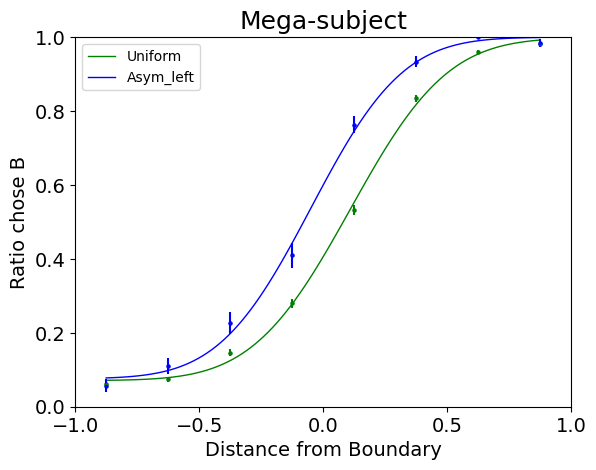

In [12]:
# remove NoResponse trials
filtered_df = df[df.No_response == False]

# remove trials where Distribution in NaN
filtered_df = filtered_df[filtered_df['Distribution'].notna()]

distributions = ['Uniform', 
                 'Asym_right', 
                 'Asym_left'
                ]
filtered_df = filtered_df[filtered_df['Distribution'].isin(distributions)]

colors = {'Uniform': 'g', 'Asym_left': 'b', 'Asym_right': 'r'}

for distribution in filtered_df.Distribution.unique():
    
    # Filter the dataframe to only include rows with the current distribution
    filtered_df_2 = filtered_df[filtered_df['Distribution'] == distribution]
    
    # Perform the same binning and fitting steps as before
    choice_data = filtered_df_2.groupby('stim_relative_binned')['choice'].agg(['mean','count', 
                                                                               'var', 'std', 'sem'])
    x = choice_data.index
    y = choice_data['mean'].values
    plt.scatter(x, y, c = colors[distribution], s = 5)
                                                                              
    par, mcov = curve_fit(psychometric, x, y, bounds=([-1., 0.01, 0., 0.], [1., 10, .5, .5]))
    
    # Plot the fit and data points, but change the color and label based on the current distribution
    x = np.linspace(x.min(), x.max(), 100)
    y = psychometric(x, *par)
    plt.plot(x, y, label=distribution, color=colors[distribution], linewidth = 1)
    plt.xlabel('Distance from Boundary')
    plt.ylabel('Ratio chose B')
    plt.errorbar(choice_data.index, choice_data['mean'], 
                 yerr=choice_data['sem'], fmt='.', markersize=2, color=colors[distribution])
plt.ylim(0,1)
plt.xlim(-1,1)  
plt.xticks(np.linspace(-1, 1, 5))
plt.legend(prop={'size': 10})
plt.title('Mega-subject')

plt.show()

## Psychometric parameters seperated by distribution

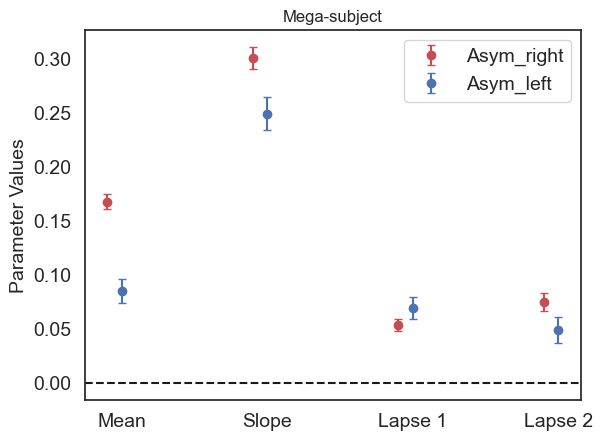

In [2835]:
# Filter the DataFrame to remove NoResponse trials and trials where Distribution is NaN
filtered_df = df[df.No_response == False]
filtered_df = filtered_df[filtered_df['Distribution'].notna()]

distributions = [#'Uniform', 
                 'Asym_right', 
                 'Asym_left'
                ]
filtered_df = filtered_df[filtered_df['Distribution'].isin(distributions)]

# Set up colors for different distributions
colors = {'Uniform': 'g', 'Asym_left': 'b', 'Asym_right': 'r'}

n = -0.1
for distribution in filtered_df.Distribution.unique():
    # Filter the dataframe to only include rows with the current distribution
    dist_df = filtered_df[filtered_df['Distribution'] == distribution]

    # Perform the same binning and fitting steps as before
    choice_data = dist_df.groupby('stim_relative_binned')['choice'].agg(['mean','count', 
                                                                         'var', 'std', 'sem'])
    x = choice_data.index
    y = choice_data['mean'].values
    par, mcov = curve_fit(psychometric, x, y, bounds=([-1., 0.01, 0., 0.], [1., 10, .5, .5]))
    perr = np.sqrt(np.diag(mcov))
    x = np.arange(1,5)
    y = par
    y_err = perr
    plt.errorbar(x+n, y, yerr=y_err, fmt='o', color=colors[distribution], capsize=3, label=distribution)
    n += 0.1

xticks = ['Mean', 'Slope', 'Lapse 1', 'Lapse 2']
plt.xticks(np.arange(1,5), xticks)
plt.legend()
plt.axhline(y=0, linestyle='--', color='k')
plt.ylabel('Parameter Values')
plt.title('Mega-subject')
plt.show()


# Mean of means

## Psychometric seperated by distribution

In [3056]:
# remove NoResponse trials
filtered_df = df[df.No_response == False]

# remove trials where Distribution in NaN
filtered_df = filtered_df[filtered_df['Distribution'].notna()]

colors = {'Uniform': 'g', 'Asym_left': 'b', 'Asym_right': 'r'}


for distribution in filtered_df.Distribution.unique():
    choice_matrix = np.array([])
    # Filter the dataframe to only include rows with the current distribution
    dist_df = filtered_df[filtered_df['Distribution'] == distribution]
    
    for participant_id in dist_df.Participant_ID.unique():
        participant_df = dist_df[dist_df.Participant_ID == participant_id]    
        # Perform binning and fitting
        choice_data = participant_df.groupby('stim_relative_binned')['choice'].agg(['mean','count'])
        x = choice_data.index
        y = choice_data['mean'].values
        choice_matrix = np.append(choice_matrix, y)
        choices = choice_matrix.reshape(-1, 8) # group by 8 because of binning
        choice_means = np.mean(choices, axis=0)
        choice_sems = np.std(choices,axis=0) / np.sqrt(choices.shape[0])
    plt.errorbar(x, choice_means, 
                 yerr=choice_sems, fmt='.', markersize=5, color=colors[distribution])
         
    par, mcov = curve_fit(psychometric, x,  choice_means, bounds=([-1., 0.01, 0., 0.], [1., 10, .5, .5]))
    x_smooth = np.linspace(x.min(), x.max(), 100)
    y_fit = psychometric(x_smooth, *par)
    plt.plot(x_smooth, y_fit, label=distribution, color=colors[distribution], linewidth=1)
plt.ylim(0,1)
plt.xlim(-1,1)  
plt.xticks(np.linspace(-1, 1, 5))
plt.xlabel('Distance from Boundary')
plt.ylabel('Ratio chose B')
plt.legend(prop={'size': 10})
plt.title('Mean of means')
plt.show()

## Psychometric parameters seperated by distribution

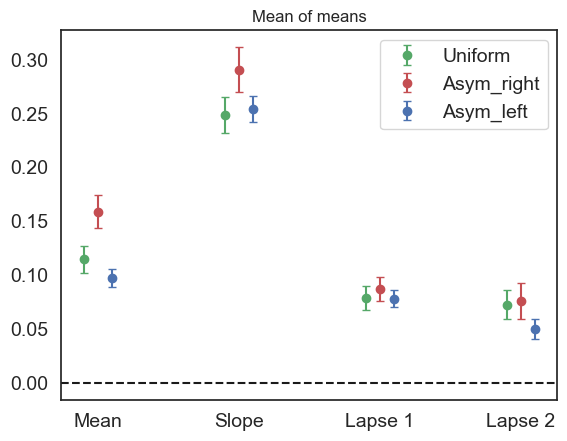

In [2639]:
# remove NoResponse trials
filtered_df = df[df.No_response == False]

# remove trials where Distribution in NaN
filtered_df = filtered_df[filtered_df['Distribution'].notna()]

colors = {'Uniform': 'g', 'Asym_left': 'b', 'Asym_right': 'r'}

n = -0.1
for distribution in filtered_df.Distribution.unique():
    choice_matrix = np.array([])
    # Filter the dataframe to only include rows with the current distribution
    dist_df = filtered_df[filtered_df['Distribution'] == distribution]
    
    for participant_id in dist_df.Participant_ID.unique():
        participant_df = dist_df[dist_df.Participant_ID == participant_id]    
        # Perform binning and fitting
        choice_data = participant_df.groupby('stim_relative_binned')['choice'].agg(['mean','count'])
        x = choice_data.index
        y = choice_data['mean'].values
        choice_matrix = np.append(choice_matrix, y)
        choices = choice_matrix.reshape(-1, 8) # group by 8 because of binning
        choice_means = np.mean(choices, axis=0)
        choice_sems = np.std(choices,axis=0) / np.sqrt(choices.shape[0])         
    par, mcov = curve_fit(psychometric, x,  choice_means, bounds=([-1., 0.01, 0., 0.], [1., 10, .5, .5]))
    x = np.arange(1,5)
    y_err = np.sqrt(np.diag(mcov))
    plt.errorbar(x+n, par, yerr=y_err, fmt='o', color=colors[distribution], capsize=3, label=distribution)
    n += 0.1
xticks = ['Mean', 'Slope', 'Lapse 1', 'Lapse 2']
plt.xticks(np.arange(1,5), xticks)
plt.legend()
plt.axhline(y=0, linestyle='--', color='k')
plt.title('Mean of means')
plt.show()

In [2754]:
# Case for the 'Uniform' condition

distribution = 'Uniform'
color = 'g'
filtered_df = df[df.No_response == False]
filtered_df = filtered_df[filtered_df['Distribution'] == distribution]
choice_data = filtered_df.groupby('stim_relative_binned')['choice'].agg(['mean','count', 
                                                                         'var', 'std', 'sem'])
x = choice_data.index
y = choice_data['mean'].values
plt.scatter(x, y, c = color, s = 5)
plt.errorbar(x, y, yerr=choice_data['sem'], 
             fmt='.', markersize=2, ecolor=color, c = color)
par, mcov = curve_fit(psychometric, x, y, bounds=([0, 0.01, 0., 0.], [2, 10, .5, .5]))
x = np.linspace(x.min(), x.max(), 100)
y = psychometric(x, *par)
plt.plot(x, y, label=distribution, color=color, linewidth = 1)

## Stable, asymptotic performance


In [2854]:
# Case for the 'Uniform' condition
distribution = 'Uniform'
color = 'g'
filtered_df = df[df.No_response == False]
filtered_df = filtered_df[filtered_df['Distribution'] == distribution]
choice_data = filtered_df.groupby('stim_relative_binned')['choice'].agg(['mean','count', 'var', 'std', 'sem'])
x = choice_data.index
y = choice_data['mean'].values
plt.scatter(x, y, c=color, s=5)
plt.errorbar(x, y, yerr=choice_data['sem'], fmt='.', markersize=2, ecolor=color, c=color)
par, mcov = curve_fit(psychometric, x, y, bounds=([0, 0.01, 0., 0.], [2, 10, .5, .5]))
x = np.linspace(x.min(), x.max(), 100)
y = psychometric(x, *par)
plt.plot(x, y, label=distribution, color=color, linewidth=1)

# Case for the 'Asym_right' condition
distribution = 'Asym_right'
color = 'r'
filtered_df = df[df.No_response == False]
filtered_df = filtered_df[filtered_df['Distribution'] == distribution]
filtered_df = filtered_df[filtered_df.dist_block > 0]
choice_data = filtered_df.groupby('stim_relative_binned')['choice'].agg(['mean','count', 'var', 'std', 'sem'])
x = choice_data.index
y = choice_data['mean'].values
plt.scatter(x, y, c=color, s=5)
plt.errorbar(x, y, yerr=choice_data['sem'], fmt='.', markersize=2, ecolor=color, c=color)
par, mcov = curve_fit(psychometric, x, y, bounds=([0, 0.01, 0., 0.], [2, 10, .5, .5]))
x = np.linspace(x.min(), x.max(), 100)
y = psychometric(x, *par)
plt.plot(x, y, label=distribution, color=color, linewidth=1)

# Case for the 'Asym_left' condition
distribution = 'Asym_left'
color = 'b'
filtered_df = df[df.No_response == False]
filtered_df = filtered_df[filtered_df['Distribution'] == distribution]
filtered_df = filtered_df[filtered_df.dist_block > 13]
choice_data = filtered_df.groupby('stim_relative_binned')['choice'].agg(['mean','count', 'var', 'std', 'sem'])
x = choice_data.index
y = choice_data['mean'].values
plt.scatter(x, y, c=color, s=5)
plt.errorbar(x, y, yerr=choice_data['sem'], fmt='.', markersize=2, ecolor=color, c=color)
par, mcov = curve_fit(psychometric, x, y, bounds=([0, 0.01, 0., 0.], [2, 10, .5, .5]))
x = np.linspace(x.min(), x.max(), 100)
y = psychometric(x, *par)
plt.plot(x, y, label=distribution, color=color, linewidth=1)

plt.xlabel('Distance from Boundary')
plt.ylabel('Ratio chose B')
plt.ylim(0,1)
plt.xlim(-1,1)  
plt.xticks(np.linspace(-1, 1, 5))
plt.legend(prop={'size': 10})
plt.show()

In [2641]:
# Look at learning

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

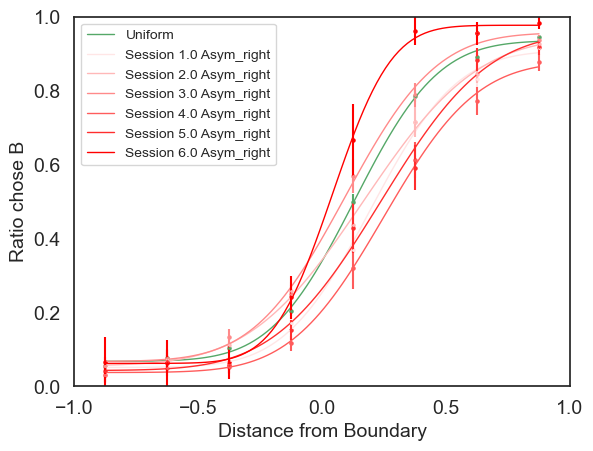

In [3016]:
# Special case for the 'Uniform' condition

filtered_df = df[df.No_response == False]
# filtered_df = make_blocks_equal(filtered_df)
filtered_df = filtered_df[filtered_df['Distribution'] == 'Uniform']

# filtered_df = filtered_df.groupby(['Participant_ID','Distribution'])

color = 'g'
choice_data = filtered_df.groupby('stim_relative_binned')['choice'].agg(['mean','count', 'var', 'std', 'sem'])
x = choice_data.index
y = choice_data['mean'].values
plt.scatter(x, y, c=color, s=5)
plt.errorbar(x, y, yerr=choice_data['sem'], fmt='.', markersize=2, ecolor=color, c=color)
par, mcov = curve_fit(psychometric, x, y, bounds=([0, 0.01, 0., 0.], [2, 10, .5, .5]))
x = np.linspace(x.min(), x.max(), 100)
y = psychometric(x, *par)
plt.plot(x, y, label=filtered_df.Distribution.unique()[0],
         color=color, linewidth=1)

# Generic case for the 'Asym_right' condition

# filtered_df = make_blocks_equal(df)
filtered_df = df[df.No_response == False]
# filtered_df = make_blocks_equal(filtered_df)
filtered_df = filtered_df[filtered_df['Distribution'] == 'Asym_right']

# Get a list of unique values of 'dist_block' for the 'Asym_right' condition
dist_blocks = filtered_df['dist_block'].unique()

# # Define a color map for the 'Asym_right' condition
# color_map = plt.get_cmap('Blues')
# colors = color_map(np.linspace(0, 1, dist_blocks.size))

light = (1.0, 0.9, 0.9)
dark = (1.0, 0.0, 0.0) 
color_map = mcolors.LinearSegmentedColormap.from_list('my_reds', [light, dark])
colors = color_map(np.linspace(0, 1, dist_blocks.size))

# Iterate over each unique value of 'dist_block'
for i, dist_block in enumerate(dist_blocks):
    # Filter the dataframe to only include rows with the current distribution and dist_block
    filtered_df2 = filtered_df[filtered_df['dist_block'] == dist_block]
    color = colors[i]
    choice_data = filtered_df2.groupby('stim_relative_binned')['choice'].agg(['mean','count', 'var', 'std', 'sem'])
    x = choice_data.index
    y = choice_data['mean'].values
    plt.scatter(x, y, c=color, s=5)
    plt.errorbar(x, y, yerr=choice_data['sem'], fmt='.', markersize=2, ecolor=color, c=color)
    par, mcov = curve_fit(psychometric, x, y, bounds=([0, 0.01, 0., 0.], [2, 10, .5, .5]))
    x = np.linspace(x.min(), x.max(), 100)
    y = psychometric(x, *par)
    plt.plot(x, y, label= 'Session ' + str(dist_block) + ' Asym_right', color=color, linewidth = 1)

plt.ylim(0,1)
plt.xlim(-1,1) 
plt.xticks(np.linspace(-1, 1, 5))
plt.xlabel('Distance from Boundary')
plt.ylabel('Ratio chose B')
# Add a legend
plt.legend(prop={'size': 10})

# plt.savefig(figures_path + 'Unif_to_asym_right_switch.pdf', 
#             dpi=300, bbox_inches='tight')
plt.show()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

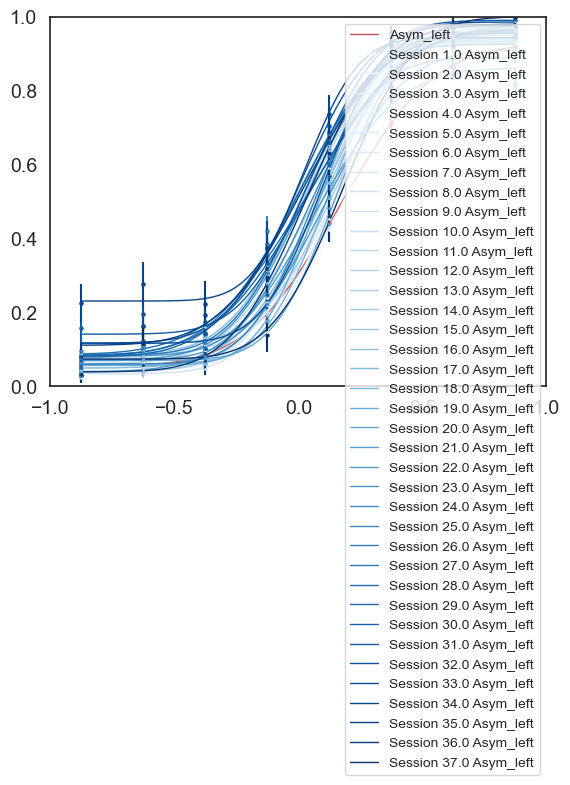

In [2771]:
# Special case 

filtered_df = df[df.No_response == False]

# Filter the dataframe to only include deesired rows
filtered_df = filtered_df[filtered_df['Distribution'] == 'Asym_right']

color = 'r'
choice_data = filtered_df.groupby('stim_relative_binned')['choice'].agg(['mean','count', 'var', 'std', 'sem'])
x = choice_data.index
y = choice_data['mean'].values
plt.scatter(x, y, c=color, s=5)
plt.errorbar(x, y, yerr=choice_data['sem'], fmt='.', markersize=2, ecolor=color, c=color)
par, mcov = curve_fit(psychometric, x, y, bounds=([0, 0.01, 0., 0.], [2, 10, .5, .5]))
x = np.linspace(x.min(), x.max(), 100)
y = psychometric(x, *par)
plt.plot(x, y, label=distribution, color=color, linewidth=1)

# Generic case for the 'Asym_left' condition

filtered_df = make_blocks_equal(df)
filtered_df = filtered_df[filtered_df.No_response == False]

filtered_df = df[df['Distribution'] == 'Asym_left']

# Get a list of unique values of 'dist_block' for the 'Asym_right' condition
dist_blocks = filtered_df['dist_block'].unique()

# Define a color map for the 'Asym_right' condition
color_map = plt.get_cmap('Blues')
colors = color_map(np.linspace(0, 1, dist_blocks.size))

# Iterate over each unique value of 'dist_block'
for i, dist_block in enumerate(dist_blocks):
    # Filter the dataframe to only include rows with the current distribution and dist_block
    filtered_df2 = filtered_df[filtered_df['dist_block'] == dist_block]
    color = colors[i]
    choice_data = filtered_df2.groupby('stim_relative_binned')['choice'].agg(['mean','count', 'var', 'std', 'sem'])
    x = choice_data.index
    y = choice_data['mean'].values
    plt.scatter(x, y, c=color, s=5)
    plt.errorbar(x, y, yerr=choice_data['sem'], fmt='.', markersize=2, ecolor=color, c=color)
    par, mcov = curve_fit(psychometric, x, y, bounds=([0, 0.01, 0., 0.], [2, 10, .5, .5]))
    x = np.linspace(x.min(), x.max(), 100)
    y = psychometric(x, *par)
    plt.plot(x, y, label= 'Session ' + str(dist_block) + ' Asym_left', color=color, linewidth = 1)

plt.ylim(0,1)
plt.xlim(-1,1) 
plt.xticks(np.linspace(-1, 1, 5))

# Add a legend
plt.legend(prop={'size': 10})
# plt.savefig(figures_path + 'Asym_right_to_asym_left_switch.pdf', 
#             dpi=300, bbox_inches='tight')
plt.show()


In [2807]:
# Special case 
filtered_df = df[df.No_response == False]

# Filter the dataframe to only include desired rows
filtered_df = filtered_df[filtered_df['Distribution'] == 'Asym_right']


color = 'r'
choice_data = filtered_df.groupby('stim_relative_binned')['choice'].agg(['mean','count', 
                                                                         'var', 'std', 'sem'])
x = choice_data.index
y = choice_data['mean'].values
plt.scatter(x, y, c=color, s=5)
plt.errorbar(x, y, yerr=choice_data['sem'], fmt='.', markersize=2, ecolor=color, c=color)
par, mcov = curve_fit(psychometric, x, y, bounds=([0, 0.01, 0., 0.], [2, 10, .5, .5]))
x = np.linspace(x.min(), x.max(), 100)
y = psychometric(x, *par)
plt.plot(x, y, label=distribution, color=color, linewidth=1)

# Generic case for the 'Asym_left' condition

filtered_df = df[df.No_response == False]

filtered_df = df[df['Distribution'] == 'Asym_left']

# Get a list of unique values of 'dist_block' for the 'Asym_right' condition
dist_blocks = filtered_df['dist_block'].unique()

# # Define a color map for the 'Asym_right' condition
# color_map = plt.get_cmap('Blues')
# colors = color_map(np.linspace(0, 1, dist_blocks.size))

light = (0.9, 0.9, 1.0) # a light shade of red, with RGB values of (1.0, 0.8, 0.8)
dark = (0.0, 0.0, 1.0) 
color_map = mcolors.LinearSegmentedColormap.from_list('my_reds', [light, dark])
colors = color_map(np.linspace(0, 1, dist_blocks.size))
    

# Iterate over each unique value of 'dist_block'
for i, dist_block in enumerate(dist_blocks):
    # Filter the dataframe to only include rows with the current distribution and dist_block
    if i % 5 == 0:  # Only plot every fifth dist_block
        filtered_df2 = filtered_df[filtered_df['dist_block'] == dist_block]
        color = colors[i]
        choice_data = filtered_df2.groupby('stim_relative_binned')['choice'].agg(['mean','count', 
                                                                                  'var', 'std', 'sem'])
        x = choice_data.index
        y = choice_data['mean'].values
        plt.scatter(x, y, c=color, s=5)
        plt.errorbar(x, y, yerr=choice_data['sem'], fmt='.', markersize=2, ecolor=color, c=color)
        par, mcov = curve_fit(psychometric, x, y, bounds=([0, 0.01, 0., 0.], [2, 10, .5, .5]))
        x = np.linspace(x.min(), x.max(), 100)
        y = psychometric(x, *par)
        plt.plot(x, y, label= 'Session ' + str(dist_block) + ' Asym_left', color=color, linewidth = 1)

plt.ylim(0,1)
plt.xlim(-1,1) 
plt.xticks(np.linspace(-1, 1, 5))

# Add a legend
plt.legend(prop={'size': 10})

plt.show()


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

## Performance & bias over sessions 

In [14]:
filtered_df = df[df.No_response == False]

fig = plt.figure(figsize=(10, 8))
num_participants = filtered_df.Participant_ID.nunique()
rows = int(np.sqrt(num_participants))
cols = int(np.ceil(num_participants / rows))

distributions = ['Uniform']
filtered_df = filtered_df[filtered_df['Distribution'].isin(distributions)]

# df = filter_min_trials(df,100)
for i, participant_id in enumerate(filtered_df.Participant_ID.unique()):
    participant_df = filtered_df[filtered_df.Participant_ID == participant_id]
    ax1 = plt.subplot(rows, cols, i+1)
    ax2 = ax1.twinx() # create a twin y-axis on the right
    
    sns.pointplot(data=participant_df, x='dist_block', y='correct', ci=95, ax=ax1, color = 'k')
    sns.pointplot(data=participant_df, x='dist_block', y='Choice_Rule_Diff', ax=ax2, color='r')
    
    ax1.set_title(f"Participant ID: {participant_id}")
    ax1.set_ylim(0, 1)
    ax2.axhline(y=0, linestyle='--', color='k')
#     ax2.axhline(y=-0.15, linestyle='--', color='gray')
#     ax2.axhline(y=0.15, linestyle='--', color='gray')

    ax2.set_ylim(-1, 1)
    ax2.set_yticks(np.arange(-1,1.1,0.4))
    ax2.tick_params(axis='y', labelcolor='r') # make yticks color red


    # Set xticks to show only one label every 5 ticks
    xticks = np.arange(participant_df['block'].min(), participant_df['dist_block'].max() + 1, 1)
    ax1.set_xticks(xticks)
    ax1.set_xticklabels([str(int(x)) if int(x)==x else '' for x in xticks], rotation = 45)
    
    ax1.set_ylabel('Proportion Correct', color='k')
    ax1.set_xlabel('Block', color='k')

    ax2.set_ylabel('Bias', color='r')
    
plt.tight_layout()
plt.show()


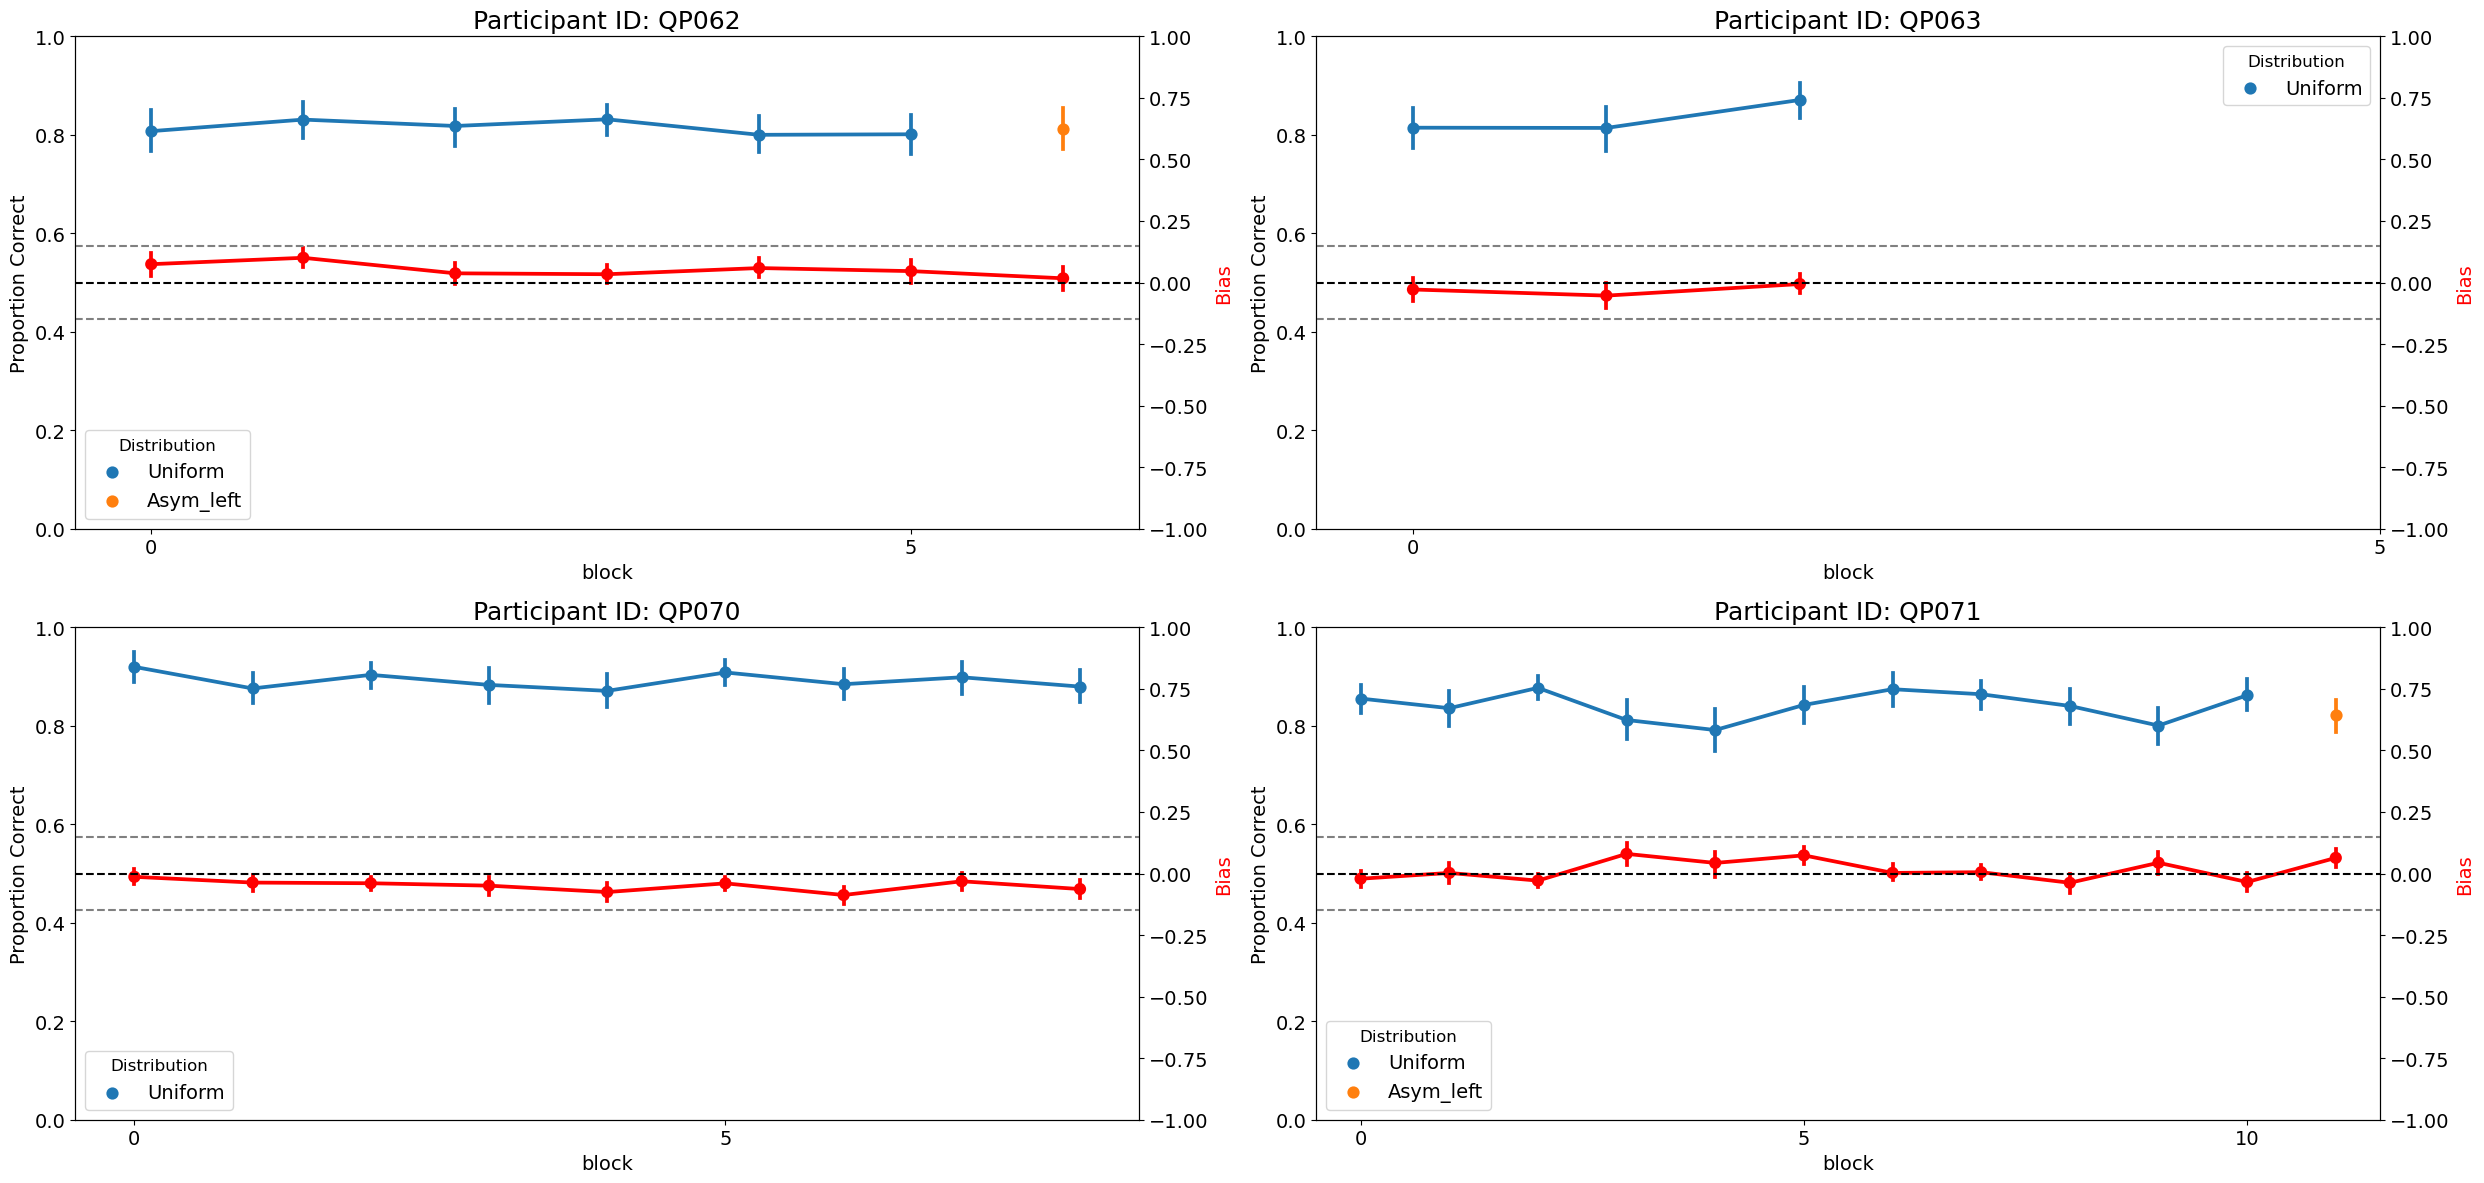

In [123]:
filtered_df = df[df.No_response == False]

fig = plt.figure(figsize=(25, 12))
num_participants = filtered_df.Participant_ID.nunique()
rows = int(np.sqrt(num_participants))
cols = int(np.ceil(num_participants / rows))

# distributions = ['Uniform']
# filtered_df = filtered_df[filtered_df['Distribution'].isin(distributions)]

# df = filter_min_trials(df,100)
for i, participant_id in enumerate(filtered_df.Participant_ID.unique()):
    participant_df = filtered_df[filtered_df.Participant_ID == participant_id]
    ax1 = plt.subplot(rows, cols, i+1)
    ax2 = ax1.twinx() # create a twin y-axis on the right
    
    sns.pointplot(data=participant_df, x='block', y='correct', hue = 'Distribution', ci=95, ax=ax1)
    sns.pointplot(data=participant_df, x='block', y='Choice_Rule_Diff', ax=ax2, color='r')
    
    ax1.set_title(f"Participant ID: {participant_id}")
    ax1.set_ylim(0, 1)
    ax2.axhline(y=0, linestyle='--', color='k')
    ax2.axhline(y=-0.15, linestyle='--', color='gray')
    ax2.axhline(y=0.15, linestyle='--', color='gray')

    ax2.set_ylim(-1, 1)
    
    # Set xticks to show only one label every 5 ticks
    xticks = np.arange(participant_df['block'].min(), participant_df['block'].max() + 1, 5)
    ax1.set_xticks(xticks)
    ax1.set_xticklabels([str(int(x)) if int(x)==x else '' for x in xticks])
    
    ax1.set_ylabel('Proportion Correct', color='k')
    ax2.set_ylabel('Bias', color='r')
    
plt.tight_layout()
plt.show()

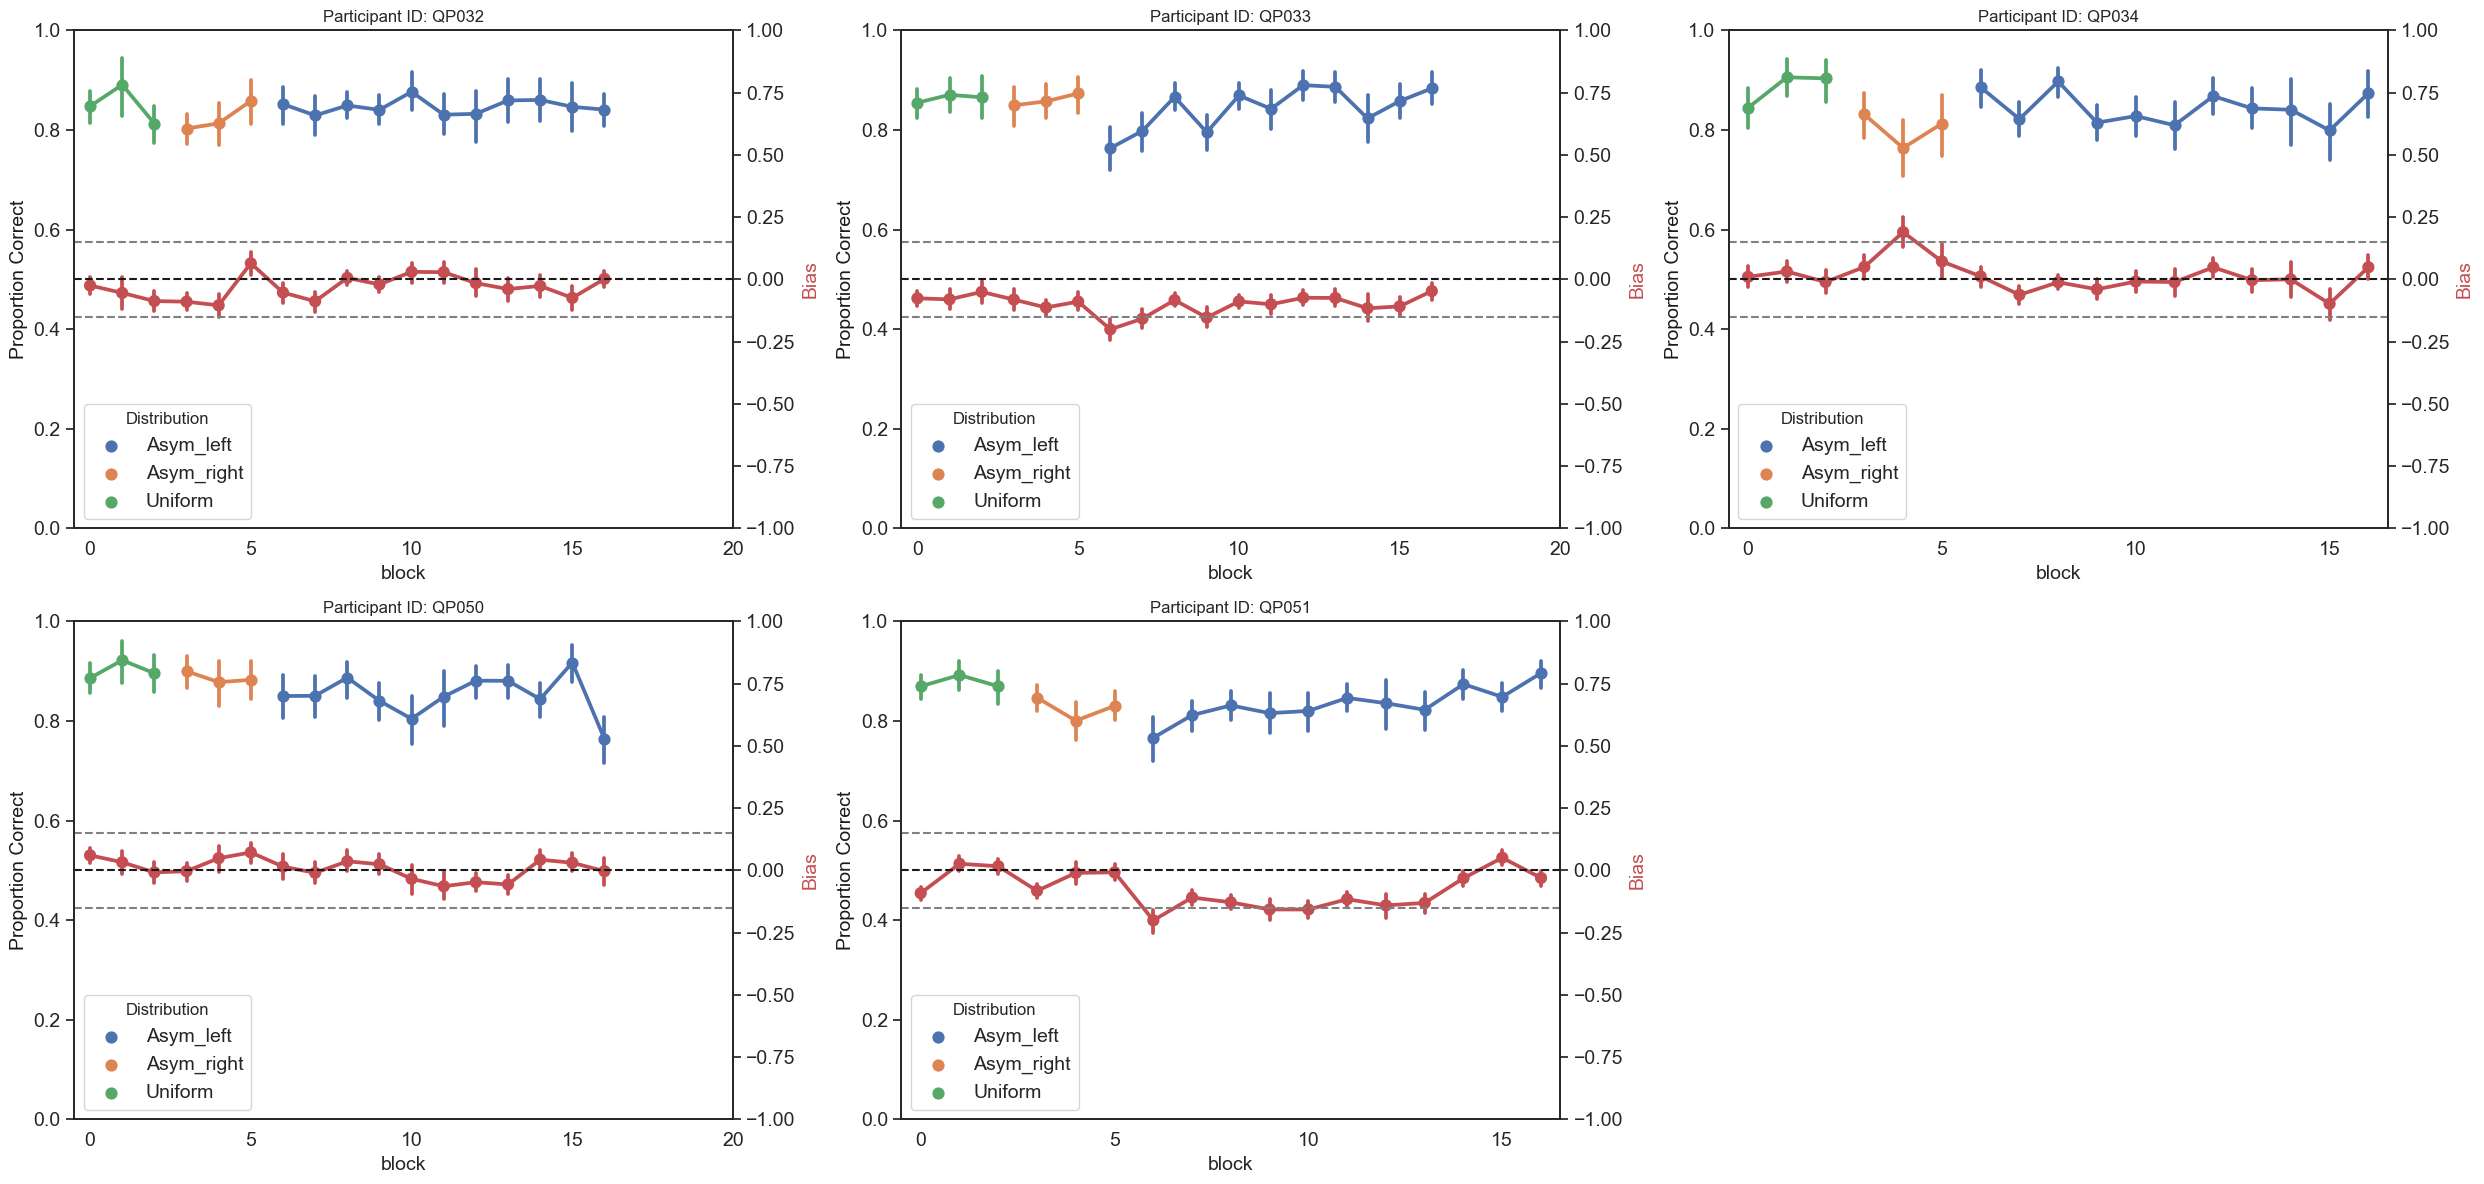

In [2675]:
filtered_df = df[df.No_response == False]
filtered_df = make_blocks_equal(filtered_df)
fig = plt.figure(figsize=(25, 12))
num_participants = filtered_df.Participant_ID.nunique()
rows = int(np.sqrt(num_participants))
cols = int(np.ceil(num_participants / rows))

# distributions = ['Uniform']
# filtered_df = filtered_df[filtered_df['Distribution'].isin(distributions)]

# df = filter_min_trials(df,100)
for i, participant_id in enumerate(filtered_df.Participant_ID.unique()):
    participant_df = filtered_df[filtered_df.Participant_ID == participant_id]
    ax1 = plt.subplot(rows, cols, i+1)
    ax2 = ax1.twinx() # create a twin y-axis on the right
    
    sns.pointplot(data=participant_df, x='block', y='correct', hue = 'Distribution', ci=95, ax=ax1)
    sns.pointplot(data=participant_df, x='block', y='Choice_Rule_Diff', ax=ax2, color='r')
    
    ax1.set_title(f"Participant ID: {participant_id}")
    ax1.set_ylim(0, 1)
    ax2.axhline(y=0, linestyle='--', color='k')
    ax2.axhline(y=-0.15, linestyle='--', color='gray')
    ax2.axhline(y=0.15, linestyle='--', color='gray')

    ax2.set_ylim(-1, 1)
    
    # Set xticks to show only one label every 5 ticks
    xticks = np.arange(participant_df['block'].min(), participant_df['block'].max() + 1, 5)
    ax1.set_xticks(xticks)
    ax1.set_xticklabels([str(int(x)) if int(x)==x else '' for x in xticks])
    
    ax1.set_ylabel('Proportion Correct', color='k')
    ax2.set_ylabel('Bias', color='r')
    
plt.tight_layout()
plt.show()

### Psychometric paramaters over time for each subject

### Mean psychometric paramaters over time

Text(0.5, 0, 'Session')

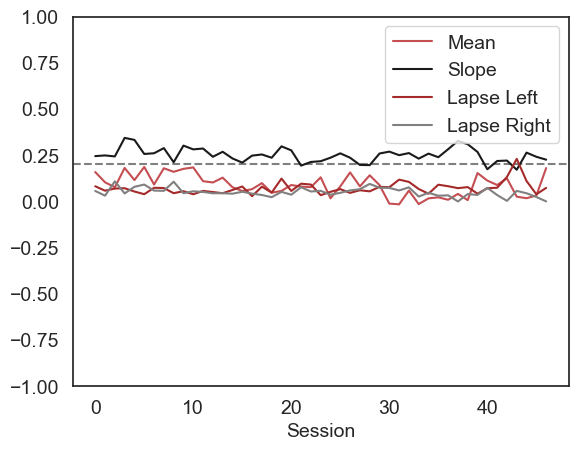

In [2647]:
filtered_df = df[df.No_response == False]
blocks_means = []
block_slopes = []
block_lapses_1 = []
block_lapses_2 = []

for block in filtered_df.block.unique():
    block_df = filtered_df[filtered_df.block == block]
    choice_data = block_df.groupby('stim_relative_binned')['choice'].mean()
    x = choice_data.index
    y = choice_data.values
    par, mcov = curve_fit(psychometric, x, y, bounds=([-1., 0.01, 0., 0.], [1., 10, .5, .5]))
    blocks_means.append(par[0])
    block_slopes.append(par[1])
    block_lapses_1.append(par[2])
    block_lapses_2.append(par[3])
plt.ylim(-1,1)
plt.axhline(y=0.2, linestyle='--', color='gray')
plt.plot(blocks_means, c='r', label='Mean')
plt.plot(block_slopes, c='k', label='Slope')
plt.plot(block_lapses_1, c='brown', label='Lapse Left')
plt.plot(block_lapses_2, c='gray', label='Lapse Right')
plt.legend(loc='upper right')
plt.xlabel('Session')

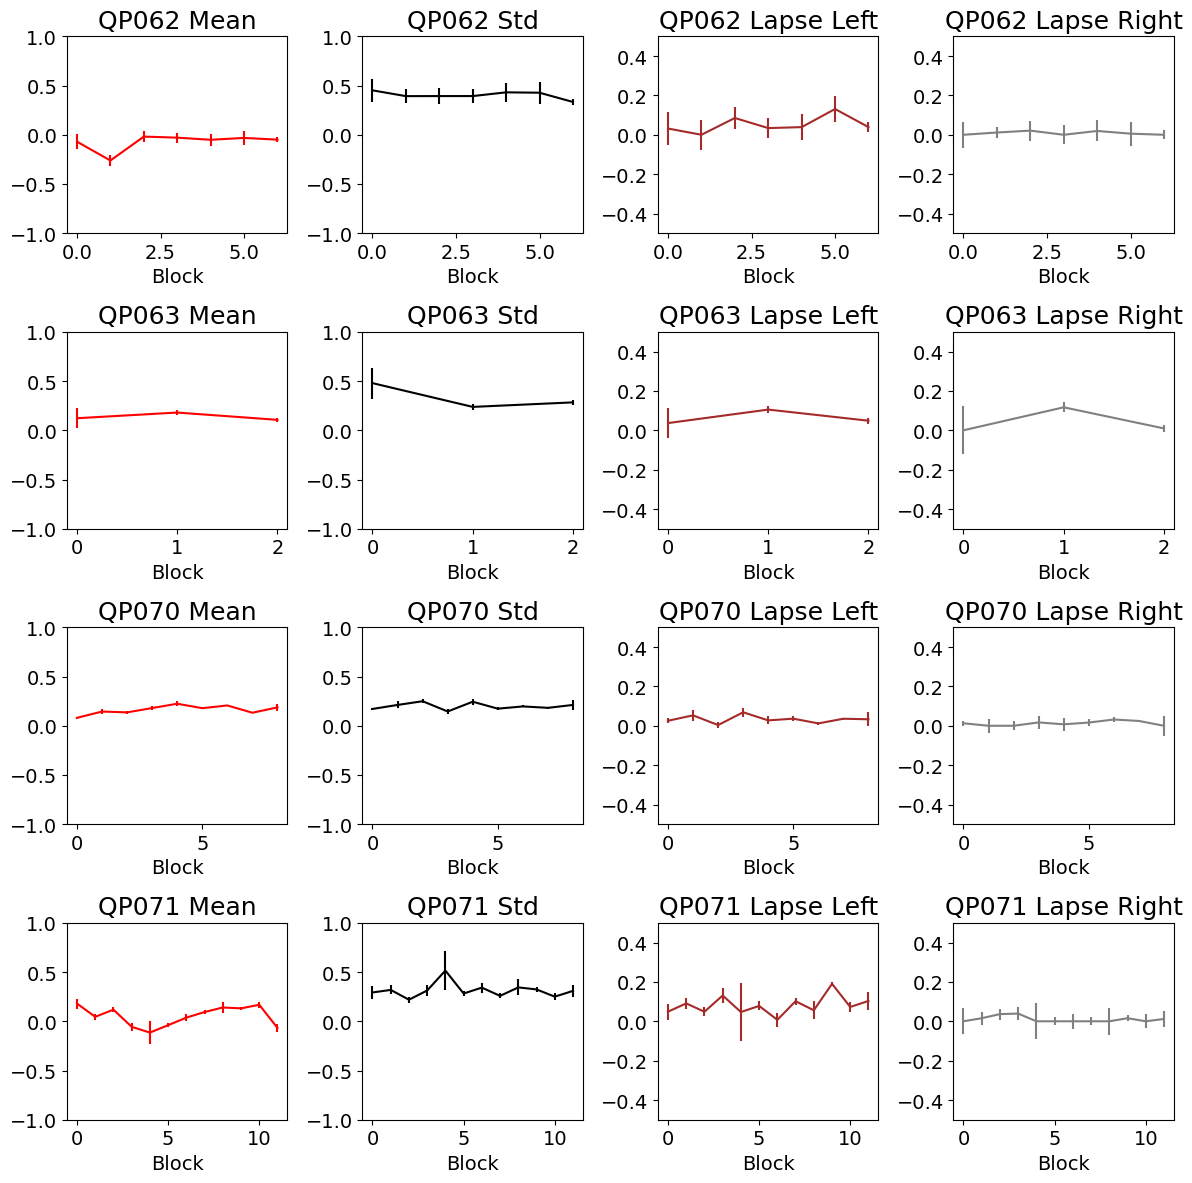

In [21]:
filtered_df = df[df.No_response == False]

participants = filtered_df.Participant_ID.unique()
n_rows = len(participants)
n_cols = 4
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12,12))
axes = axes.flatten()

for i, participant in enumerate(participants):
    filtered_df = df[(df.Participant_ID == participant) & (df.No_response == False)]
    blocks_means = []
    block_slopes = []
    block_lapses_1 = []
    block_lapses_2 = []
    mean_errors = []
    slope_errors = []
    lapse1_errors = []
    lapse2_errors = []

    for j, block in enumerate(filtered_df.block.unique()):
        block_df = filtered_df[filtered_df.block == block]
        choice_data = block_df.groupby('stim_relative_binned')['choice'].mean()
        x = choice_data.index
        y = choice_data.values
        par, mcov = curve_fit(psychometric, x, y, bounds=([-1., 0.01, 0., 0.], [1., 10, .5, .5]))
        blocks_means.append(par[0])
        block_slopes.append(par[1])
        block_lapses_1.append(par[2])
        block_lapses_2.append(par[3])
        mean_errors.append(np.sqrt(np.diag(mcov))[0])
        slope_errors.append(np.sqrt(np.diag(mcov))[1])
        lapse1_errors.append(np.sqrt(np.diag(mcov))[2])
        lapse2_errors.append(np.sqrt(np.diag(mcov))[3])

    axes[4*i].errorbar(range(len(blocks_means)), blocks_means, yerr=mean_errors, c='r', fmt='-')
    axes[4*i].set_title(participant + ' Mean')
    axes[4*i].set_ylim(-1,1)
    axes[4*i].set_xlabel('Block')

    axes[4*i+1].errorbar(range(len(block_slopes)), block_slopes, yerr=slope_errors, c='k', fmt='-')
    axes[4*i+1].set_title(participant + ' Std')
    axes[4*i+1].set_ylim(-1,1)
    axes[4*i+1].set_xlabel('Block')

    axes[4*i+2].errorbar(range(len(block_lapses_1)), block_lapses_1, yerr=lapse1_errors, c='brown', fmt='-')
    axes[4*i+2].set_title(participant + ' Lapse Left')
    axes[4*i+2].set_ylim(-0.5,0.5)
    axes[4*i+2].set_xlabel('Block')

    axes[4*i+3].errorbar(range(len(block_lapses_2)), block_lapses_2, yerr=lapse2_errors, c='gray', fmt='-')
    axes[4*i+3].set_title(participant + ' Lapse Right')
    axes[4*i+3].set_ylim(-0.5,0.5)
    axes[4*i+3].set_xlabel('Block')

plt.tight_layout()
plt.savefig(figures_path + 'Psych_params_all_subs.pdf', 
            dpi=300, bbox_inches='tight')
plt.show()


In [4]:
filtered_df = df[df.No_response == False]
filtered_df = sort_consec_dist(filtered_df, ['Uniform', 'Asym_right', 'Asym_left'])

participants = filtered_df.Participant_ID.unique()
n_rows = len(participants)
n_cols = 4
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))
axes = axes.flatten()

color_map = {'Uniform': 'green', 'Asym_right': 'red', 'Asym_left': 'blue'}

for i, participant in enumerate(participants):
    participant_df = filtered_df[filtered_df.Participant_ID == participant]
    blocks_means = []
    block_slopes = []
    block_lapses_1 = []
    block_lapses_2 = []
    block_colors = []
    mean_errors = []
    for j, block in enumerate(participant_df.block.unique()):
        block_df = participant_df[participant_df.block == block]
        choice_data = block_df.groupby('stim_relative_binned')['choice'].mean()
        x = choice_data.index
        y = choice_data.values
        par, mcov = curve_fit(psychometric, x, y, bounds=([-1., 0.01, 0., 0.], [1., 10, .5, .5]))
        blocks_means.append(par[0])
        block_slopes.append(par[1])
        block_lapses_1.append(par[2])
        block_lapses_2.append(par[3])
        mean_errors.append(np.sqrt(np.diag(mcov))[0])
        block_colors.append(color_map[block_df.Distribution.values[0]])

    axes[4*i].scatter(range(len(blocks_means)), blocks_means, c=block_colors, alpha=0.5)
    axes[4*i].set_title(participant + ' Mean')
    axes[4*i].set_ylim(-1,1)

    axes[4*i+1].scatter(range(len(block_slopes)), block_slopes, c=block_colors, alpha=0.5)
    axes[4*i+1].set_title(participant + ' Slope')
    axes[4*i+1].set_ylim(-1,1)

    axes[4*i+2].scatter(range(len(block_lapses_1)), block_lapses_1, c=block_colors, alpha=0.5)
    axes[4*i+2].set_title(participant + ' Lapse Left')
    axes[4*i+2].set_ylim(-0.5,0.5)

    axes[4*i+3].scatter(range(len(block_lapses_2)), block_lapses_2, c=block_colors, alpha=0.5)
    axes[4*i+3].set_title(participant + ' Lapse Right')
    axes[4*i+3].set_ylim(-0.5,0.5)

plt.tight_layout()
plt.show()

NameError: name 'df' is not defined

### Psychometric parameters, averaged over mice 

#### Uniform to Asym_right transition

In [2838]:
filtered_df = df[df.No_response == False]

# group by 'Participant_ID' and 'Distribution'
grouped_df = filtered_df.groupby(['Participant_ID', 'Distribution'])

# define a function to filter the last 3 blocks of dist_1 and the first 3 blocks of dist for each group
def filter_switch_blocks(group, dist_1, dist_2, last_dist_1_blocks, first_dist_2_blocks):
    if group['Distribution'].iloc[0] == dist_1:
        filtered_group = group[group['dist_block'] >= group['dist_block'].max() - (last_dist_1_blocks-1)].copy()
        filtered_group['block_relative'] = filtered_group['dist_block'] - filtered_group['dist_block'].max()
        filtered_group['block_relative'] -= filtered_group['block_relative'].max()
        filtered_group['block_relative'] += (last_dist_1_blocks-1)
        filtered_group.loc[filtered_group['Distribution'] == dist_1, 'block_relative'] -= last_dist_1_blocks
        return filtered_group
    elif group['Distribution'].iloc[0] == dist_2:
        filtered_group = group[group['dist_block'] <= group['dist_block'].min() + (first_dist_2_blocks-1)].copy()
        filtered_group['block_relative'] = filtered_group['dist_block'] - filtered_group['dist_block'].min()
        return filtered_group
    else:
        return pd.DataFrame()
    
# apply the function to each group and concatenate the results
filtered_df = pd.concat([filter_switch_blocks(group, 'Uniform', 'Asym_right', 3, 3) for name, group in grouped_df])

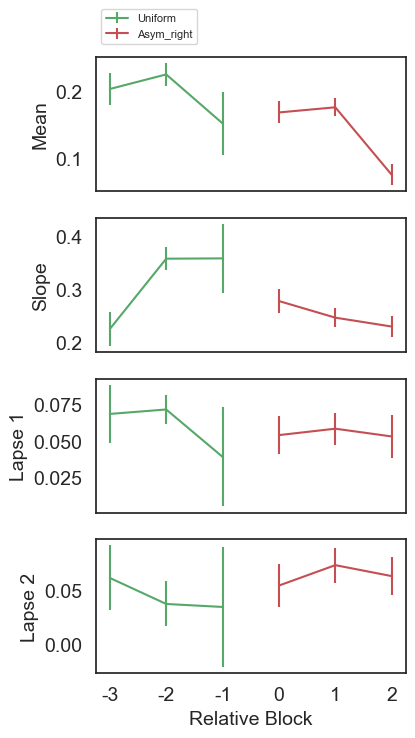

In [2851]:
block_means = []
block_slopes = []
block_lapses_1 = []
block_lapses_2 = []
mean_errors = []
slope_errors = []
lapse1_errors = []
lapse2_errors = []

for block in np.sort(filtered_df.block_relative.unique()):
    block_df = filtered_df[filtered_df.block_relative == block]
    choice_data = block_df.groupby('stim_relative_binned')['choice'].mean()
    x = choice_data.index
    y = choice_data.values
    par, mcov = curve_fit(psychometric, x, y, bounds=([-1., 0.01, 0., 0.], [1., 10, .5, .5]))
    block_means.append(par[0])
    block_slopes.append(par[1])
    block_lapses_1.append(par[2])
    block_lapses_2.append(par[3])
    mean_errors.append(np.sqrt(np.diag(mcov))[0])
    slope_errors.append(np.sqrt(np.diag(mcov))[1])
    lapse1_errors.append(np.sqrt(np.diag(mcov))[2])
    lapse2_errors.append(np.sqrt(np.diag(mcov))[3])

fig, axs = plt.subplots(4, 1, figsize=(4, 8))
axs[0].errorbar(np.arange(len(block_means)/2), block_means[:3], 
                yerr=mean_errors[:3], fmt='-', c = 'g', label = 'Uniform')
axs[0].errorbar(np.arange(len(block_means)/2,len(block_means)), block_means[3:], 
                yerr=mean_errors[3:], fmt='-', c = 'r', label = 'Asym_right')
axs[0].set_ylabel('Mean')
axs[0].legend(loc='upper left', bbox_to_anchor=(0, 1.4), prop={'size': 8})

axs[1].errorbar(np.arange(len(block_slopes)/2), block_slopes[:3], 
                yerr=slope_errors[:3], fmt='-', c = 'g')
axs[1].errorbar(np.arange(len(block_slopes)/2,len(block_slopes)), block_slopes[3:], 
                yerr=slope_errors[3:], fmt='-', c = 'r')
axs[1].set_ylabel('Slope')

axs[2].errorbar(np.arange(len(block_lapses_1)/2), block_lapses_1[:3], 
                yerr=lapse1_errors[:3], fmt='-', c = 'g')
axs[2].errorbar(np.arange(len(block_lapses_1)/2,len(block_lapses_1)), block_lapses_1[3:], 
                yerr=lapse1_errors[3:], fmt='-', c = 'r')
axs[2].set_ylabel('Lapse 1')

axs[3].errorbar(np.arange(len(block_lapses_2)/2), block_lapses_2[:3], 
                yerr=lapse2_errors[:3], fmt='-', c = 'g')
axs[3].errorbar(np.arange(len(block_lapses_2)/2,len(block_lapses_2)), block_lapses_2[3:], 
                yerr=lapse2_errors[3:], fmt='-', c = 'r')
axs[3].set_ylabel('Lapse 2')

for ax in axs.flat:
    ax.set_xticks(np.arange(0, 6, 1),np.arange(-3,3,1))
    ax.set_xlabel('Relative Block')
    ax.label_outer()


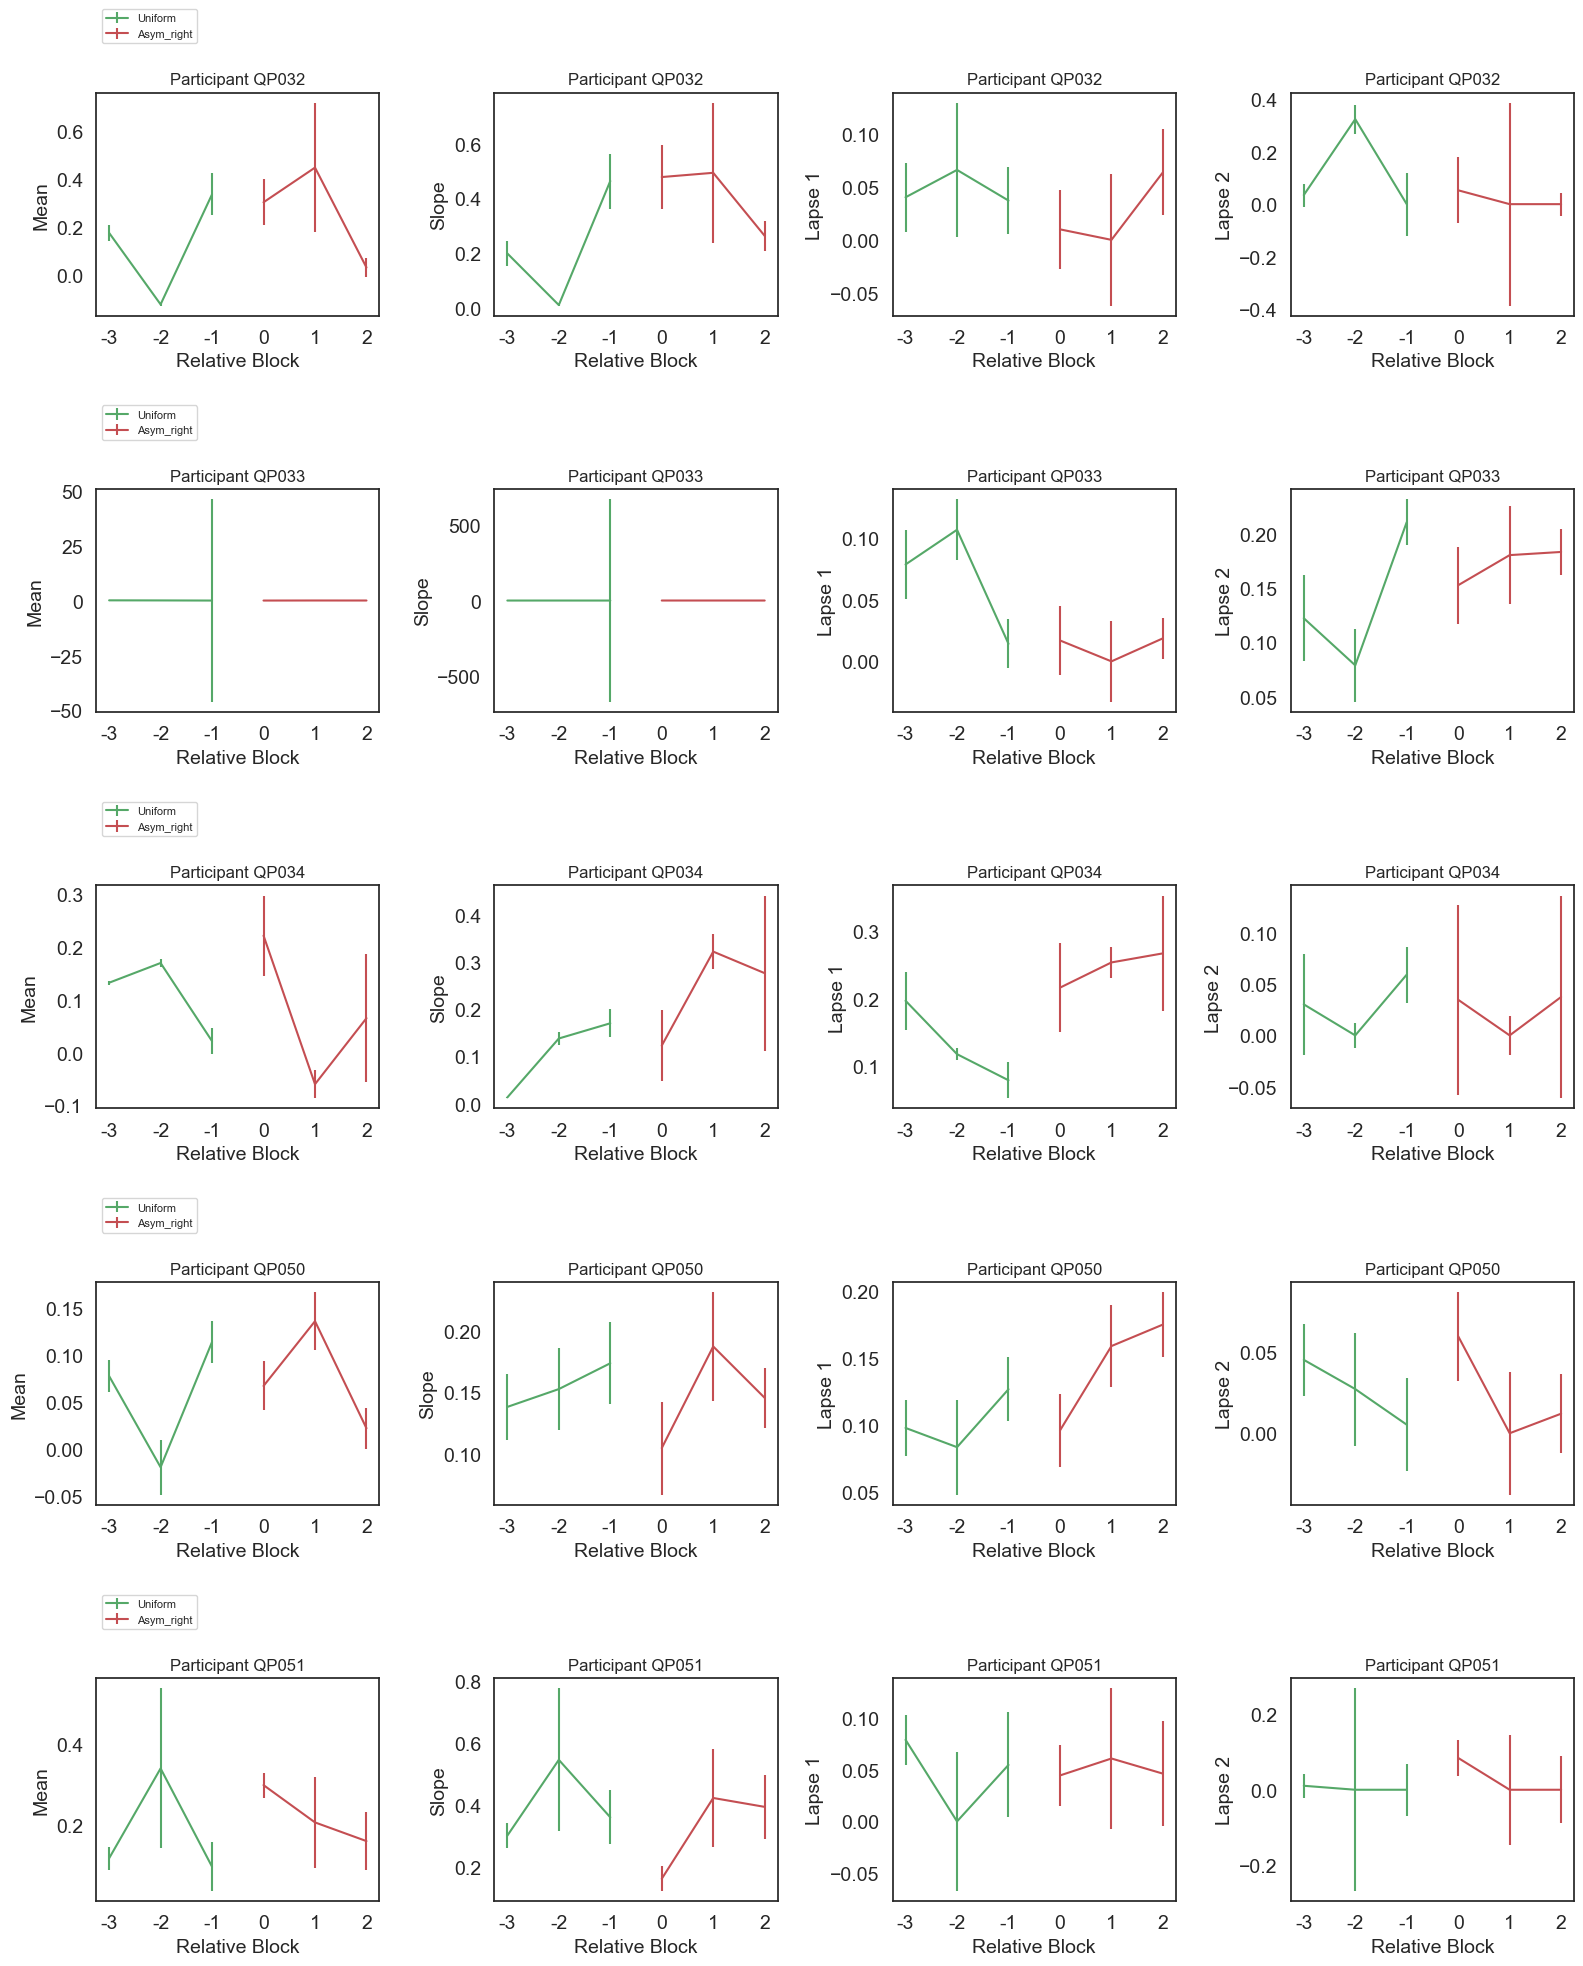

In [2840]:
# create a list of unique participant IDs
participant_ids = filtered_df['Participant_ID'].unique()

# set up figure and axis objects
fig, axs = plt.subplots(len(participant_ids), 4, figsize=(4*4, len(participant_ids)*4))

# loop over participants
for i, pid in enumerate(participant_ids):
    # create a filtered dataframe for the current participant
    p_df = filtered_df[filtered_df['Participant_ID'] == pid]

    # perform the analysis as before
    block_means = []
    block_slopes = []
    block_lapses_1 = []
    block_lapses_2 = []
    mean_errors = []
    slope_errors = []
    lapse1_errors = []
    lapse2_errors = []

    for block in np.sort(p_df.block_relative.unique()):
        block_df = p_df[p_df.block_relative == block]
        choice_data = block_df.groupby('stim_relative_binned')['choice'].agg(['mean','count', 
                                                                         'var', 'std', 'sem'])
        x = choice_data.index
        y = choice_data['mean'].values
        par, mcov = curve_fit(psychometric, x, y, bounds=([-1., 0.01, 0., 0.], [1., 10, .5, .5]))
        block_means.append(par[0])
        block_slopes.append(par[1])
        block_lapses_1.append(par[2])
        block_lapses_2.append(par[3])
        mean_errors.append(np.sqrt(np.diag(mcov))[0])
        slope_errors.append(np.sqrt(np.diag(mcov))[1])
        lapse1_errors.append(np.sqrt(np.diag(mcov))[2])
        lapse2_errors.append(np.sqrt(np.diag(mcov))[3])
#     print(pid, block_means[:3], mean_errors[:3], block_slopes[:3], slope_errors[:3])
    # plot the results for the current participant
    axs[i, 0].errorbar(np.arange(len(block_means)/2), block_means[:3], 
                    yerr=mean_errors[:3], fmt='-', c = 'g', label = 'Uniform')
    axs[i, 0].errorbar(np.arange(len(block_means)/2,len(block_means)), block_means[3:], 
                    yerr=mean_errors[3:], fmt='-', c = 'r', label = 'Asym_right')
    axs[i, 0].set_ylabel('Mean')
    axs[i, 0].legend(loc='upper left', bbox_to_anchor=(0, 1.4), prop={'size': 8})
    axs[i, 1].errorbar(np.arange(len(block_slopes)/2), block_slopes[:3], 
                    yerr=slope_errors[:3], fmt='-', c = 'g')
    axs[i, 1].errorbar(np.arange(len(block_slopes)/2,len(block_slopes)), block_slopes[3:], 
                    yerr=slope_errors[3:], fmt='-', c = 'r')
    axs[i, 1].set_ylabel('Slope')
    axs[i, 2].errorbar(np.arange(len(block_lapses_1)/2), block_lapses_1[:3], 
                    yerr=lapse1_errors[:3], fmt='-', c = 'g')
    axs[i, 2].errorbar(np.arange(len(block_lapses_1)/2,len(block_lapses_1)), block_lapses_1[3:], 
                    yerr=lapse1_errors[3:], fmt='-', c = 'r')
    axs[i, 2].set_ylabel('Lapse 1')
    axs[i, 3].errorbar(np.arange(len(block_lapses_2)/2), block_lapses_2[:3], 
                    yerr=lapse2_errors[:3], fmt='-', c = 'g')
    axs[i, 3].errorbar(np.arange(len(block_lapses_2)/2,len(block_lapses_2)), block_lapses_2[3:], 
                    yerr=lapse2_errors[3:], fmt='-', c = 'r')
    axs[i, 3].set_ylabel('Lapse 2')
    for ax in axs[i, :]:
        ax.set_xticks(np.arange(0, 6, 1),np.arange(-3,3,1))
        ax.set_xlabel('Relative Block')
        ax.set_title('Participant {}'.format(pid))
plt.tight_layout()
plt.show()

#### Asym_right to Asym_left transition

In [2802]:
filtered_df = df[df.No_response == False]
filtered_df = sort_consec_dist(filtered_df, ['Uniform', 'Asym_right', 'Asym_left'])
# group by 'Participant_ID' and 'Distribution'
grouped_df = filtered_df.groupby(['Participant_ID', 'Distribution'])

# apply the function to each group and concatenate the results
filtered_df = pd.concat([filter_switch_blocks(group, dist_1 = 'Asym_right', 
                                              dist_2 = 'Asym_left', 
                                              last_dist_1_blocks= 3,
                                             first_dist_2_blocks= 3) for name, 
                         group in grouped_df])

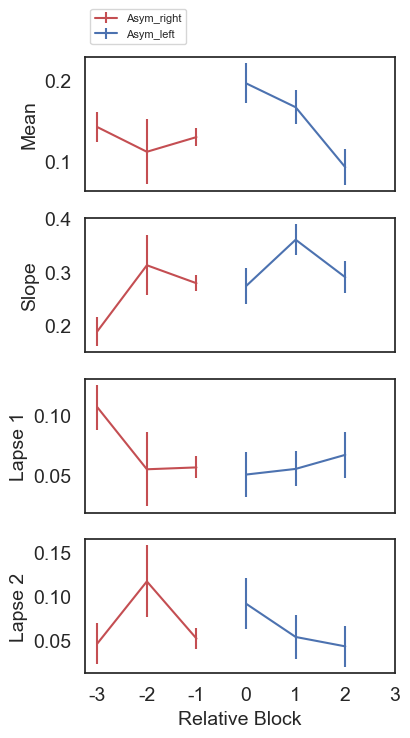

In [2842]:
block_means = []
block_slopes = []
block_lapses_1 = []
block_lapses_2 = []
mean_errors = []
slope_errors = []
lapse1_errors = []
lapse2_errors = []

for block in np.sort(filtered_df.block_relative.unique()):
    block_df = filtered_df[filtered_df.block_relative == block]
    choice_data = block_df.groupby('stim_relative_binned')['choice'].mean()
    x = choice_data.index
    y = choice_data.values
    par, mcov = curve_fit(psychometric, x, y, bounds=([-1., 0.01, 0., 0.], [1., 10, .5, .5]))
    block_means.append(par[0])
    block_slopes.append(par[1])
    block_lapses_1.append(par[2])
    block_lapses_2.append(par[3])
    mean_errors.append(np.sqrt(np.diag(mcov))[0])
    slope_errors.append(np.sqrt(np.diag(mcov))[1])
    lapse1_errors.append(np.sqrt(np.diag(mcov))[2])
    lapse2_errors.append(np.sqrt(np.diag(mcov))[3])

n = 3
m = 3
fig, axs = plt.subplots(4, 1, figsize=(4, 8))
axs[0].errorbar(np.arange(n), block_means[:n], 
                yerr=mean_errors[:n], fmt='-', c = 'r', label = 'Asym_right')
axs[0].errorbar(np.arange(n,len(block_means)), block_means[-m:], 
                yerr=mean_errors[-m:], fmt='-', c = 'b', label = 'Asym_left')
axs[0].set_ylabel('Mean')
axs[0].legend(loc='upper left', bbox_to_anchor=(0, 1.4), prop={'size': 8})

axs[1].errorbar(np.arange(n), block_slopes[:n], 
                yerr=slope_errors[:n], fmt='-', c = 'r')
axs[1].errorbar(np.arange(n,len(block_means)), block_slopes[-m:], 
                yerr=slope_errors[-m:], fmt='-', c = 'b')
axs[1].set_ylabel('Slope')

axs[2].errorbar(np.arange(n), block_lapses_1[:n], 
                yerr=lapse1_errors[:n], fmt='-', c = 'r')
axs[2].errorbar(np.arange(n,len(block_means)), block_lapses_1[-m:], 
                yerr=lapse1_errors[-m:], fmt='-', c = 'b')
axs[2].set_ylabel('Lapse 1')

axs[3].errorbar(np.arange(n), block_lapses_2[:n], 
                yerr=lapse2_errors[:n], fmt='-', c = 'r')
axs[3].errorbar(np.arange(n,len(block_means)), block_lapses_2[-m:], 
                yerr=lapse2_errors[-m:], fmt='-', c = 'b')
axs[3].set_ylabel('Lapse 2')

for ax in axs.flat:
    ax.set_xticks(np.arange(0, len(block_means)+1, 1),np.arange(-n,m+1,1))
    ax.set_xlabel('Relative Block')
    ax.label_outer()

In [2848]:
filtered_df = df[df.No_response == False]
filtered_df = sort_consec_dist(filtered_df, ['Uniform', 'Asym_right', 'Asym_left'])
# group by 'Participant_ID' and 'Distribution'
grouped_df = filtered_df.groupby(['Participant_ID', 'Distribution'])

# apply the function to each group and concatenate the results
filtered_df = pd.concat([filter_switch_blocks(group, dist_1 = 'Asym_right', 
                                              dist_2 = 'Asym_left', 
                                              last_dist_1_blocks= 3,
                                             first_dist_2_blocks= 3) for name, 
                         group in grouped_df])

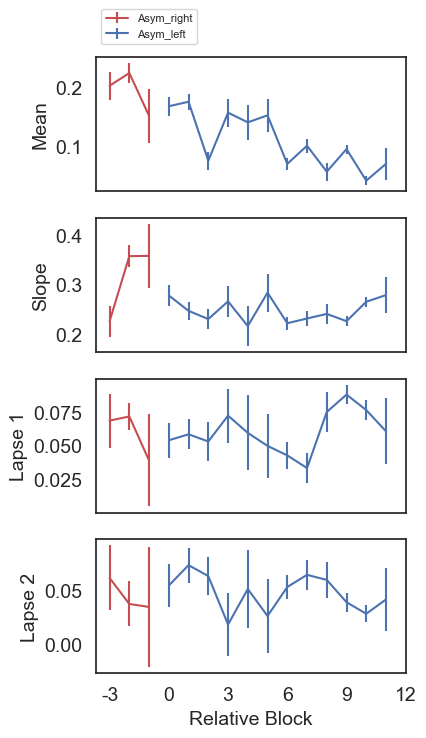

In [2847]:
block_means = []
block_slopes = []
block_lapses_1 = []
block_lapses_2 = []
mean_errors = []
slope_errors = []
lapse1_errors = []
lapse2_errors = []

for block in np.sort(filtered_df.block_relative.unique()):
    block_df = filtered_df[filtered_df.block_relative == block]
    choice_data = block_df.groupby('stim_relative_binned')['choice'].mean()
    x = choice_data.index
    y = choice_data.values
    par, mcov = curve_fit(psychometric, x, y, bounds=([-1., 0.01, 0., 0.], [1., 10, .5, .5]))
    block_means.append(par[0])
    block_slopes.append(par[1])
    block_lapses_1.append(par[2])
    block_lapses_2.append(par[3])
    mean_errors.append(np.sqrt(np.diag(mcov))[0])
    slope_errors.append(np.sqrt(np.diag(mcov))[1])
    lapse1_errors.append(np.sqrt(np.diag(mcov))[2])
    lapse2_errors.append(np.sqrt(np.diag(mcov))[3])

n = 3
m = 12
fig, axs = plt.subplots(4, 1, figsize=(4, 8))
axs[0].errorbar(np.arange(n), block_means[:n], 
                yerr=mean_errors[:n], fmt='-', c = 'r', label = 'Asym_right')
axs[0].errorbar(np.arange(n,len(block_means)), block_means[-m:], 
                yerr = mean_errors[-m:], fmt='-', c = 'b', label = 'Asym_left')
axs[0].set_ylabel('Mean')
axs[0].legend(loc='upper left', bbox_to_anchor=(0, 1.4), prop={'size': 8})

axs[1].errorbar(np.arange(n), block_slopes[:n], 
                yerr=slope_errors[:n], fmt='-', c = 'r')
axs[1].errorbar(np.arange(n,len(block_means)), block_slopes[-m:], 
                yerr=slope_errors[-m:], fmt='-', c = 'b')
axs[1].set_ylabel('Slope')

axs[2].errorbar(np.arange(n), block_lapses_1[:n], 
                yerr=lapse1_errors[:n], fmt='-', c = 'r')
axs[2].errorbar(np.arange(n,len(block_means)), block_lapses_1[-m:], 
                yerr=lapse1_errors[-m:], fmt='-', c = 'b')
axs[2].set_ylabel('Lapse 1')

axs[3].errorbar(np.arange(n), block_lapses_2[:n], 
                yerr=lapse2_errors[:n], fmt='-', c = 'r')
axs[3].errorbar(np.arange(n,len(block_means)), block_lapses_2[-m:], 
                yerr=lapse2_errors[-m:], fmt='-', c = 'b')
axs[3].set_ylabel('Lapse 2')

for ax in axs.flat:
    ax.set_xticks(np.arange(0, len(block_means)+1, 3),np.arange(-n,m+1,3))
    ax.set_xlabel('Relative Block')
    ax.label_outer()

In [2849]:
# create a list of unique participant IDs
participant_ids = filtered_df['Participant_ID'].unique()

# set up figure and axis objects
fig, axs = plt.subplots(len(participant_ids), 4, figsize=(4*4, len(participant_ids)*4))

# loop over participants
for i, pid in enumerate(participant_ids):
    # create a filtered dataframe for the current participant
    p_df = filtered_df[filtered_df['Participant_ID'] == pid]

    # perform the analysis as before
    block_means = []
    block_slopes = []
    block_lapses_1 = []
    block_lapses_2 = []
    mean_errors = []
    slope_errors = []
    lapse1_errors = []
    lapse2_errors = []

    for block in np.sort(p_df.block_relative.unique()):
        block_df = p_df[p_df.block_relative == block]
        choice_data = block_df.groupby('stim_relative_binned')['choice'].mean()
        x = choice_data.index
        y = choice_data.values
        par, mcov = curve_fit(psychometric, x, y, bounds=([-1., 0.01, 0., 0.], [1., 10, .5, .5]))
        block_means.append(par[0])
        block_slopes.append(par[1])
        block_lapses_1.append(par[2])
        block_lapses_2.append(par[3])
        mean_errors.append(np.sqrt(np.diag(mcov))[0])
        slope_errors.append(np.sqrt(np.diag(mcov))[1])
        lapse1_errors.append(np.sqrt(np.diag(mcov))[2])
        lapse2_errors.append(np.sqrt(np.diag(mcov))[3])

    # plot the results for the current participant
    axs[i, 0].errorbar(np.arange(len(block_means)/2), block_means[:3], 
                    yerr=mean_errors[:3], fmt='-', c = 'r', label = 'Asym_right')
    axs[i, 0].errorbar(np.arange(len(block_means)/2,len(block_means)), block_means[3:], 
                    yerr=mean_errors[3:], fmt='-', c = 'b', label = 'Asym_left')
    axs[i, 0].set_ylabel('Mean')
    axs[i, 0].legend(loc='upper left', bbox_to_anchor=(0, 1.4), prop={'size': 8})
    axs[i, 1].errorbar(np.arange(len(block_slopes)/2), block_slopes[:3], 
                    yerr=slope_errors[:3], fmt='-', c = 'r')
    axs[i, 1].errorbar(np.arange(len(block_slopes)/2,len(block_slopes)), block_slopes[3:], 
                    yerr=slope_errors[3:], fmt='-', c = 'b')
    axs[i, 1].set_ylabel('Slope')
    axs[i, 2].errorbar(np.arange(len(block_lapses_1)/2), block_lapses_1[:3], 
                    yerr=lapse1_errors[:3], fmt='-', c = 'r')
    axs[i, 2].errorbar(np.arange(len(block_lapses_1)/2,len(block_lapses_1)), block_lapses_1[3:], 
                    yerr=lapse1_errors[3:], fmt='-', c = 'b')
    axs[i, 2].set_ylabel('Lapse 1')
    axs[i, 3].errorbar(np.arange(len(block_lapses_2)/2), block_lapses_2[:3], 
                    yerr=lapse2_errors[:3], fmt='-', c = 'r')
    axs[i, 3].errorbar(np.arange(len(block_lapses_2)/2,len(block_lapses_2)), block_lapses_2[3:], 
                    yerr=lapse2_errors[3:], fmt='-', c = 'b')
    axs[i, 3].set_ylabel('Lapse 2')
    for ax in axs[i, :]:
        ax.set_xticks(np.arange(0, 6, 1),np.arange(-3,3,1))
        ax.set_xlabel('Relative Block')
        ax.set_title('Participant {}'.format(pid))
plt.tight_layout()
plt.show()

## Psycometric curves separated by subject

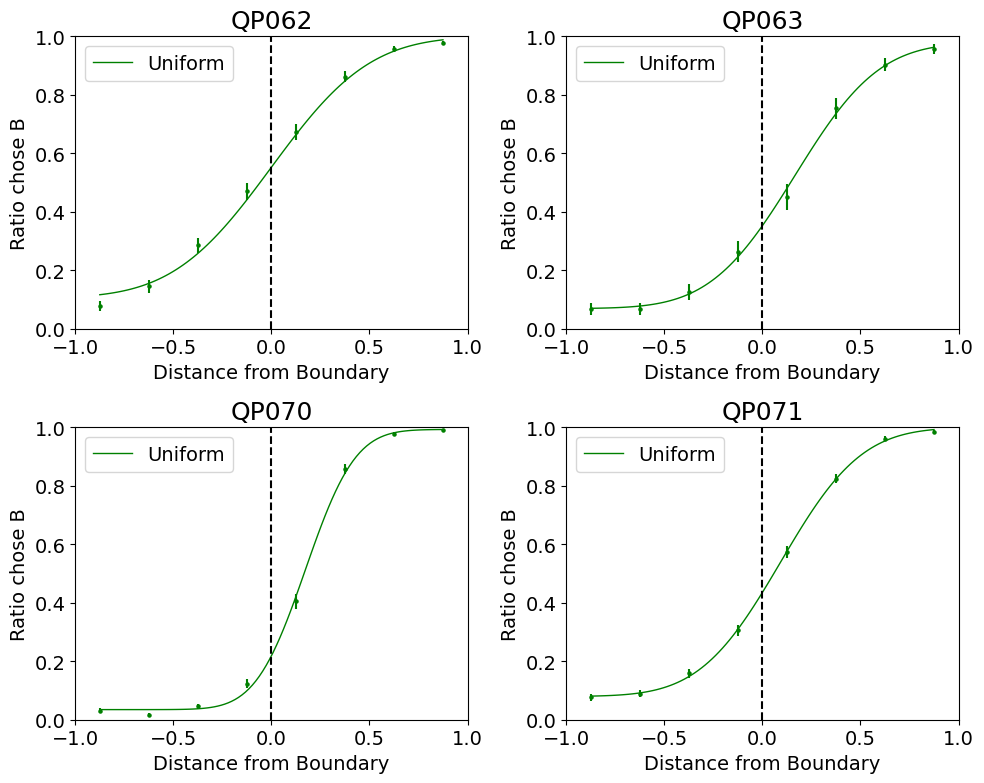

In [31]:
filtered_df = df[df.No_response == False]

fig = plt.figure(figsize=(10, 8))
num_participants = filtered_df.Participant_ID.nunique()
rows = int(np.sqrt(num_participants))
cols = int(np.ceil(num_participants / rows))

distributions = ['Uniform']
filtered_df = filtered_df[filtered_df['Distribution'].isin(distributions)]
color = 'g'
for i, participant_id in enumerate(filtered_df.Participant_ID.unique()):
    plt.subplot(rows, cols, i+1)
    participant_df = filtered_df[filtered_df.Participant_ID == participant_id]
    choice_data = participant_df.groupby('stim_relative_binned')['choice'].agg(['mean','count', 
                                                                         'var', 'std', 'sem'])
    x = choice_data.index
    y = choice_data['mean'].values
    plt.scatter(x, y, c=color, s=5)
    plt.errorbar(x, y, yerr=choice_data['sem'], fmt='.', markersize=2, ecolor=color, c=color)
    par, mcov = curve_fit(psychometric, x, y, bounds=([0, 0.01, 0., 0.], [2, 10, .5, .5]))
    x = np.linspace(x.min(), x.max(), 100)
    y = psychometric(x, *par)
    plt.plot(x, y, label=participant_df.Distribution.unique()[0], color=color, linewidth=1)
    plt.title(participant_id)
    
    plt.xlabel('Distance from Boundary')
    plt.ylabel('Ratio chose B')    
    plt.ylim(0,1)
    plt.xlim(-1,1)  
    plt.axvline(x = 0, color = 'k', linestyle = '--')
    plt.xticks(np.linspace(-1, 1, 5))
    plt.legend()
plt.tight_layout()
plt.show()

## Psycometric curves separated by subject and by distribution

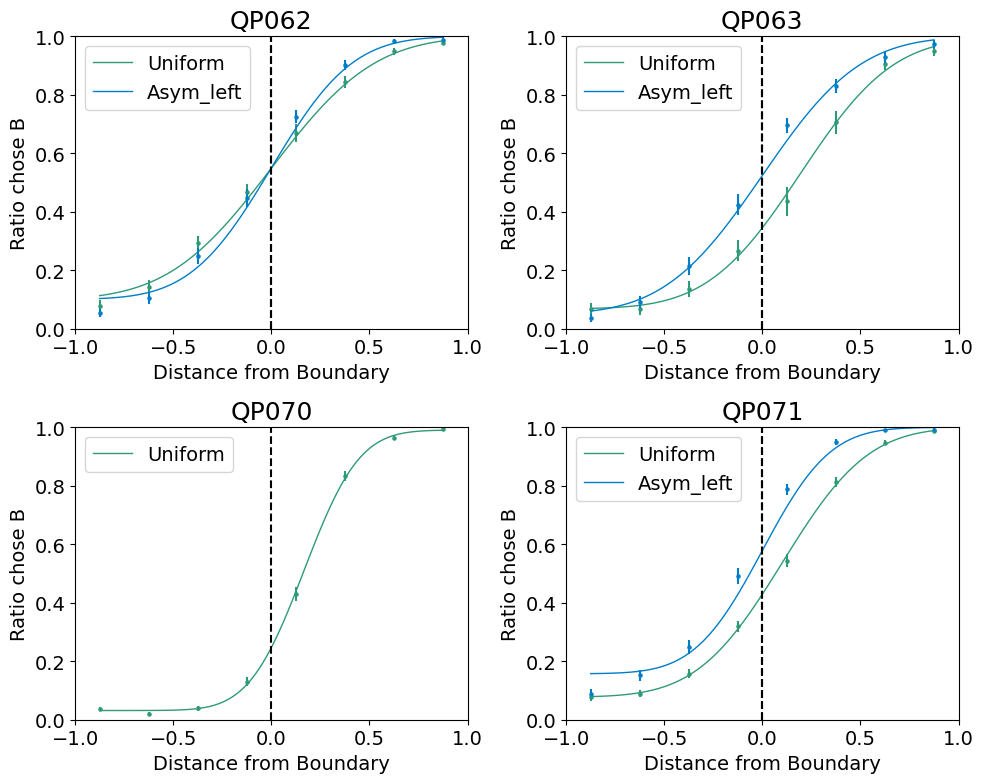

In [21]:
filtered_df = df[df.No_response == False]
# filtered_df = make_blocks_equal(filtered_df)

fig = plt.figure(figsize=(10, 8))
num_participants = filtered_df.Participant_ID.nunique()
rows = int(np.sqrt(num_participants))
cols = int(np.ceil(num_participants / rows))

# define the colors to use for the curves
color_dist = {'Uniform': '#2F9A76', 'Asym_left': '#007dc7', 'Asym_right': '#c23f63'}

distributions = ['Uniform', 'Asym_right', 'Asym_left']
filtered_df = filtered_df[filtered_df['Distribution'].isin(distributions)]

for i, participant_id in enumerate(filtered_df.Participant_ID.unique()):
    plt.subplot(rows, cols, i+1)
    participant_df = filtered_df[filtered_df.Participant_ID == participant_id]

    for distribution in participant_df.Distribution.unique():
        distribution_df = participant_df[participant_df.Distribution == distribution]
        choice_data = distribution_df.groupby('stim_relative_binned')['choice'].agg(['mean','count', 
                                                                         'var', 'std', 'sem'])
        x = choice_data.index
        y = choice_data['mean'].values
        plt.scatter(x, y, c=color_dist[distribution], s=5)
        plt.errorbar(x, y, yerr=choice_data['sem'], fmt='.', markersize=2, 
                     ecolor=color_dist[distribution], c=color_dist[distribution])
        par, mcov = curve_fit(psychometric, x, y, bounds=([0, 0.01, 0., 0.], [2, 10, .5, .5]))
        x = np.linspace(x.min(), x.max(), 100)
        y = psychometric(x, *par)
        plt.plot(x, y, label=distribution, color=color_dist[distribution], linewidth=1)     
        plt.title(participant_id)
        plt.xlabel('Distance from Boundary')
        plt.ylabel('Ratio chose B')    
        plt.ylim(0,1)
        plt.xlim(-1,1)  
        plt.axvline(x = 0, color = 'k', linestyle = '--')
        plt.xticks(np.linspace(-1, 1, 5))
        plt.legend()
plt.tight_layout()
plt.show()


In [27]:
filtered_df

Participant_ID Distribution  Trial  correct  block  stimulus  \
1              QP062      Uniform      1      1.0      0  86.25336   
2              QP062      Uniform      2      1.0      0  78.18247   
3              QP062      Uniform      3      0.0      0  74.69121   
4              QP062      Uniform      4      1.0      0  84.24537   
5              QP062      Uniform      5      1.0      0  88.88004   
...              ...          ...    ...      ...    ...       ...   
26233          QP071    Asym_left    464      1.0     16  83.83163   
26247          QP071    Asym_left    478      1.0     16  84.21423   
26248          QP071    Asym_left    479      1.0     16  82.20037   
26255          QP071    Asym_left    486      1.0     16  84.72093   
26265          QP071    Asym_left    496      1.0     16  81.99210   

       stim_relative stim_relative_binned  choice No_response  \
1           0.640835                0.625     1.0       False   
2           0.136404                0.125     1.0       False   
3          -0.081799               -0.125     1.0       False   
4           0.515336                0.625     1.0       False   
5           0.805002                0.875     1.0       False   
...              ...                  ...     ...         ...   
26233       0.489477                0.625     1.0       False   
26247       0.513389                0.625     1.0       False   
26248       0.387523                0.375     1.0       False   
26255       0.545058                0.625     1.0       False   
26265       0.374506                0.375     1.0       False   

       Response_Latency stim_type  Choice_Rule_Diff Anti_Bias  dist_block  
1                 249.0        WN               0.0     False           1  
2                  83.0        WN               0.0     False           1  
3                  33.0        WN               1.0     False           1  
4                 466.0        WN               0.0     False           1  
5                  99.0        WN               0.0     False           1  
...                 ...       ...               ...       ...         ...  
26233             149.0        WN               0.0     False           6  
26247             199.0        WN               0.0     False           6  
26248             649.0        WN               0.0     False           6  
26255            2199.0        WN               0.0     False           6  
26265            1266.0        WN               0.0     False           6  

[19347 rows x 15 columns]

In [33]:
filtered_df[(filtered_df.Participant_ID == 'QP062') & (filtered_df.Distribution == 'Asym_left')].block.unique()

array([ 7,  8,  9, 10, 11, 12])

## Show learning gradient for each subject

### Uniform to Asym_left switch

In [3017]:
filtered_df = df[df.No_response == False]

# Define the figure size and create a new figure with 4 rows and 3 columns of subplots
fig = plt.figure(figsize=(25, 25))
grid = fig.add_gridspec(4, 3)

# Iterate over each unique value of ‘Participant_ID’
for idx, participant_id in enumerate(filtered_df['Participant_ID'].unique()):
    # Create a new subplot for the current participant
    row_idx = idx // 3
    col_idx = idx % 3
    ax = fig.add_subplot(grid[row_idx, col_idx])

    # Filter the dataframe to only include rows with the current participant ID
    participant_df = filtered_df[filtered_df['Participant_ID'] == participant_id]

    # Filter the dataframe to only include desired rows 
    dist_df = participant_df[participant_df['Distribution'] == 'Uniform']

    color = 'g'
    choice_data = dist_df.groupby('stim_relative_binned')['choice'].agg(['mean','count', 
                                                                         'var', 'std', 'sem'])
    x = choice_data.index
    y = choice_data['mean'].values
    plt.scatter(x, y, c=color, s=5)
    plt.errorbar(x, y, yerr=choice_data['sem'], fmt='.', markersize=2, ecolor=color, c=color)
    par, mcov = curve_fit(psychometric, x, y, bounds=([0, 0.01, 0., 0.], [2, 10, .5, .5]))
    x = np.linspace(x.min(), x.max(), 100)
    y = psychometric(x, *par)
    plt.plot(x, y, label=distribution, color=color, linewidth=1)

    # Generic case for the ‘Asym_left’ condition
    generic_df = participant_df[participant_df['Distribution'] == 'Asym_right']

    # Get a list of unique values of ‘dist_block’ for the ‘Asym_right’ condition
    dist_blocks = generic_df['dist_block'].unique()
    
    light = (1.0, 0.9, 0.9)
    dark = (1.0, 0.0, 0.0) 
    color_map = mcolors.LinearSegmentedColormap.from_list('my_reds', [light, dark])
    colors = color_map(np.linspace(0, 1, dist_blocks.size))

    # Iterate over each unique value of ‘dist_block’
    for i, dist_block in enumerate(dist_blocks):
        # Filter the dataframe to only include rows with the current distribution and dist_block
        if i % 1 == 0:  # Only plot every ith dist_block
            dist_block_df = generic_df[generic_df['dist_block'] == dist_block]
            choice_data = dist_block_df.groupby('stim_relative_binned')['choice'].agg(['mean','count', 
                                                                         'var', 'std', 'sem'])
            x = choice_data.index
            y = choice_data['mean'].values
            plt.scatter(x, y, c=colors[i], s=5)
            plt.errorbar(x, y, yerr=choice_data['sem'], fmt='.', markersize=2, 
                         ecolor=colors[i], c=colors[i])
            par, mcov = curve_fit(psychometric, x, y, bounds=([0, 0.01, 0., 0.], [2, 10, .5, .5]))
            x = np.linspace(x.min(), x.max(), 100)
            y = psychometric(x, *par)
            plt.plot(x, y, 
                     label= 'Session ' + str(dist_block) + ' ' + dist_block_df.Distribution.unique()[0],
                     color=colors[i], linewidth=1)          

    ax.set_ylim(0,1)
    ax.set_xlim(-1,1) 
    ax.set_xticks(np.linspace(-1, 1, 5))
    ax.set_xlabel('Distance from Boundary')
    ax.set_ylabel('Ratio chose B')  
    ax.set_title(f'Participant {participant_id}')
    ax.legend(prop={'size': 6})

plt.tight_layout()
plt.show()



*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

### Asym_right to Asym_left switch 

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

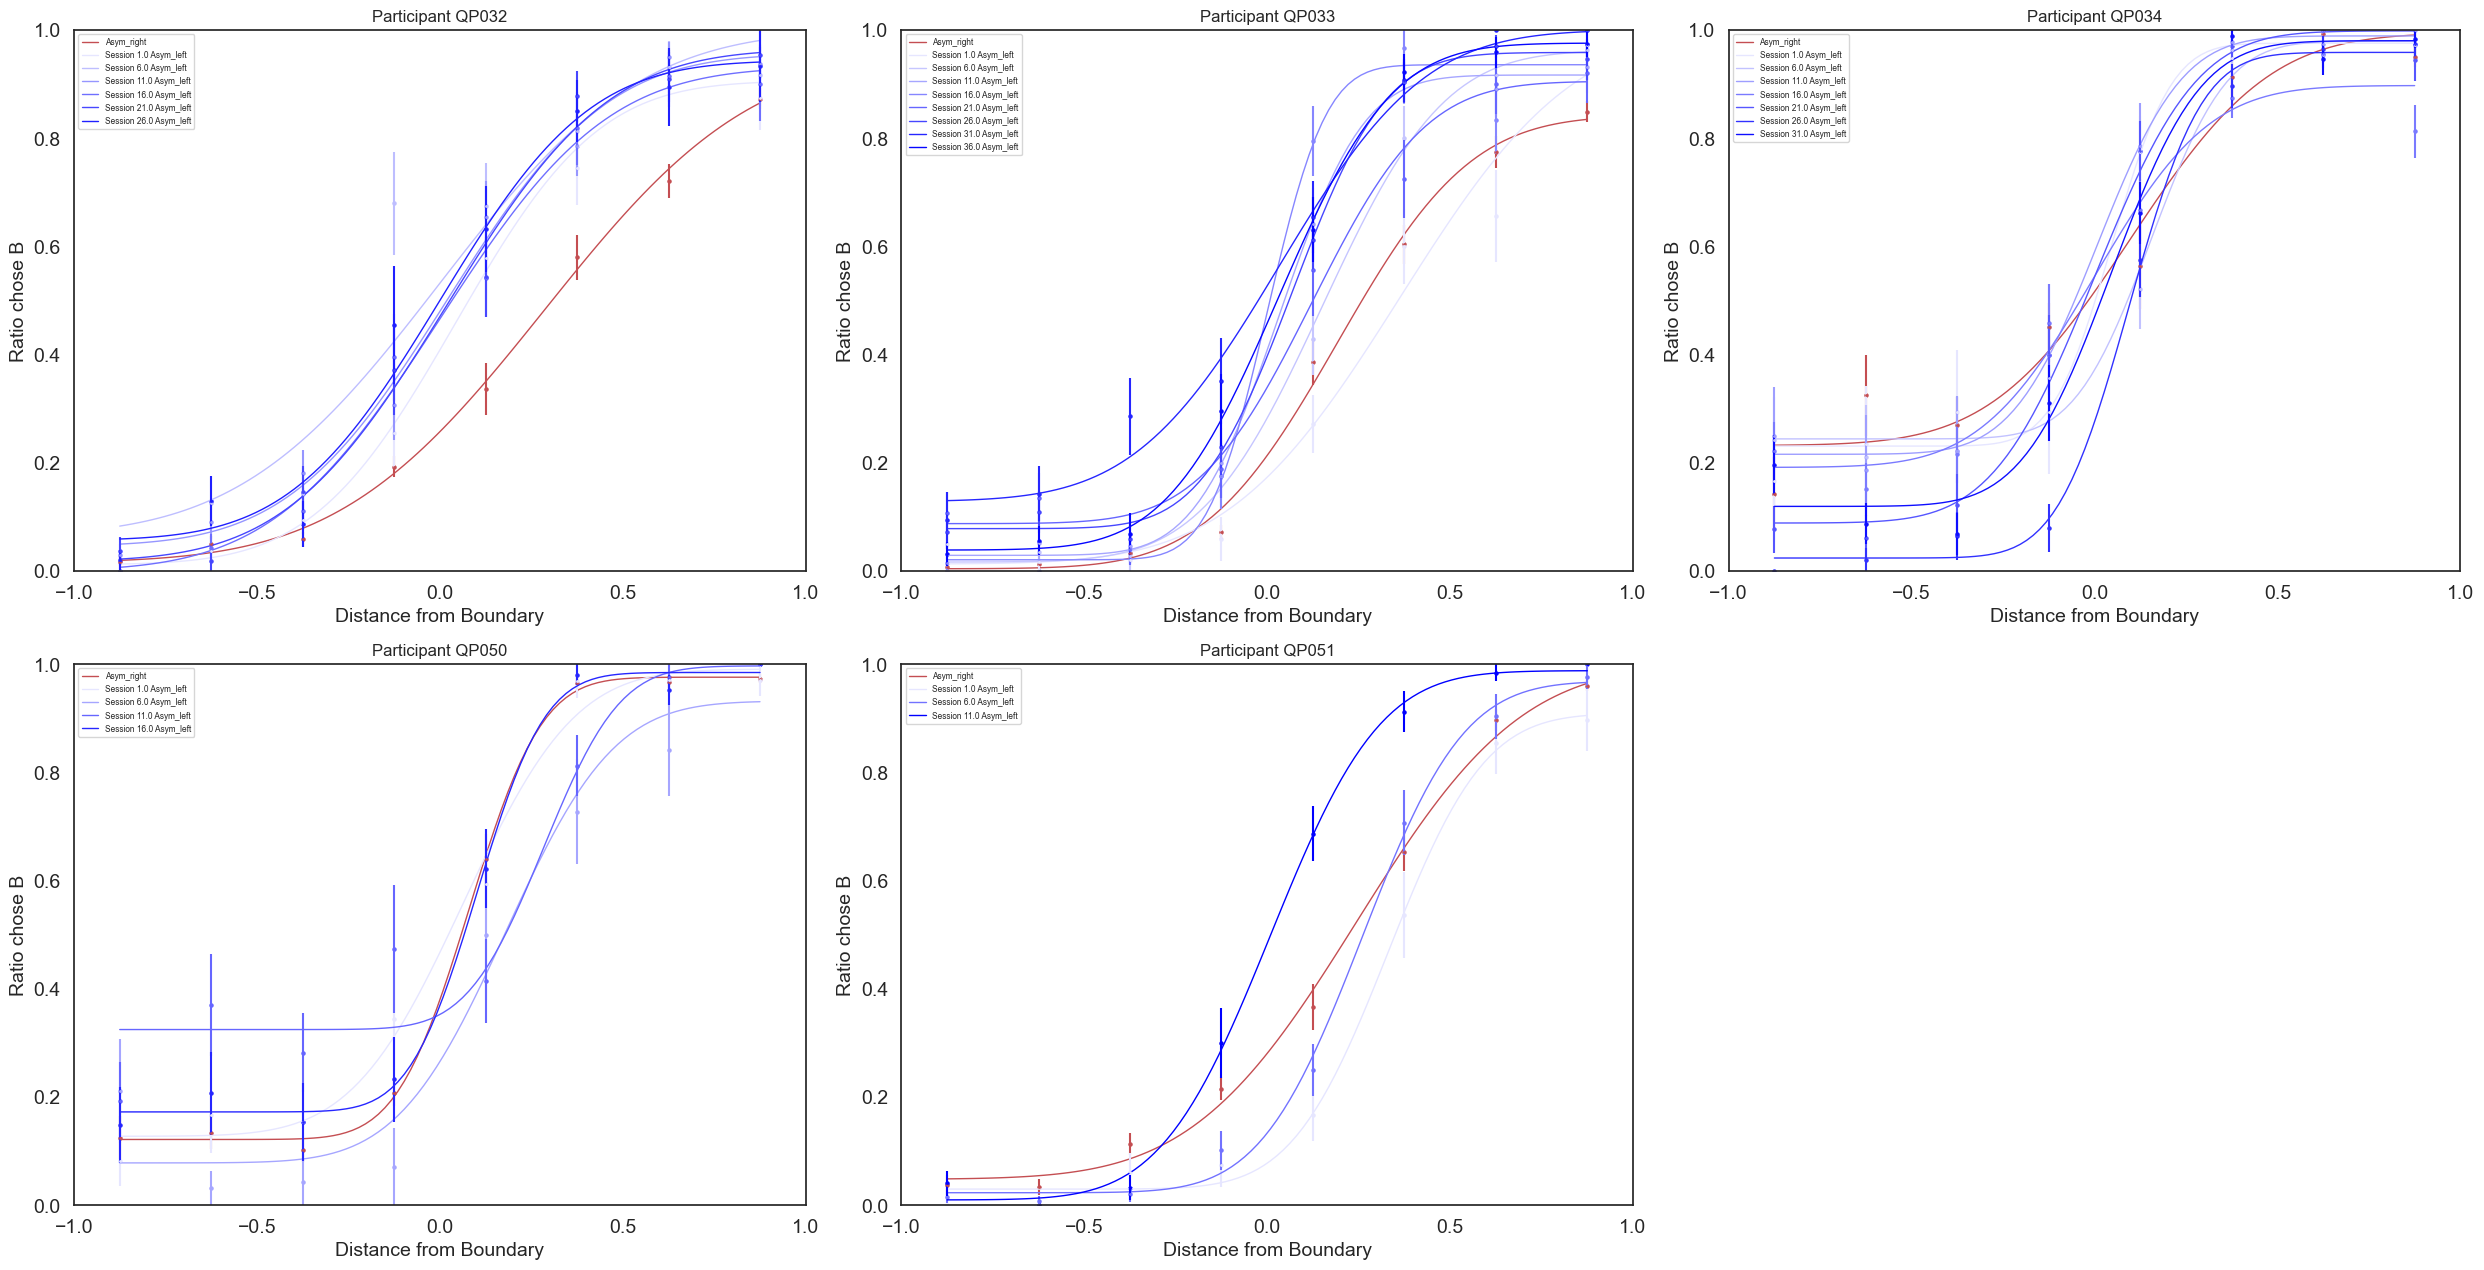

In [3020]:
filtered_df = df[df.No_response == False]

# Define the figure size and create a new figure with 4 rows and 3 columns of subplots
fig = plt.figure(figsize=(25, 25))
grid = fig.add_gridspec(4, 3)

# Iterate over each unique value of ‘Participant_ID’
for idx, participant_id in enumerate(filtered_df['Participant_ID'].unique()):
    # Create a new subplot for the current participant
    row_idx = idx // 3
    col_idx = idx % 3
    ax = fig.add_subplot(grid[row_idx, col_idx])

    # Filter the dataframe to only include rows with the current participant ID
    participant_df = filtered_df[filtered_df['Participant_ID'] == participant_id]

    # Filter the dataframe to only include desired rows 
    sepcial_df = participant_df[participant_df['Distribution'] == 'Asym_right']

    color = 'r'
    choice_data = sepcial_df.groupby('stim_relative_binned')['choice'].agg(['mean','count', 
                                                                         'var', 'std', 'sem'])
    x = choice_data.index
    y = choice_data['mean'].values
    plt.scatter(x, y, c=color, s=5)
    plt.errorbar(x, y, yerr=choice_data['sem'], fmt='.', markersize=2, ecolor=color, c=color)
    par, mcov = curve_fit(psychometric, x, y, bounds=([0, 0.01, 0., 0.], [2, 10, .5, .5]))
    x = np.linspace(x.min(), x.max(), 100)
    y = psychometric(x, *par)
    plt.plot(x, y, label=distribution, color=color, linewidth=1)

    # Generic case for the ‘Asym_left’ condition

    generic_df = participant_df[participant_df['Distribution'] == 'Asym_left']

    # Get a list of unique values of ‘dist_block’ for the ‘Asym_right’ condition
    dist_blocks = generic_df['dist_block'].unique()

#     # Define a color map for the ‘Asym_right’ condition
#     color_map = plt.get_cmap('Reds')
#     colors = color_map(np.linspace(0, 1, dist_blocks.size))
    
    light = (0.9, 0.9, 1.0) # a light shade of red, with RGB values of (1.0, 0.8, 0.8)
    dark = (0.0, 0.0, 1.0) 
    color_map = mcolors.LinearSegmentedColormap.from_list('my_reds', [light, dark])
    colors = color_map(np.linspace(0, 1, dist_blocks.size))

    # Iterate over each unique value of ‘dist_block’
    for i, dist_block in enumerate(dist_blocks):
        # Filter the dataframe to only include rows with the current distribution and dist_block
        if i % 5 == 0:  # Only plot every ith dist_block
            dist_block_df = generic_df[generic_df['dist_block'] == dist_block]
            choice_data = dist_block_df.groupby('stim_relative_binned')['choice'].agg(['mean','count', 
                                                                         'var', 'std', 'sem'])
            x = choice_data.index
            y = choice_data['mean'].values
            plt.scatter(x, y, c=colors[i], s=5)
            plt.errorbar(x, y, yerr=choice_data['sem'], fmt='.', markersize=2, 
                         ecolor=colors[i], c=colors[i])
            par, mcov = curve_fit(psychometric, x, y, bounds=([0, 0.01, 0., 0.], [2, 10, .5, .5]))
            x = np.linspace(x.min(), x.max(), 100)
            y = psychometric(x, *par)
            plt.plot(x, y, 
                     label= 'Session ' + str(dist_block) + ' ' + dist_block_df.Distribution.unique()[0],
                     color=colors[i], linewidth=1)     

    ax.set_ylim(0,1)
    ax.set_xlim(-1,1) 
    ax.set_xticks(np.linspace(-1, 1, 5))
    ax.set_xlabel('Distance from Boundary')
    ax.set_ylabel('Ratio chose B')  
    ax.set_title(f'Participant {participant_id}')
    ax.legend(prop={'size': 6})

plt.tight_layout()
plt.show()

## Psychometric parameters seperated by distribution and subject

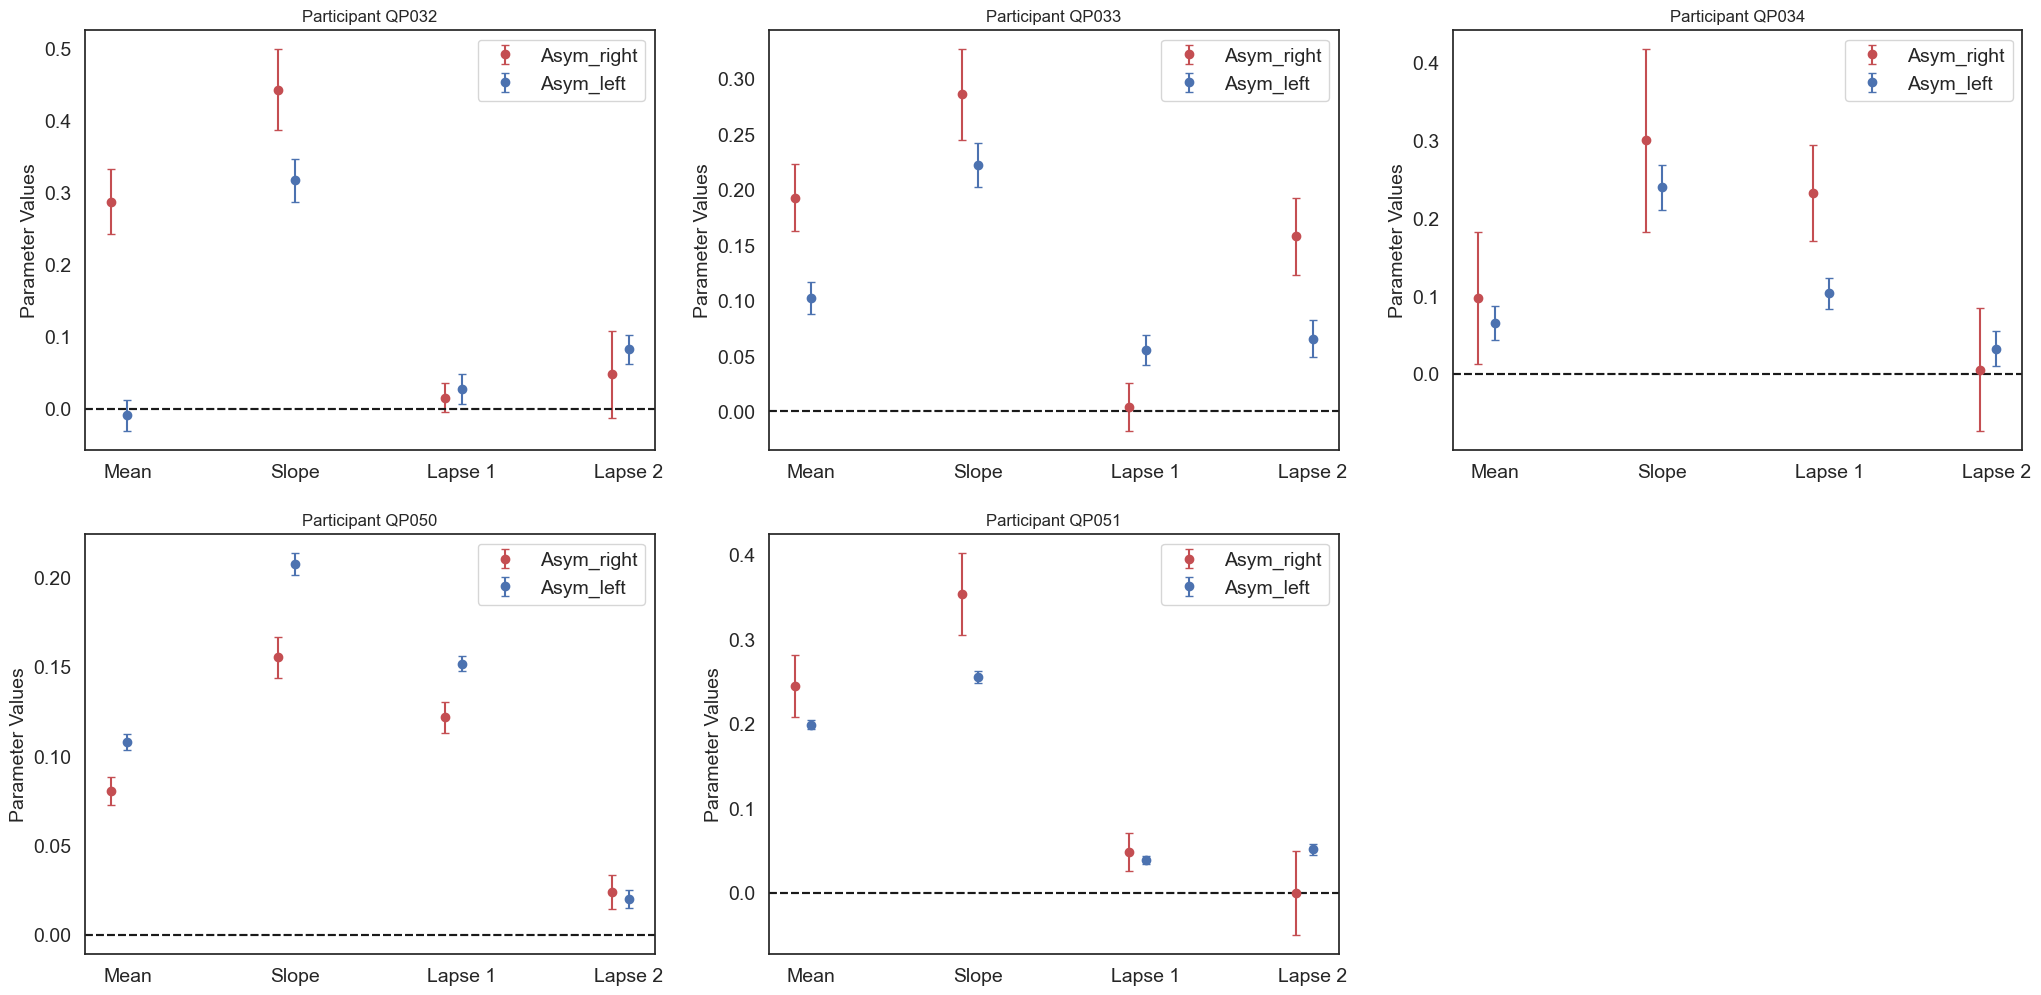

In [2837]:
filtered_df = df[(df['No_response'] == False) & 
                 (df['Distribution'].notna())]

fig = plt.figure(figsize=(25, 12))
num_participants = filtered_df.Participant_ID.nunique()
rows = int(np.sqrt(num_participants))
cols = int(np.ceil(num_participants / rows))

distributions = ['Asym_left', 'Asym_right']
filtered_df = filtered_df[filtered_df['Distribution'].isin(distributions)]

# Set up colors for different distributions
colors = {'Uniform': 'g', 'Asym_left': 'b', 'Asym_right': 'r'}
# Loop over unique Participant_ID values
for i, participant_id in enumerate(filtered_df.Participant_ID.unique()):   
    plt.subplot(rows, cols, i+1)
    participant_df = filtered_df[filtered_df.Participant_ID == participant_id]
    n = -0.1
    for distribution in participant_df['Distribution'].unique():
        # Filter the dataframe to only include rows with the current distribution
        dist_df = participant_df[participant_df['Distribution'] == distribution]

        # Perform the same binning and fitting steps as before
        choice_data = dist_df.groupby('stim_relative_binned')['choice'].agg(['mean','count', 
                                                                         'var', 'std', 'sem'])
        x = choice_data.index
        y = choice_data['mean'].values
        par, mcov = curve_fit(psychometric, x, y, bounds=([-1., 0.01, 0., 0.], [1., 10, .5, .5]))
        perr = np.sqrt(np.diag(mcov))
        x = np.arange(1,5)
        y = par
        y_err = perr
        plt.errorbar(x+n, y, yerr=y_err, fmt='o', color=colors[distribution], capsize=3, label=distribution)
        n += 0.1     
        plt.title(f'Participant {participant_id}')
        plt.axhline(y=0, linestyle='--', color='k')
        xticks = ['Mean', 'Slope', 'Lapse 1', 'Lapse 2']
        plt.xticks(np.arange(1,5), xticks)
        plt.legend()
        plt.ylabel('Parameter Values')
plt.show()


### Adaptiation for individual subjects

## Update Matrices

In [16]:
def add_previous_trial_data(group):
    prev_stim = np.zeros((len(group), 1))
    prev_choices = np.zeros((len(group), 1))
    prev_correct = np.zeros((len(group), 1))

    for iters in np.arange(len(group)):
        if group.iloc[iters].Trial == 0:
            prev_stim[iters,:] = np.nan
            prev_choices[iters,:] = np.nan
            prev_correct[iters,:] = np.nan
        elif group.iloc[iters-1].No_response == True:
            prev_stim[iters,:] = group.iloc[iters-1].stim_relative_binned
            prev_choices[iters,:] = np.nan
            prev_correct[iters,:] = np.nan
        else:
            prev_stim[iters,:] = group.iloc[iters-1].stim_relative_binned
            prev_choices[iters,:] = group.iloc[iters-1].choice
            prev_correct[iters,:] = group.iloc[iters-1].correct 

    group['stim_relative_1'] = prev_stim
    group['choice_1'] = prev_choices
    group['correct_1'] = prev_correct

    return group

# apply the function to each group using groupby
df = df.groupby('Participant_ID').apply(add_previous_trial_data)

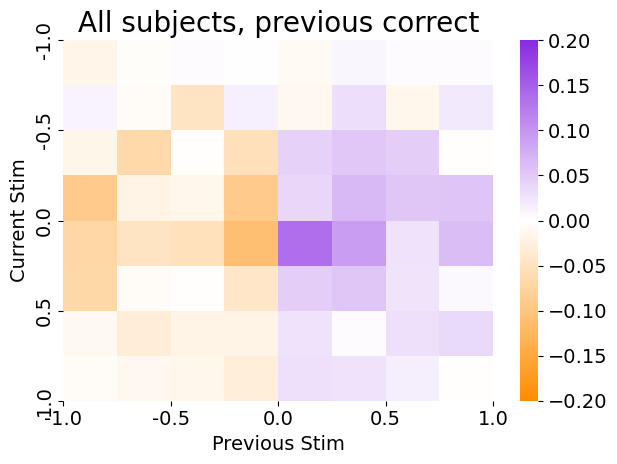

In [20]:
filtered_df = df[df['stim_relative_binned'].notna()]

num_bins = len(filtered_df.stim_relative_binned.unique())
update_matrix = np.zeros((num_bins, num_bins))
prev_correct = 1
prev_correct_df = filtered_df[filtered_df.correct_1==prev_correct]

for column, prev_stim in enumerate(sorted(prev_correct_df.stim_relative_1.unique())):
    prev_stim_df = prev_correct_df[prev_correct_df.stim_relative_1 == prev_stim]
    for row, curr_stim in enumerate(sorted(prev_correct_df.stim_relative_binned.unique())):
        curr_stim_df = prev_stim_df[prev_stim_df.stim_relative_binned == curr_stim] 
        curr_stim_avg_df = prev_correct_df[prev_correct_df.stim_relative_binned == curr_stim]
        val = curr_stim_df.choice.mean() - curr_stim_avg_df.choice.mean() 
        # val is difference between conditional psych at current stim and grand average at current stim
        update_matrix[row,column] = val
update_matrix = np.flip(update_matrix, 0) 
cvals = [-1, 0, 1]
colors = ['darkorange', 'white', 'blueviolet']
norm2 = plt.Normalize(min(cvals), max(cvals))
tuples = list(zip(map(norm2, cvals), colors))
cmap2 = matplotlib.colors.LinearSegmentedColormap.from_list('', tuples)

g = sns.heatmap(update_matrix,cmap=cmap2, vmin=-0.20, vmax=0.20)
g.set_xticks(np.arange(0,num_bins+1,2),np.arange(-1,1.5,0.5))
g.set_yticks(np.arange(0,num_bins+1,2),np.arange(-1,1.5,0.5))
plt.title('All subjects, previous correct', size = 20)
plt.xlabel('Previous Stim')
plt.ylabel('Current Stim')

plt.tight_layout()
plt.show()


### Choice updating as a function of previous stimuli

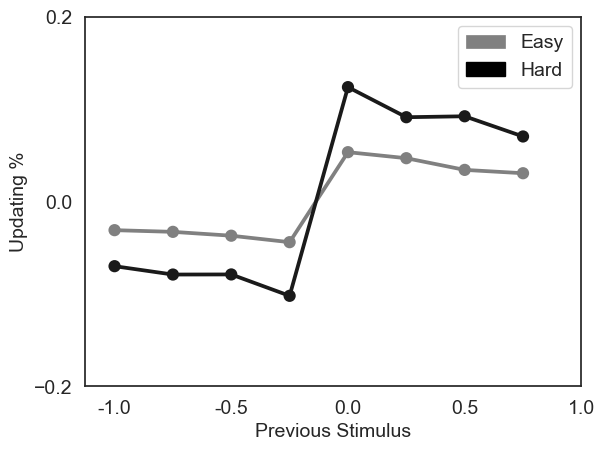

In [2824]:
# Extract the rows of interest
easy_rows_indices = [0, 1, 6, 7]
easy_rows = update_matrix[easy_rows_indices, :]

hard_rows_indices = np.arange(2,6,1)
hard_rows = update_matrix[hard_rows_indices, :]

easy_average = np.nanmean(easy_rows[:, 0:len(update_matrix)], axis=0)
ax = sns.pointplot(x=np.arange(0, len(update_matrix),1), 
                   y=easy_average,
                   color='gray')

hard_average = np.nanmean(hard_rows[:, 0:len(update_matrix)], axis=0)
sns.pointplot(x=np.arange(0, len(update_matrix),1), 
              y=hard_average,
              color='k',
              ax=ax)

ax.set_ylim(-0.2,0.2)
ax.set_yticks(np.arange(-0.2,0.3,0.2))
ax.set_xticks(np.arange(0,len(update_matrix)+1,2))
ax.set_xticklabels(np.arange(-1,1.1,0.5))
ax.set_xlabel('Previous Stimulus')
ax.set_ylabel('Updating %')
ax.legend(handles=[mpatches.Patch(color='gray', label='Easy', linewidth = 0.5), 
                   mpatches.Patch(color='black', label='Hard', linewidth = 1)])

plt.show()

array(['Uniform', 'Asym_right', 'Asym_left'], dtype=object)

In [2320]:
df.stim_relative_binned.unique()

/Users/quentin/opt/anaconda3/lib/python3.9/site-packages/IPython/lib/pretty.py:700: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  output = repr(obj)


[0.375, 0.875, -0.875, -0.625, 0.625, -0.125, -0.375, 0.125]
Categories (8, float64): [-0.875 < -0.625 < -0.375 < -0.125 < 0.125 < 0.375 < 0.625 < 0.875]

Uniform
Asym_right
Asym_left


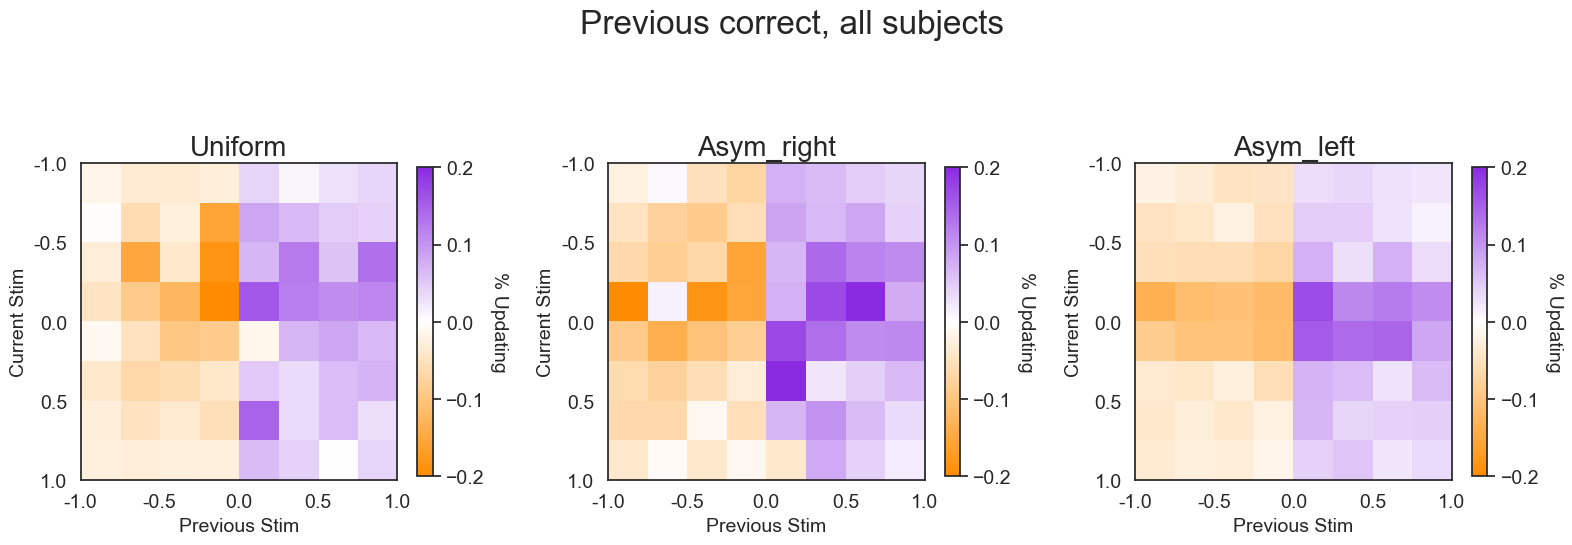

In [2825]:
# filtered_df = filter_transitions_sessions(df, ['Asym_left'], 13)
filtered_df = df

# Define the list of Distributions to plot
distributions = filtered_df.Distribution.unique()

# Set up the figure with subplots for each Distribution
fig, axs = plt.subplots(1, len(distributions), figsize=(16, 6), squeeze=False)

# Convert the numpy array axs to a list of AxesSubplot objects
axs = axs.flatten()

# Loop over each Distribution and generate the heatmap
for i, distribution in enumerate(distributions):
    print(distribution)
    # Filter the data for the current Distribution
    dist_df = filtered_df[filtered_df['Distribution'] == distribution]
    
    # Calculate the number of bins and initialize the update matrix
    num_bins = len(dist_df.stim_relative_binned.unique())
    update_matrix = np.zeros((num_bins, num_bins))
    
    # Filter the data for the previous correct trials
    prev_correct_df = dist_df[filtered_df.correct_1 == 1]
    
    # Loop over each pair of stimuli and calculate the difference in psychometric curves
    for column, prev_stim in enumerate(sorted(prev_correct_df.stim_relative_1.unique())):
        prev_stim_df = prev_correct_df[prev_correct_df.stim_relative_1 == prev_stim]
        for row, curr_stim in enumerate(sorted(prev_correct_df.stim_relative_binned.unique())):
            curr_stim_df = prev_stim_df[prev_stim_df.stim_relative_binned == curr_stim] 
            curr_stim_avg_df = prev_correct_df[prev_correct_df.stim_relative_binned == curr_stim]
            val = curr_stim_df.choice.mean() - curr_stim_avg_df.choice.mean() 
            update_matrix[row, column] = val 
    
    # Flip the update matrix and set up the color map
    update_matrix = np.flip(update_matrix, 0) 
    cvals = [-1, 0, 1]
    colors = ['darkorange', 'white', 'blueviolet']
    norm2 = plt.Normalize(min(cvals), max(cvals))
    tuples = list(zip(map(norm2, cvals), colors))
    cmap2 = matplotlib.colors.LinearSegmentedColormap.from_list('', tuples)
    
    # Generate the heatmap on the current subplot
    im = axs[i].imshow(update_matrix, cmap=cmap2, vmin=-0.20, vmax=0.20)
    axs[i].set_xticks(np.arange(-0.5,num_bins+1,2))
    axs[i].set_xticklabels(np.arange(-1,1.5,0.5))
    axs[i].set_yticks(np.arange(-0.5,num_bins+1,2))
    axs[i].set_yticklabels(np.arange(-1,1.5,0.5))
    axs[i].set_title(distribution, size=20)
    axs[i].set_xlabel('Previous Stim')
    axs[i].set_ylabel('Current Stim')
    
    # Add the color bar to the current subplot
    cbar = axs[i].figure.colorbar(im, ax=axs[i], shrink=0.6)
    cbar.ax.set_ylabel('% Updating', rotation=-90, va="bottom")
    
# Add the overall title and adjust the spacing between subplots
fig.suptitle('Previous correct, all subjects', fontsize=24)
plt.subplots_adjust(wspace=0.5)

plt.tight_layout()
# Show the figure
plt.show()


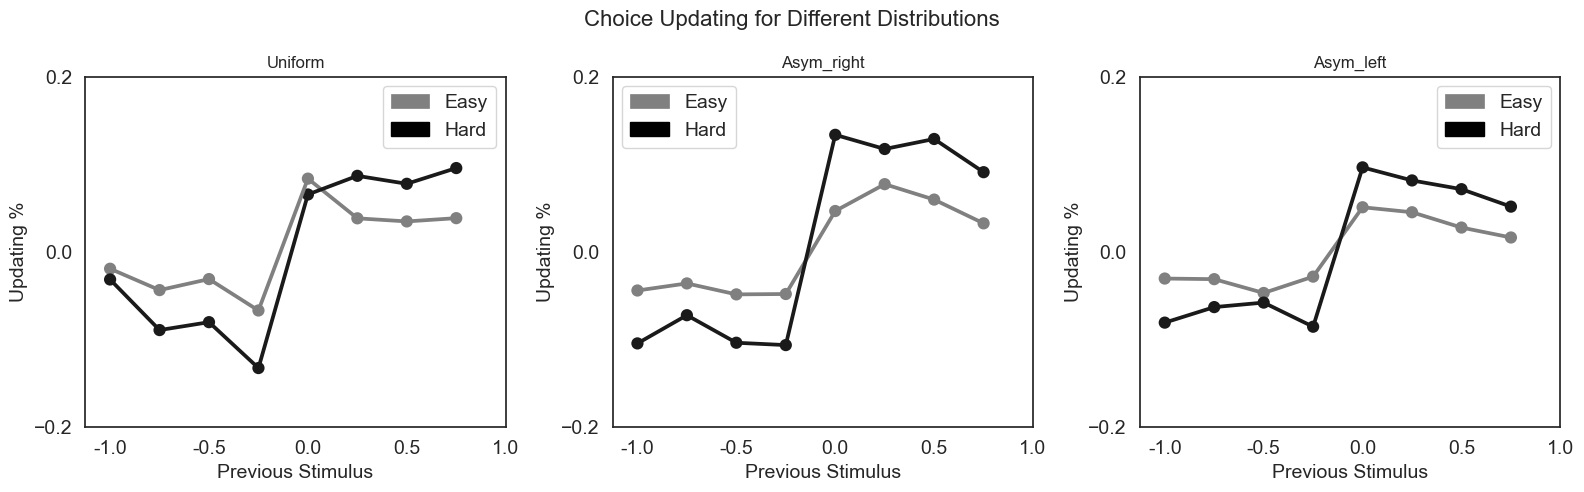

In [2853]:
filtered_df = filter_transitions_sessions(df, ['Asym_left'], 13)
# filtered_df = df

# Define the list of Distributions to plot
distributions = filtered_df.Distribution.unique()

# Set up the figure with subplots for each Distribution
num_distributions = len(distributions)
fig, axs = plt.subplots(1, num_distributions, figsize=(16, 5), squeeze=False)

# Loop over each Distribution and generate the heatmap
for i, distribution in enumerate(distributions):
    # Filter the data for the current Distribution
    dist_df = filtered_df[filtered_df['Distribution'] == distribution]
    
    # Calculate the number of bins and initialize the update matrix
    num_bins = len(dist_df.stim_relative_binned.unique())
    update_matrix = np.zeros((num_bins, num_bins))
    
    # Filter the data for the previous correct trials
    prev_correct_df = dist_df[filtered_df.correct_1 == 1]
    
    # Loop over each pair of stimuli and calculate the difference in psychometric curves
    for column, prev_stim in enumerate(sorted(prev_correct_df.stim_relative_1.unique())):
        prev_stim_df = prev_correct_df[prev_correct_df.stim_relative_1 == prev_stim]
        for row, curr_stim in enumerate(sorted(prev_correct_df.stim_relative_binned.unique())):
            curr_stim_df = prev_stim_df[prev_stim_df.stim_relative_binned == curr_stim] 
            curr_stim_avg_df = prev_correct_df[prev_correct_df.stim_relative_binned == curr_stim]
            val = curr_stim_df.choice.mean() - curr_stim_avg_df.choice.mean() 
            update_matrix[row, column] = val 
    
    # Flip the update matrix and set up the color map
    update_matrix = np.flip(update_matrix, 0) 
    
    # Extract the rows of interest
    easy_rows_indices = [0, 1, 6, 
                         7]
    easy_rows = update_matrix[easy_rows_indices, :]

    hard_rows_indices = np.arange(2,6,1)
    hard_rows = update_matrix[hard_rows_indices, :]

    easy_average = np.nanmean(easy_rows[:, 0:len(update_matrix)], axis=0)
    ax = sns.pointplot(x=np.arange(0, len(update_matrix),1), 
                       y=easy_average,
                       color='gray',
                       ax=axs[0,i])

    hard_average = np.nanmean(hard_rows[:, 0:len(update_matrix)], axis=0)
    sns.pointplot(x=np.arange(0, len(update_matrix),1), 
                  y=hard_average,
                  color='k',
                  ax=axs[0,i])

    axs[0,i].set_ylim(-0.2,0.2)
    axs[0,i].set_yticks(np.arange(-0.2,0.3,0.2))
    axs[0,i].set_xticks(np.arange(0,len(update_matrix)+1,2))
    axs[0,i].set_xticklabels(np.arange(-1,1.1,0.5))
    axs[0,i].set_xlabel('Previous Stimulus')
    axs[0,i].set_ylabel('Updating %')
    axs[0,i].set_title(distribution)
    axs[0,i].legend(handles=[mpatches.Patch(color='gray', label='Easy', linewidth = 0.5), 
                             mpatches.Patch(color='black', label='Hard', linewidth = 1)])

# Add a title for the figure
fig.suptitle("Choice Updating for Different Distributions", fontsize=16)
plt.tight_layout()
plt.show()

In [2335]:
filter_transitions_sessions(df, ['Asym_left'], 30)

Participant_ID Distribution  Trial  correct     stimulus  stim_relative  \
0              QP032      Uniform    0.0      NaN   8958.50100       0.163257   
1              QP032      Uniform    1.0      0.0  13056.20000       0.706663   
2              QP032      Uniform    2.0      1.0   4306.84700      -0.893368   
3              QP032      Uniform    3.0      0.0   5783.06500      -0.468166   
4              QP032      Uniform    4.0      1.0  12260.20000       0.615911   
...              ...          ...    ...      ...          ...            ...   
22775          QP051   Asym_right  641.0      1.0     73.31303      -0.167936   
22776          QP051   Asym_right  642.0      NaN     74.75751      -0.077656   
22777          QP051   Asym_right  643.0      NaN     77.97251       0.123282   
22778          QP051   Asym_right  644.0      NaN     68.70450      -0.455969   
22779          QP051   Asym_right  645.0      NaN     84.25288       0.515805   

      stim_relative_binned  choice No_response  Response_Latency stim_type  \
0                    0.375     NaN        True               NaN        PT   
1                    0.875     0.0       False            1099.0        PT   
2                   -0.875     0.0       False            1616.0        PT   
3                   -0.625     1.0       False             216.0        PT   
4                    0.875     1.0       False            2299.0        PT   
...                    ...     ...         ...               ...       ...   
22775               -0.125     0.0       False             316.0        WN   
22776               -0.125     NaN        True               NaN        WN   
22777                0.125     NaN        True               NaN        WN   
22778               -0.375     NaN        True               NaN        WN   
22779                0.625     NaN        True               NaN        WN   

       Choice_Rule_Diff  block  dist_block  stim_relative_1  choice_1  \
0                   NaN      0         1.0              NaN       NaN   
1                  -1.0      0         1.0            0.375       NaN   
2                   0.0      0         1.0            0.875       0.0   
3                   1.0      0         1.0           -0.875       0.0   
4                   0.0      0         1.0           -0.625       1.0   
...                 ...    ...         ...              ...       ...   
22775               0.0      7         3.0           -0.625       NaN   
22776               NaN      7         3.0           -0.125       0.0   
22777               NaN      7         3.0           -0.125       NaN   
22778               NaN      7         3.0            0.125       NaN   
22779               NaN      7         3.0           -0.375       NaN   

       correct_1  
0            NaN  
1            NaN  
2            0.0  
3            1.0  
4            0.0  
...          ...  
22775        NaN  
22776        1.0  
22777        NaN  
22778        NaN  
22779        NaN  

[22780 rows x 17 columns]

In [2852]:
filtered_df = filter_transitions_sessions(df, ['Asym_left'], 13)

# Define the list of Distributions to plot
distributions = filtered_df.Distribution.unique()

# Set up the figure with subplots for each Distribution
fig, axs = plt.subplots(1, len(distributions), figsize=(16, 6), squeeze=False)

# Convert the numpy array axs to a list of AxesSubplot objects
axs = axs.flatten()

# Loop over each Distribution and generate the heatmap
for i, distribution in enumerate(distributions):
    # Filter the data for the current Distribution
    dist_df = filtered_df[filtered_df['Distribution'] == distribution]
    
    # Calculate the number of bins and initialize the update matrix
    num_bins = len(dist_df.stim_relative_binned.unique())
    update_matrix = np.zeros((num_bins, num_bins))
    
    # Filter the data for the previous correct trials
    prev_correct_df = dist_df[filtered_df.correct_1 == 0]
    
    # Loop over each pair of stimuli and calculate the difference in psychometric curves
    for column, prev_stim in enumerate(sorted(prev_correct_df.stim_relative_1.unique())):
        prev_stim_df = prev_correct_df[prev_correct_df.stim_relative_1 == prev_stim]
        for row, curr_stim in enumerate(sorted(prev_correct_df.stim_relative_binned.unique())):
            curr_stim_df = prev_stim_df[prev_stim_df.stim_relative_binned == curr_stim] 
            curr_stim_avg_df = prev_correct_df[prev_correct_df.stim_relative_binned == curr_stim]
            val = curr_stim_df.choice.mean() - curr_stim_avg_df.choice.mean() 
            update_matrix[row, column] = val 
    
    # Flip the update matrix and set up the color map
    update_matrix = np.flip(update_matrix, 0) 
    cvals = [-1, 0, 1]
    colors = ['darkorange', 'white', 'blueviolet']
    norm2 = plt.Normalize(min(cvals), max(cvals))
    tuples = list(zip(map(norm2, cvals), colors))
    cmap2 = matplotlib.colors.LinearSegmentedColormap.from_list('', tuples)
    
    # Generate the heatmap on the current subplot
    im = axs[i].imshow(update_matrix, cmap=cmap2, vmin=-0.20, vmax=0.20)
    axs[i].set_xticks(np.arange(-0.5,num_bins+1,2))
    axs[i].set_xticklabels(np.arange(-1,1.5,0.5))
    axs[i].set_yticks(np.arange(-0.5,num_bins+1,2))
    axs[i].set_yticklabels(np.arange(-1,1.5,0.5))
    axs[i].set_title(distribution, size=20)
    axs[i].set_xlabel('Previous Stim')
    axs[i].set_ylabel('Current Stim')
    
    # Add the color bar to the current subplot
    cbar = axs[i].figure.colorbar(im, ax=axs[i], shrink=0.6)
    cbar.ax.set_ylabel('% Updating', rotation=-90, va="bottom")
    
# Add the overall title and adjust the spacing between subplots
fig.suptitle('Previous incorrect, all subjects', fontsize=24)
plt.subplots_adjust(wspace=0.5)

plt.tight_layout()
# Show the figure
plt.show()


## Look at the effect of the first 5 trials on session bias

In [2893]:
filtered_df = df[df.No_response == False]
filtered_df.head()

Participant_ID Distribution  Trial  correct   stimulus  stim_relative  \
1          QP032      Uniform    1.0      0.0  13056.200       0.706663   
2          QP032      Uniform    2.0      1.0   4306.847      -0.893368   
3          QP032      Uniform    3.0      0.0   5783.065      -0.468166   
4          QP032      Uniform    4.0      1.0  12260.200       0.615911   
5          QP032      Uniform    5.0      0.0   4572.731      -0.806944   

  stim_relative_binned  choice No_response  Response_Latency stim_type  \
1                0.875     0.0       False            1099.0        PT   
2               -0.875     0.0       False            1616.0        PT   
3               -0.625     1.0       False             216.0        PT   
4                0.875     1.0       False            2299.0        PT   
5               -0.875     1.0       False             333.0        PT   

   Choice_Rule_Diff  block  dist_block  stim_relative_1  choice_1  correct_1  
1              -1.0      0         1.0            0.375       NaN        NaN  
2               0.0      0         1.0            0.875       0.0        0.0  
3               1.0      0         1.0           -0.875       0.0        1.0  
4               0.0      0         1.0           -0.625       1.0        0.0  
5               1.0      0         1.0            0.875       1.0        1.0

In [2894]:
# create an empty list to store the new rows
new_rows = []

# loop through each unique participant in the filtered_df DataFrame
for participant in filtered_df.Participant_ID.unique(): 
    participant_df = filtered_df[filtered_df.Participant_ID == participant]
    # loop through each unique block associated with that participant
    for block in participant_df.block.unique():
        block_df = participant_df[participant_df.block == block]
        # loop through each permutation
        for permutation in perms_arrays:
            # extract the first five choices in the block
            first_five_choices = block_df.iloc[:5].choice.values
            # check if the first five choices match the current permutation
            if np.array_equal(first_five_choices, permutation):
                # calculate the average Choice_Rule_Diff for the participant and block
                avg_diff = block_df.Choice_Rule_Diff.mean()
                # create a new row for the grouped data and add it to the list
                new_rows.append({'Participant_ID': participant, 'block': block, 'permutation': permutation, 'avg_diff': avg_diff})

# create a new DataFrame from the list of new rows
grouped_df = pd.DataFrame(new_rows)

# convert the numpy arrays to tuples
grouped_df['permutation'] = grouped_df['permutation'].apply(tuple)

# group the grouped_df DataFrame by permutation and count the number of occurrences
grouped_df = grouped_df.groupby('permutation').agg({'Participant_ID': 'nunique', 'block': 'count', 'avg_diff': 'mean'}).reset_index()
# # rename the columns
grouped_df.columns = ['permutation', 'num_participants', 'num_blocks', 'avg_diff']


In [2895]:
filtered_df = grouped_df.sort_values(by='avg_diff')


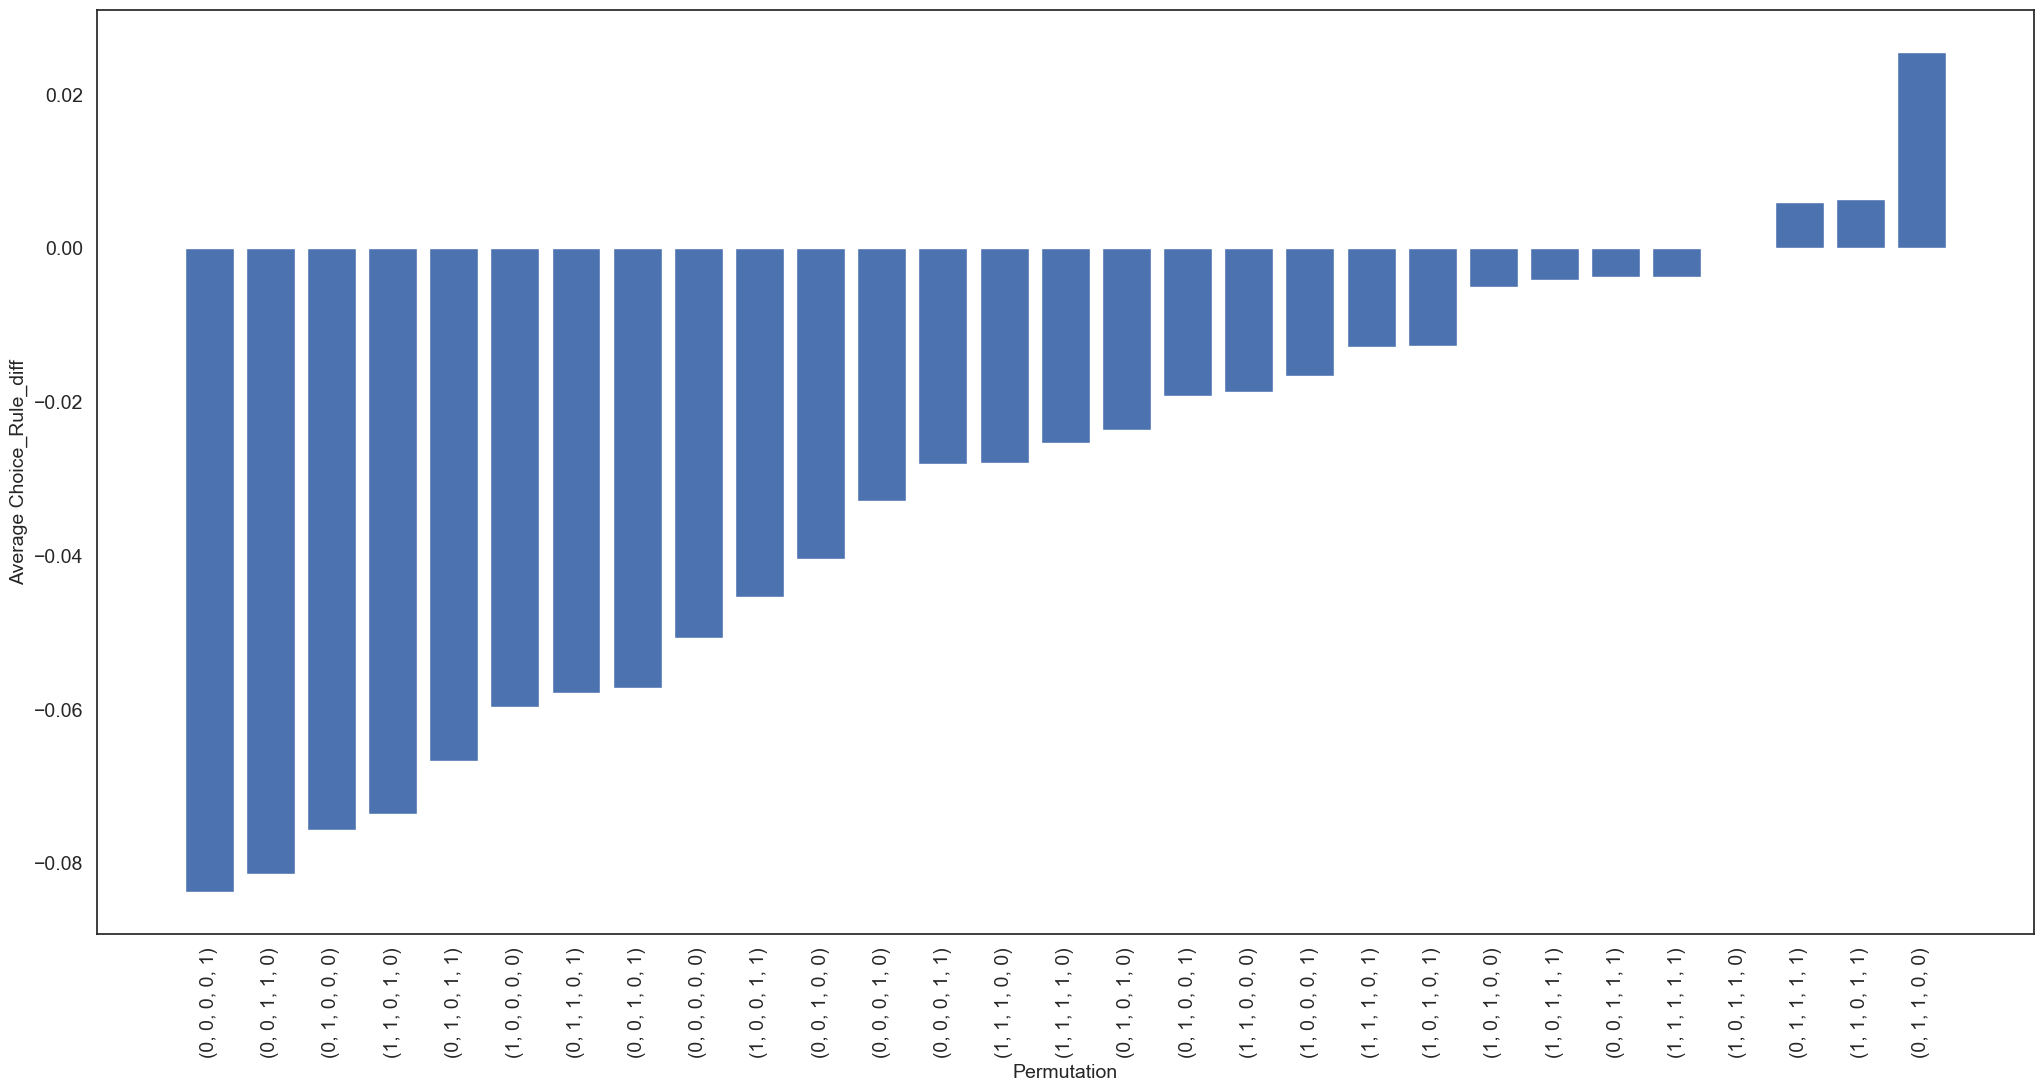

In [2896]:
fig = plt.figure(figsize=(25, 12))

# create a bar plot of avg_dff vs. permutation
plt.bar(range(len(filtered_df)), filtered_df.avg_diff)
plt.xticks(range(len(filtered_df)), filtered_df.permutation)
plt.xlabel('Permutation')
plt.ylabel('Average Choice_Rule_diff')
plt.xticks(rotation=90)
plt.show()


In [2972]:
filtered_df = grouped_df.sort_values(by='num_blocks', ascending=False)


fig = plt.figure(figsize=(25, 12))

# create a bar plot of avg_dff vs. permutation
plt.bar(range(len(filtered_df)), filtered_df.num_blocks, color = 'k', alpha = 0.5)
plt.xticks(range(len(filtered_df)), filtered_df.permutation)
plt.xlabel('First 5 Trials', fontsize = 18)
plt.ylabel('Number of Blocks', fontsize = 18)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

### Look at entropy of first 5 trials

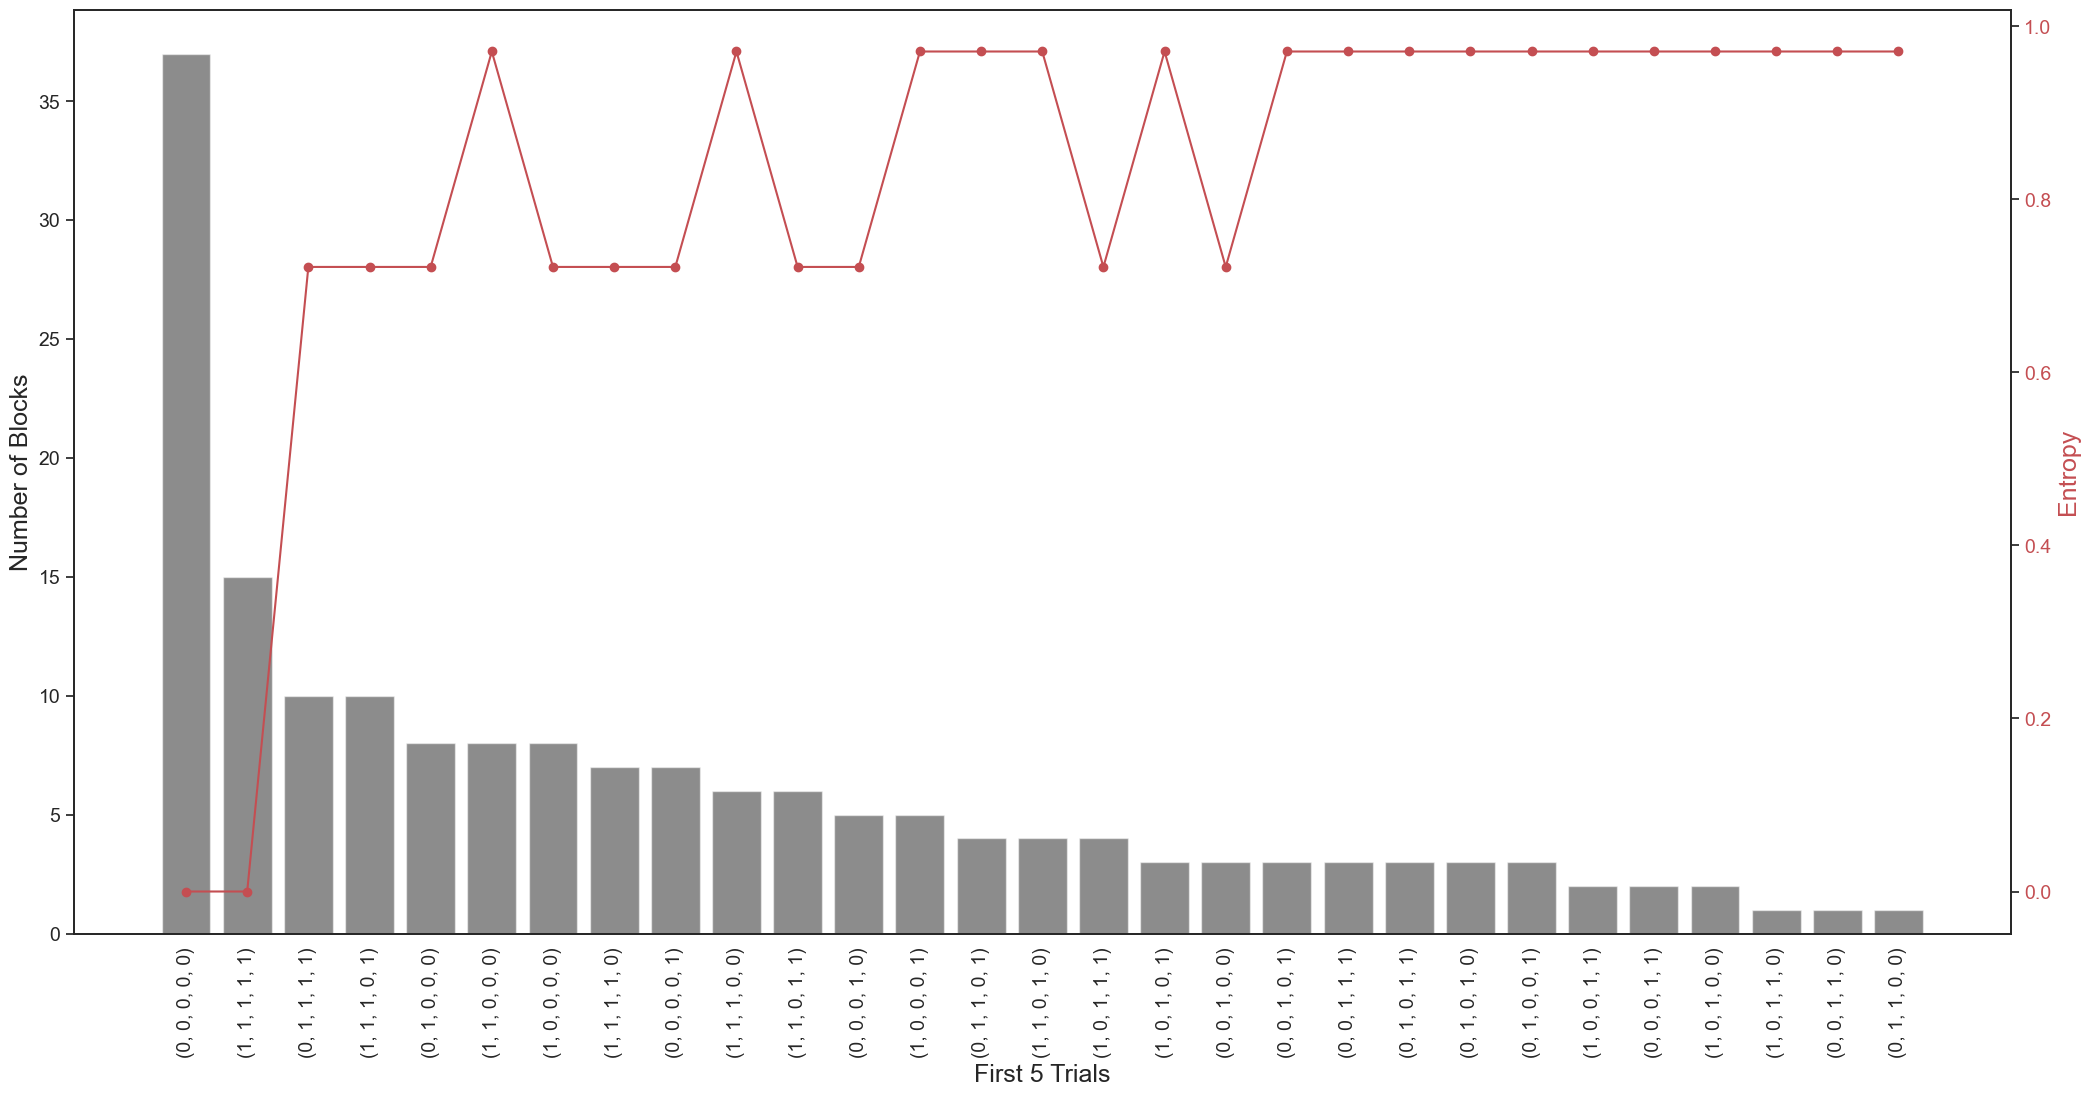

In [2973]:
filtered_df['entropy'] = filtered_df['permutation'].apply(calculate_entropy)

# Create a figure with two y-axes
fig, ax1 = plt.subplots(figsize=(25, 12))
ax2 = ax1.twinx()

# Plot the bar chart of "num_blocks" against permutations on the first y-axis
ax1.bar(range(len(filtered_df)), filtered_df.num_blocks, color='k', alpha=0.5)
ax1.set_xticks(range(len(filtered_df)))
ax1.set_xticklabels(filtered_df.permutation, rotation=90)
ax1.set_xlabel('First 5 Trials', fontsize = 18)
ax1.set_ylabel('Number of Blocks', fontsize = 18)

# Plot the line chart of entropy against permutations on the second y-axis
ax2.plot(range(len(filtered_df)), filtered_df.entropy, '-o', color='r')
ax2.set_ylabel('Entropy', color = 'r', fontsize = 18)

# Set the color of the tick labels for the left y-axis
for label in ax.get_yticklabels():
    label.set_color('k')

# Set the color of the tick labels for the right y-axis
for label in ax2.get_yticklabels():
    label.set_color('r')


# Show the plot
plt.show()

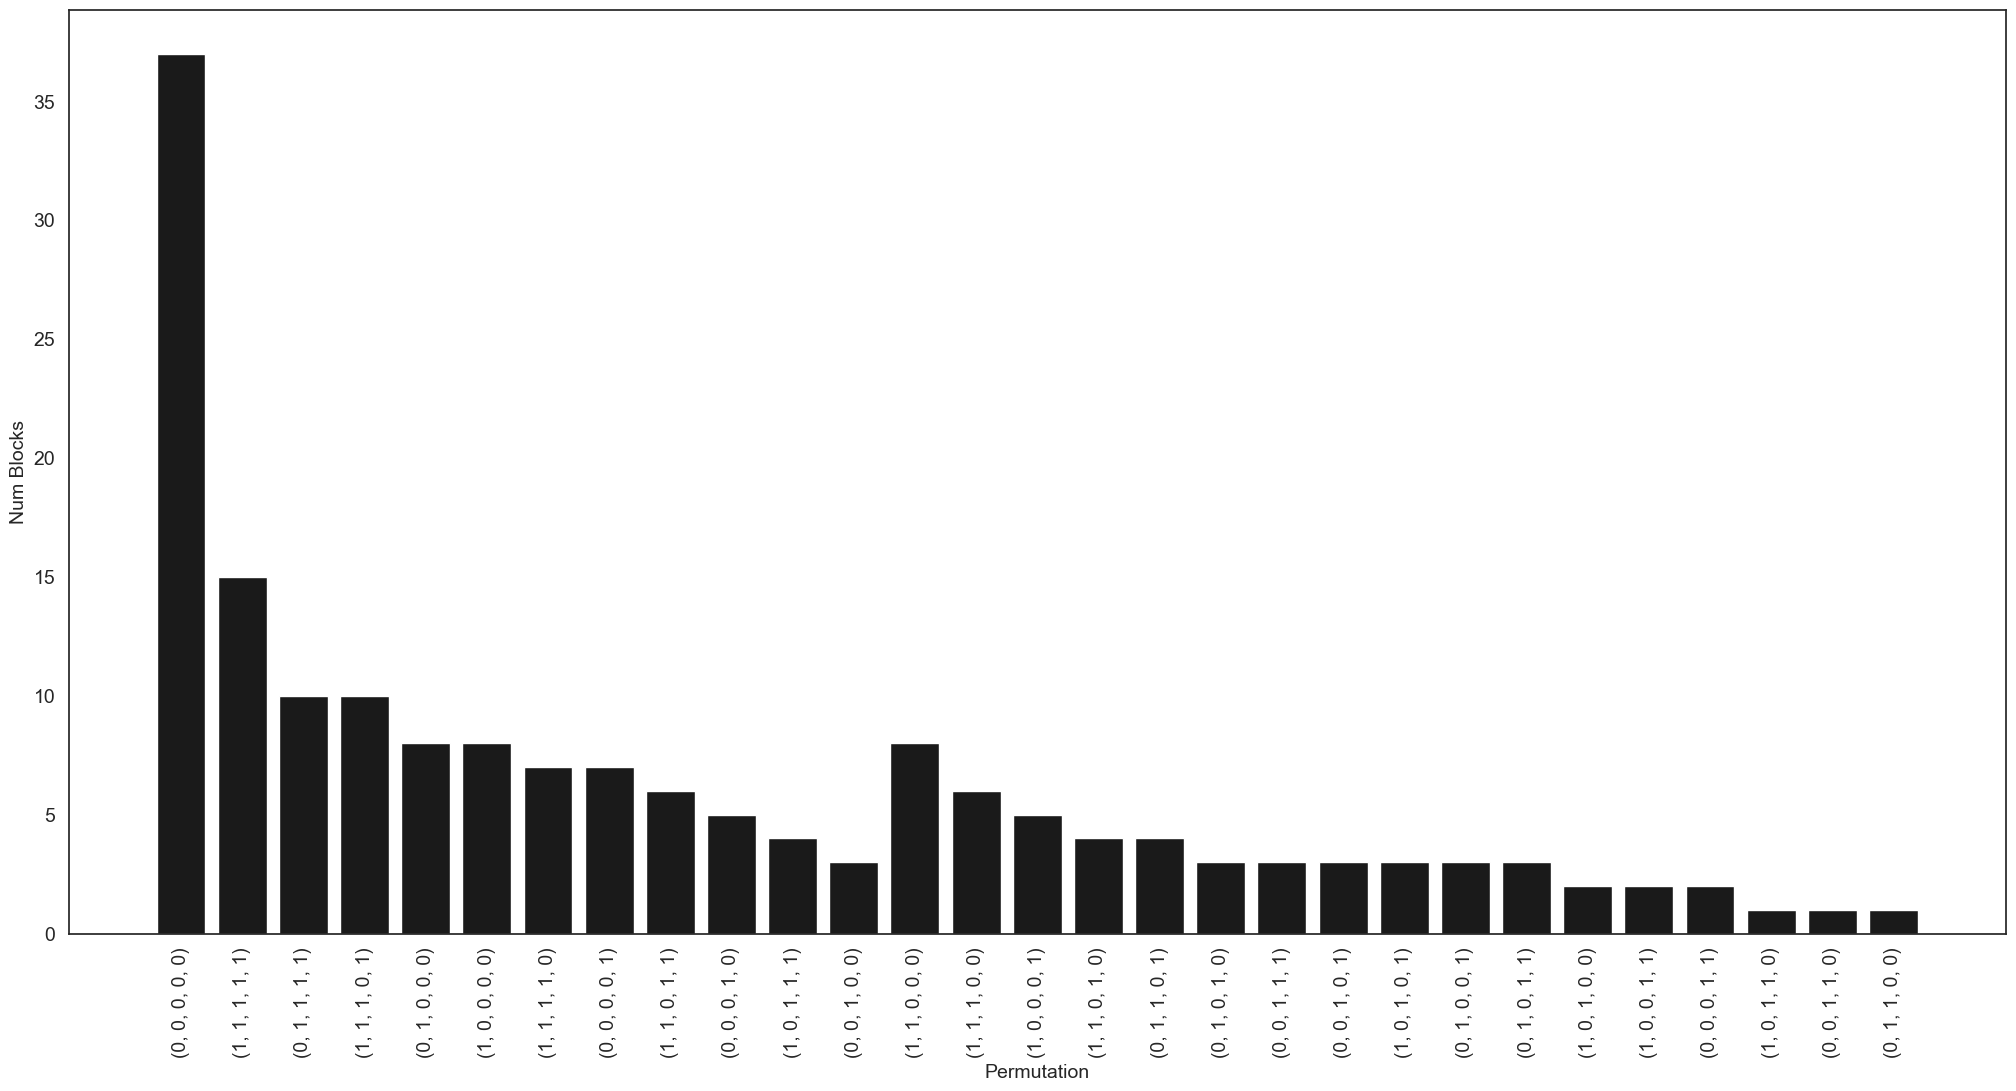

In [2914]:
# Sort by entropy and num blocks

# Sort the DataFrame by ascending entropy
filtered_df = filtered_df.sort_values(by=['entropy', 'num_blocks'], ascending=[True, False])

# Print the merged DataFrame
fig = plt.figure(figsize=(25, 12))

# create a bar plot of avg_dff vs. permutation
plt.bar(range(len(filtered_df)), filtered_df.num_blocks, color = 'k')
plt.xticks(range(len(filtered_df)), filtered_df.permutation)
plt.xlabel('Permutation')
plt.ylabel('Num Blocks')
plt.xticks(rotation=90)
plt.show()

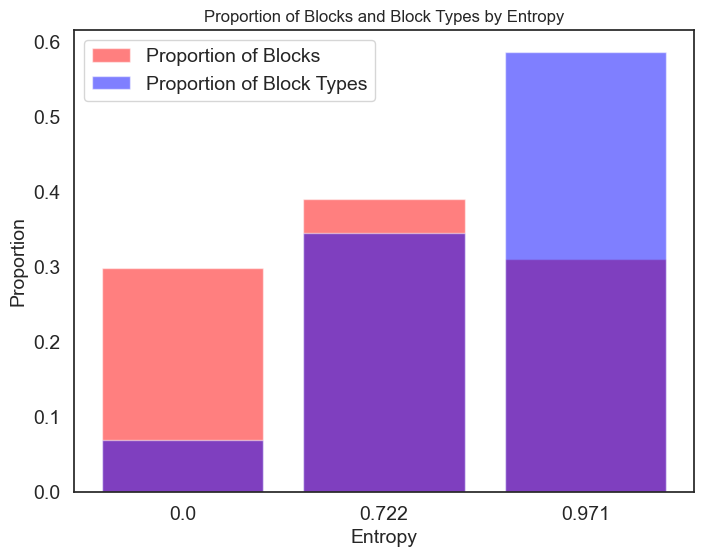

In [3000]:
# Group the data by entropy and count the number of blocks for each group
num_blocks_df = filtered_df.groupby(['entropy'])['num_blocks'].agg(num_blocks='sum').reset_index()
num_blocks_df['entropy'] = num_blocks_df['entropy'].round(3)
num_blocks_df['Proportion'] = num_blocks_df['num_blocks'] / num_blocks_df.num_blocks.sum()

# Group the data by entropy and count the number of block types for each group
block_type_df = filtered_df.groupby(['entropy'])['num_blocks'].agg(block_types='count').reset_index()
block_type_df['entropy'] = block_type_df['entropy'].round(3)
block_type_df['Proportion'] = block_type_df['block_types'] / block_type_df.block_types.sum()

# Create a figure and axes object
fig, ax = plt.subplots(figsize=(8, 6))

# Create bar plots of num_blocks and block_types on the same y-axis
ax.bar(range(len(num_blocks_df)), num_blocks_df['Proportion'], alpha=0.5, color='red', 
       label='Proportion of Blocks')
ax.bar(range(len(block_type_df)), block_type_df['Proportion'], alpha=0.5, color='blue', 
       label='Proportion of Block Types')
ax.set_xlabel('Entropy')
ax.set_ylabel('Proportion')
ax.set_xticks(range(len(num_blocks_df)))
ax.set_xticklabels(num_blocks_df['entropy'])

# Set the title of the plot and adjust the font size
ax.set_title('Proportion of Blocks and Block Types by Entropy')

# Add a legend to the plot
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='best')

# Show the plot
plt.show()


## Look at the distribution of run-lengths 

# Stable_after_switch

In [ ]:
# keep all uniform, remove first n sessions for asym_right and m sessions for asym_left

In [385]:
distribution = 'Uniform'
unif_filter = df[df['Distribution'] == distribution]

# remove first n sessions of asym_right
n = 4
distribution = 'Asym_right'
asym_right_filter = df[df['Distribution'] == distribution]
asym_right_filter = asym_right_filter[asym_right_filter.dist_block > n]

# remove first n sessions of asym_left
m = 5
distribution = 'Asym_left'
asym_left_filter = df[df['Distribution'] == distribution]
asym_left_filter = asym_left_filter[asym_left_filter.dist_block > m]

stable_after_switch = pd.concat([unif_filter, asym_left_filter, asym_right_filter])
stable_after_switch = stable_after_switch.reset_index(drop=True)
stable_after_switch.to_csv('stable_after_switch.csv') # save dataframe as .csv

In [ ]:
# plot again for sanity check

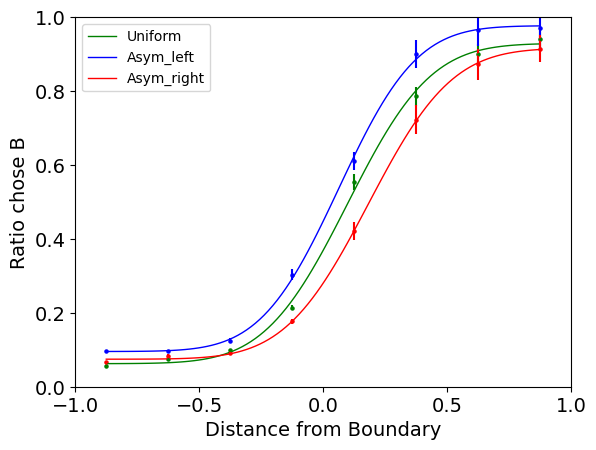

In [374]:
# remove NoResponse trials
filtered_df = stable_after_switch[stable_after_switch.No_response == False]

# remove trials where Distribution in NaN
filtered_df = filtered_df[filtered_df['Distribution'].notna()]

colors = {'Uniform': 'g', 'Asym_left': 'b', 'Asym_right': 'r'}

for distribution in filtered_df.Distribution.unique():
    
    # Filter the dataframe to only include rows with the current distribution
    filtered_df_2 = filtered_df[filtered_df['Distribution'] == distribution]
    # Perform the same binning and fitting steps as before
    binned_data = filtered_df_2.groupby('stim_relative_binned')['choice'].mean()
    x = binned_data.index
    y = binned_data.values
    par, mcov = curve_fit(psychometric, x, y, bounds=([-1., 0.01, 0., 0.], [1., 10, .5, .5]))
    # Plot the fit and data points, but change the color and label based on the current distribution
    x = np.linspace(x.min(), x.max(), 100)
    y = psychometric(x, *par)
    plt.plot(x, y, label=distribution, color=colors[distribution], linewidth = 1)
    plt.scatter(binned_data.index, binned_data.values, c = colors[distribution], s = 5)
    binned_data = filtered_df_2.groupby('stim_relative_binned')['choice'].agg(['mean','count'])
    binned_data['sem'] = binned_data['mean']/np.sqrt(binned_data['count'])
    plt.errorbar(binned_data.index, binned_data['mean'], 
                 yerr=binned_data['sem'], fmt='.', markersize=2, ecolor=colors[distribution], color = colors[distribution])
    
plt.xlabel('Distance from Boundary')
plt.ylabel('Ratio chose B')                
plt.ylim(0,1)
plt.xlim(-1,1)  
plt.xticks(np.linspace(-1, 1, 5))
plt.legend(prop={'size': 10})
plt.savefig(figures_path + 'All_dist.pdf', 
            dpi=300, bbox_inches='tight')
plt.show()

In [384]:
stable_after_switch

Participant_ID Distribution  Trial  correct     stimulus  stim_relative  \
0              QP032      Uniform      0      NaN   8958.50100       0.163257   
1              QP032      Uniform      1      0.0  13056.20000       0.706663   
2              QP032      Uniform      2      1.0   4306.84700      -0.893368   
3              QP032      Uniform      3      0.0   5783.06500      -0.468166   
4              QP032      Uniform      4      1.0  12260.20000       0.615911   
...              ...          ...    ...      ...          ...            ...   
23069          QP051   Asym_right    823      0.0     86.37894       0.648684   
23070          QP051   Asym_right    824      1.0     60.73628      -0.953982   
23071          QP051   Asym_right    825      NaN     86.50110       0.656319   
23072          QP051   Asym_right    826      NaN     85.35184       0.584490   
23073          QP051   Asym_right    827      NaN     74.68172      -0.082393   

       choice No_response Response_Latency stim_type  block  \
0         NaN        True              NaN        PT      0   
1         0.0       False           1099.0        PT      0   
2         0.0       False           1616.0        PT      0   
3         1.0       False            216.0        PT      0   
4         1.0       False           2299.0        PT      0   
...       ...         ...              ...       ...    ...   
23069     0.0       False             1233        WN      9   
23070     0.0       False              133        WN      9   
23071     NaN        True              NaN        WN      9   
23072     NaN        True              NaN        WN      9   
23073     NaN        True              NaN        WN      9   

      stim_relative_binned  dist_block  
0                    0.125           1  
1                    0.875           1  
2                   -0.875           1  
3                   -0.625           1  
4                    0.625           1  
...                    ...         ...  
23069                0.625           5  
23070               -0.875           5  
23071                0.625           5  
23072                0.625           5  
23073               -0.125           5  

[23074 rows x 13 columns]

In [349]:
# filtered_df = filter_transitions_sessions(df = df, 
#                                           distributions_to_filter = ['Asym_left', 'Asym_right'],
#                                           session_threshold = 2)

In [350]:
filtered_df.to_csv('Data_Sound_Cat_Filtered.csv') # save dataframe as .csv

<ErrorbarContainer object of 3 artists>

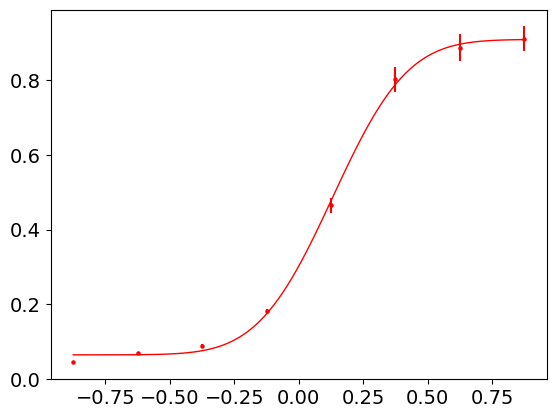

In [351]:
# Special case for the 'Uniform' condition

filtered_df = df[df.No_response == False]
# filtered_df = df
# Group the dataframe by 'Participant_ID' and 'Distribution'
grouped_df = filtered_df.groupby(['Participant_ID','Distribution'])

# Get the maximum 'dist_block' for each group
max_dist_block = grouped_df['dist_block'].max().reset_index()

# Filter the dataframe to only include rows where the 'Distribution' is 'Uniform'
filtered_df = max_dist_block[max_dist_block['Distribution'] == 'Uniform']

# Use the merge function to join the filtered dataframe with the original dataframe
filtered_df = pd.merge(df, filtered_df, on=['Participant_ID','dist_block'], how='inner')

color = 'r'
binned_data = filtered_df.groupby('stim_relative_binned')['choice'].mean()
x = binned_data.index
y = binned_data.values
par, mcov = curve_fit(psychometric, x, y,  bounds=([-1., 0.01, 0., 0.], [1., 10, .5, .5]))
x = np.linspace(x.min(), x.max(), 100)
y = psychometric(x, *par)
plt.plot(x, y, label='Last Uniform', color=color, linewidth = 1)
plt.scatter(binned_data.index, binned_data.values, c = color, s = 5)
binned_data = filtered_df.groupby('stim_relative_binned')['choice'].agg(['mean','count'])
binned_data['sem'] = binned_data['mean']/np.sqrt(binned_data['count'])
plt.errorbar(binned_data.index, binned_data['mean'], yerr=binned_data['sem'], 
             fmt='.', markersize=2, ecolor=color, c = color)

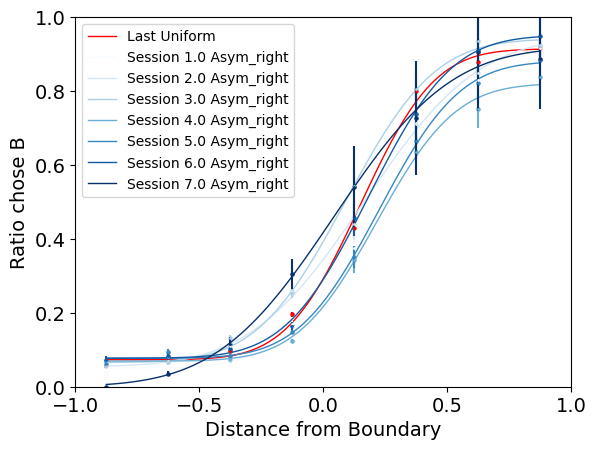

In [93]:
# Special case for the 'Uniform' condition

filtered_df = df[df.No_response == False]
# Group the dataframe by 'Participant_ID' and 'Distribution'
grouped_df = filtered_df.groupby(['Participant_ID','Distribution'])

# Get the maximum 'dist_block' for each group
max_dist_block = grouped_df['dist_block'].max().reset_index()

# Filter the dataframe to only include rows where the 'Distribution' is 'Uniform'
filtered_df = max_dist_block[max_dist_block['Distribution'] == 'Uniform']

# Use the merge function to join the filtered dataframe with the original dataframe
filtered_df = pd.merge(df, filtered_df, on=['Participant_ID','dist_block'], how='inner')

color = 'r'
binned_data = filtered_df.groupby('stim_relative_binned')['choice'].mean()
x = binned_data.index
y = binned_data.values
par, mcov = curve_fit(psychometric, x, y,  bounds=([-1., 0.01, 0., 0.], [1., 10, .5, .5]))
x = np.linspace(x.min(), x.max(), 100)
y = psychometric(x, *par)
plt.plot(x, y, label='Last Uniform', color=color, linewidth = 1)
plt.scatter(binned_data.index, binned_data.values, c = color, s = 5)
binned_data = filtered_df.groupby('stim_relative_binned')['choice'].agg(['mean','count'])
binned_data['sem'] = binned_data['mean']/np.sqrt(binned_data['count'])
plt.errorbar(binned_data.index, binned_data['mean'], yerr=binned_data['sem'], 
             fmt='.', markersize=2, ecolor=color, c = color)

# Generic case for the 'Asym_right' condition

filtered_df = df[df.No_response == False]
filtered_df = filtered_df[filtered_df['Distribution'] == 'Asym_right']

# Get a list of unique values of 'dist_block' for the 'Asym_right' condition
dist_blocks = filtered_df['dist_block'].unique()

# Define a color map for the 'Asym_right' condition
color_map = plt.get_cmap('Blues')
colors = color_map(np.linspace(0, 1, dist_blocks.size))

# Iterate over each unique value of 'dist_block'
for i, dist_block in enumerate(dist_blocks):
    # Filter the dataframe to only include rows with the current distribution and dist_block
    filtered_df2 = filtered_df[filtered_df['dist_block'] == dist_block]
    binned_data = filtered_df2.groupby('stim_relative_binned')['choice'].mean()
    x = binned_data.index
    
    y = binned_data.values
    p0 = [1.0, 70.0, 0.0, 1.0]
    par, mcov = curve_fit(psychometric, x, y, bounds=([-1., 0.01, 0., 0.], [1., 10, .5, .5]))
    x = np.linspace(x.min(), x.max(), 100)
    y = psychometric(x, *par)
    color = colors[i]
    plt.plot(x, y, label= 'Session ' + str(dist_block) + ' Asym_right', color=color, linewidth = 1)
    plt.scatter(binned_data.index, binned_data.values, color = color, s = 5)
    plt.xlabel('Distance from Boundary')
    plt.ylabel('Ratio chose B')
    binned_data = filtered_df2.groupby('stim_relative_binned')['choice'].agg(['mean','count'])
    binned_data['sem'] = binned_data['mean']/np.sqrt(binned_data['count'])
    plt.errorbar(binned_data.index, binned_data['mean'], yerr=binned_data['sem'], 
                 fmt='.', markersize=2, ecolor=color, c = color)

plt.ylim(0,1)
plt.xlim(-1,1) 
plt.xticks(np.linspace(-1, 1, 5))

# Add a legend
plt.legend(prop={'size': 10})

plt.savefig(figures_path + 'Unif_to_asym_right_switch.pdf', 
            dpi=300, bbox_inches='tight')
plt.show()

In [326]:
df.dist_block.unique()

array([1, 2, 3, 4, 5, 6])

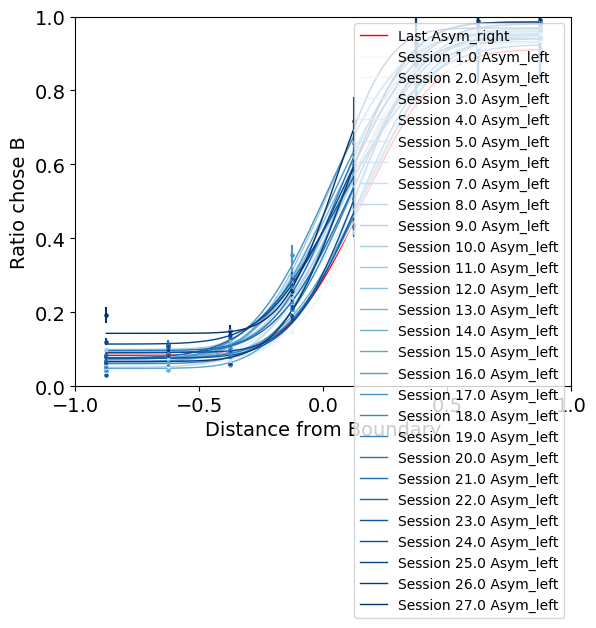

In [94]:
# Special case 

filtered_df = df[df.No_response == False]

# Group the dataframe by 'Participant_ID' and 'Distribution'
grouped_df = df.groupby(['Participant_ID','Distribution'])

# Get the maximum 'dist_block' for each group
max_dist_block = grouped_df['dist_block'].max().reset_index()

# Filter the dataframe to only include rows where the 'Distribution' is 'Uniform'
filtered_df = max_dist_block[max_dist_block['Distribution'] == 'Asym_right']

# Use the merge function to join the filtered dataframe with the original dataframe
filtered_df = pd.merge(df, filtered_df, on=['Participant_ID','dist_block'], how='inner')

color = 'r'
binned_data = filtered_df.groupby('stim_relative_binned')['choice'].mean()
x = binned_data.index
y = binned_data.values
par, mcov = curve_fit(psychometric, x, y, bounds=([-1., 0.01, 0., 0.], [1., 10, .5, .5]))
x = np.linspace(x.min(), x.max(), 100)
y = psychometric(x, *par)
plt.plot(x, y, label='Last Asym_right', color=color, linewidth = 1)
plt.scatter(binned_data.index, binned_data.values, c = 'red', s = 5)
binned_data = filtered_df.groupby('stim_relative_binned')['choice'].agg(['mean','count'])
binned_data['sem'] = binned_data['mean']/np.sqrt(binned_data['count'])
plt.errorbar(binned_data.index, binned_data['mean'], yerr=binned_data['sem'], 
             fmt='.', markersize=2, ecolor=color, c = color)

# Generic case for the 'Asym_left' condition

filtered_df = df[df.No_response == False]

filtered_df = df[df['Distribution'] == 'Asym_left']

# Get a list of unique values of 'dist_block' for the 'Asym_right' condition
dist_blocks = filtered_df['dist_block'].unique()

# Define a color map for the 'Asym_right' condition
color_map = plt.get_cmap('Blues')
colors = color_map(np.linspace(0, 1, dist_blocks.size))

# Iterate over each unique value of 'dist_block'
for i, dist_block in enumerate(dist_blocks):
    # Filter the dataframe to only include rows with the current distribution and dist_block
    filtered_df2 = filtered_df[filtered_df['dist_block'] == dist_block]
    binned_data = filtered_df2.groupby('stim_relative_binned')['choice'].mean()
    x = binned_data.index
    y = binned_data.values
    par, mcov = curve_fit(psychometric, x, y, bounds=([0, 0.01, 0., 0.], [2, 10, .5, .5]))
    x = np.linspace(x.min(), x.max(), 100)
    y = psychometric(x, *par)
    color = colors[i]
    plt.plot(x, y, label= 'Session ' + str(dist_block) + ' Asym_left', color=color, linewidth = 1)
    plt.scatter(binned_data.index, binned_data.values, color = color, s = 5)
    plt.xlabel('Distance from Boundary')
    plt.ylabel('Ratio chose B')
    binned_data = filtered_df2.groupby('stim_relative_binned')['choice'].agg(['mean','count'])
    binned_data['sem'] = binned_data['mean']/np.sqrt(binned_data['count'])
    plt.errorbar(binned_data.index, binned_data['mean'], yerr=binned_data['sem'], 
                 fmt='.', markersize=2, ecolor=color, c = color)

plt.ylim(0,1)
plt.xlim(-1,1) 
plt.xticks(np.linspace(-1, 1, 5))

# Add a legend
plt.legend(prop={'size': 10})
plt.savefig(figures_path + 'Asym_right_to_asym_left_switch.pdf', 
            dpi=300, bbox_inches='tight')
plt.show()


In [48]:
par

array([0.02075931, 0.22235502, 0.08980131, 0.03850707])

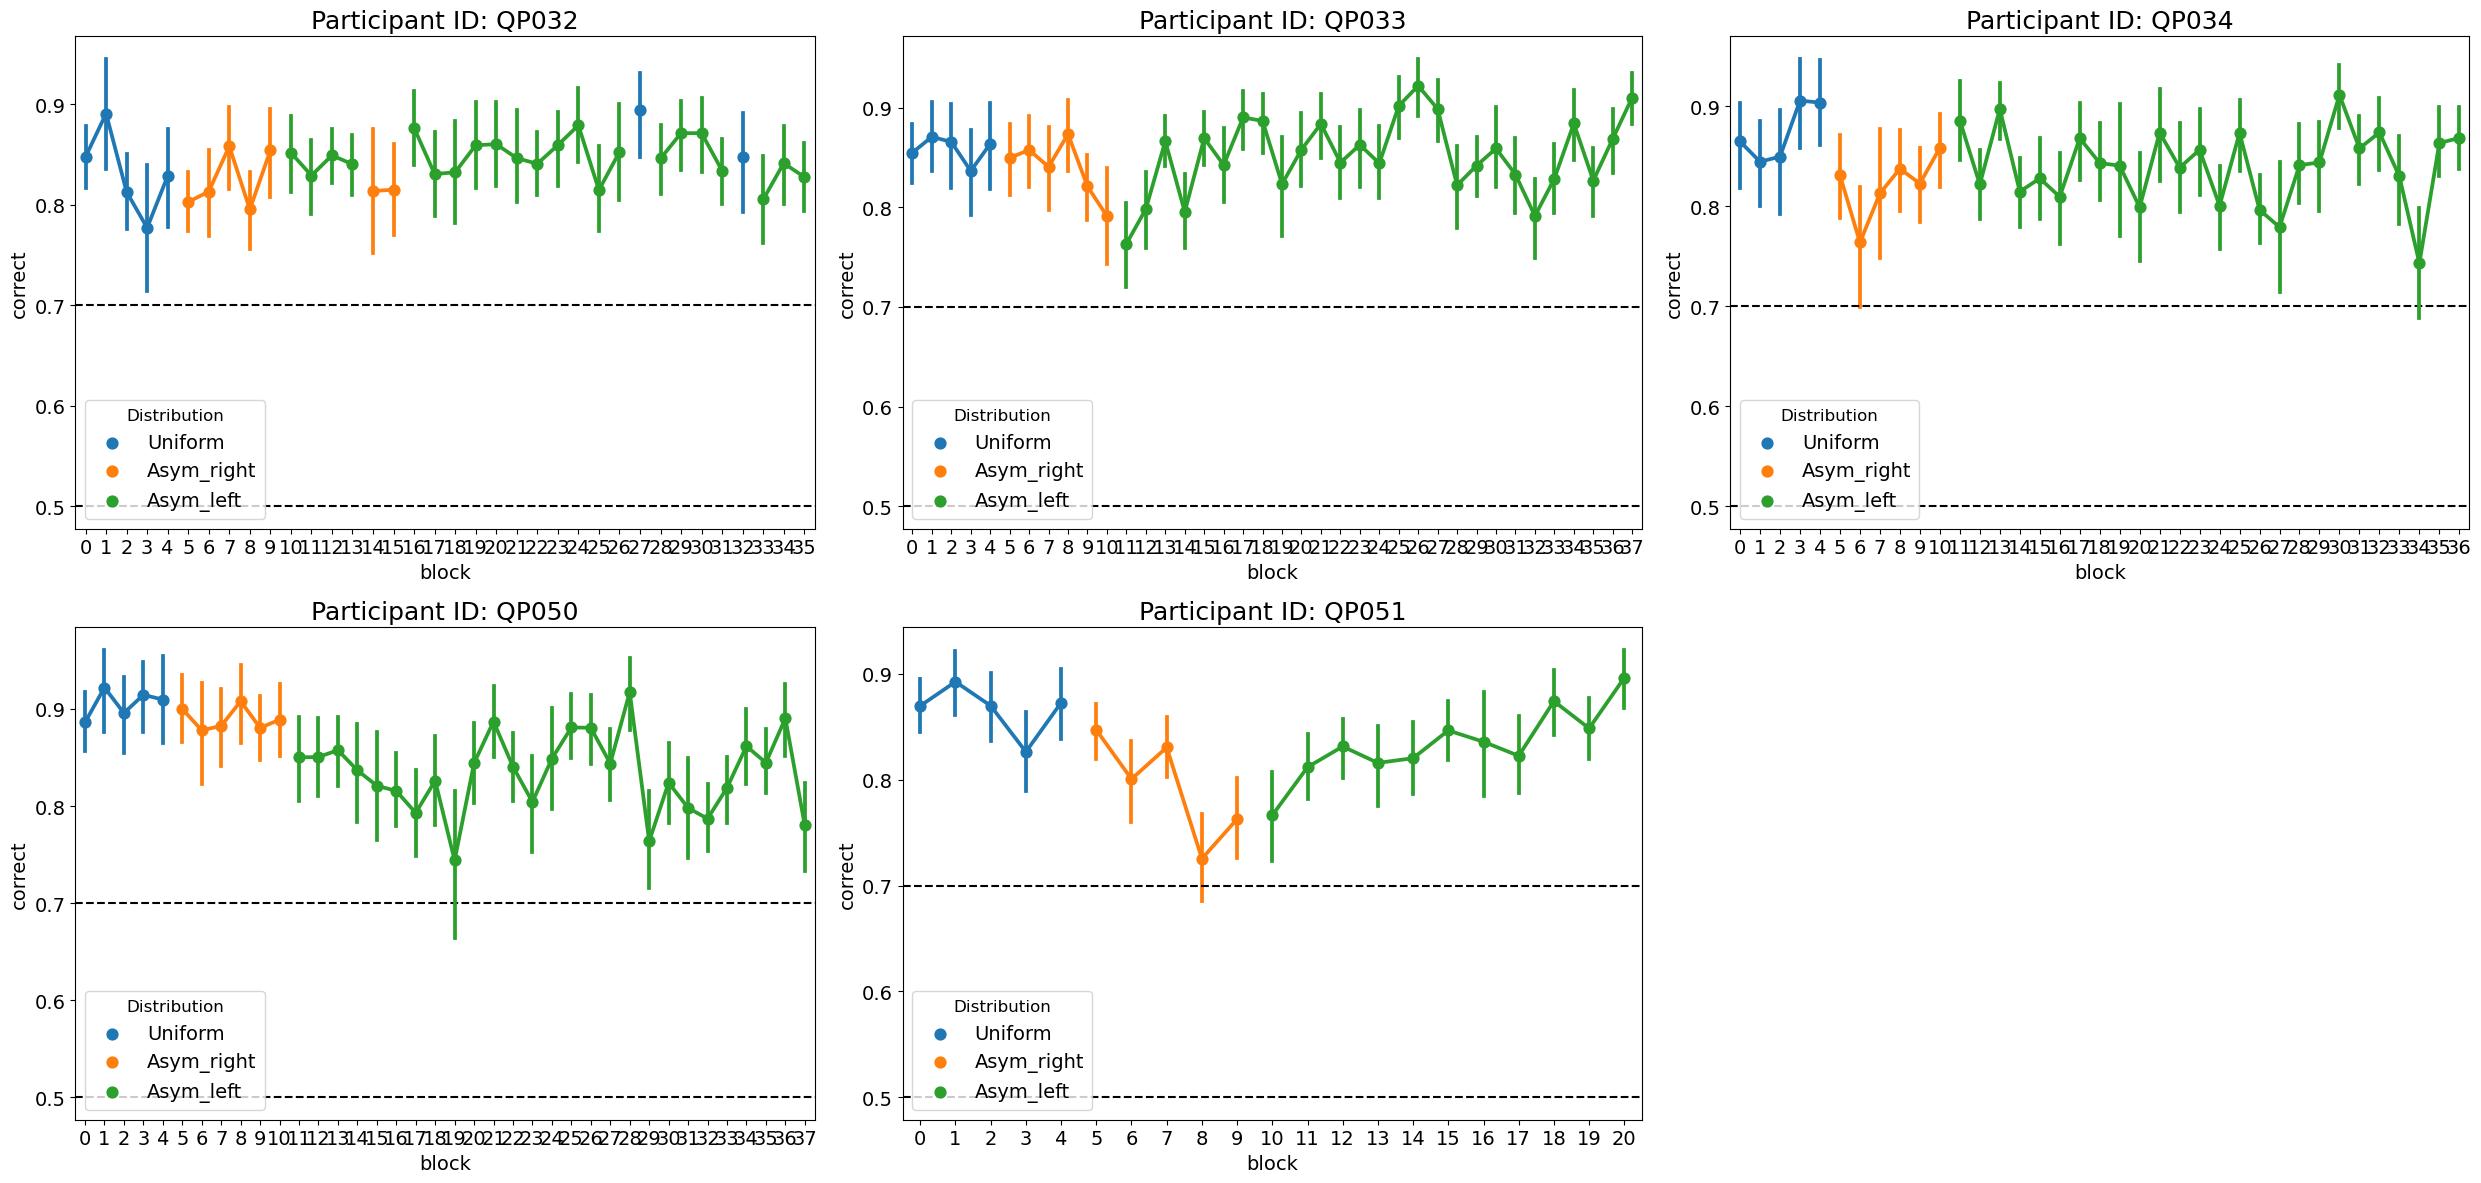

In [144]:
fig=plt.figure(figsize=(25, 12))
num_participants = df.Participant_ID.nunique()
rows = int(np.sqrt(num_participants))
cols = int(np.ceil(num_participants / rows))

# df = filter_min_trials(df,100)
for i, participant_id in enumerate(df.Participant_ID.unique()):
    filtered_df = df[df.Participant_ID == participant_id]
    plt.subplot(rows, cols, i+1)
    sns.pointplot(data = filtered_df, x= 'block', y = 'correct', hue = 'Distribution', ci = 95)
    plt.title(f"Participant ID: {participant_id}")
    plt.xticks(rotation=0)
    plt.axhline(y=0.7, linestyle = '--', color = 'k')
    plt.axhline(y=0.5, linestyle = '--', color = 'k')
plt.tight_layout()
plt.show()

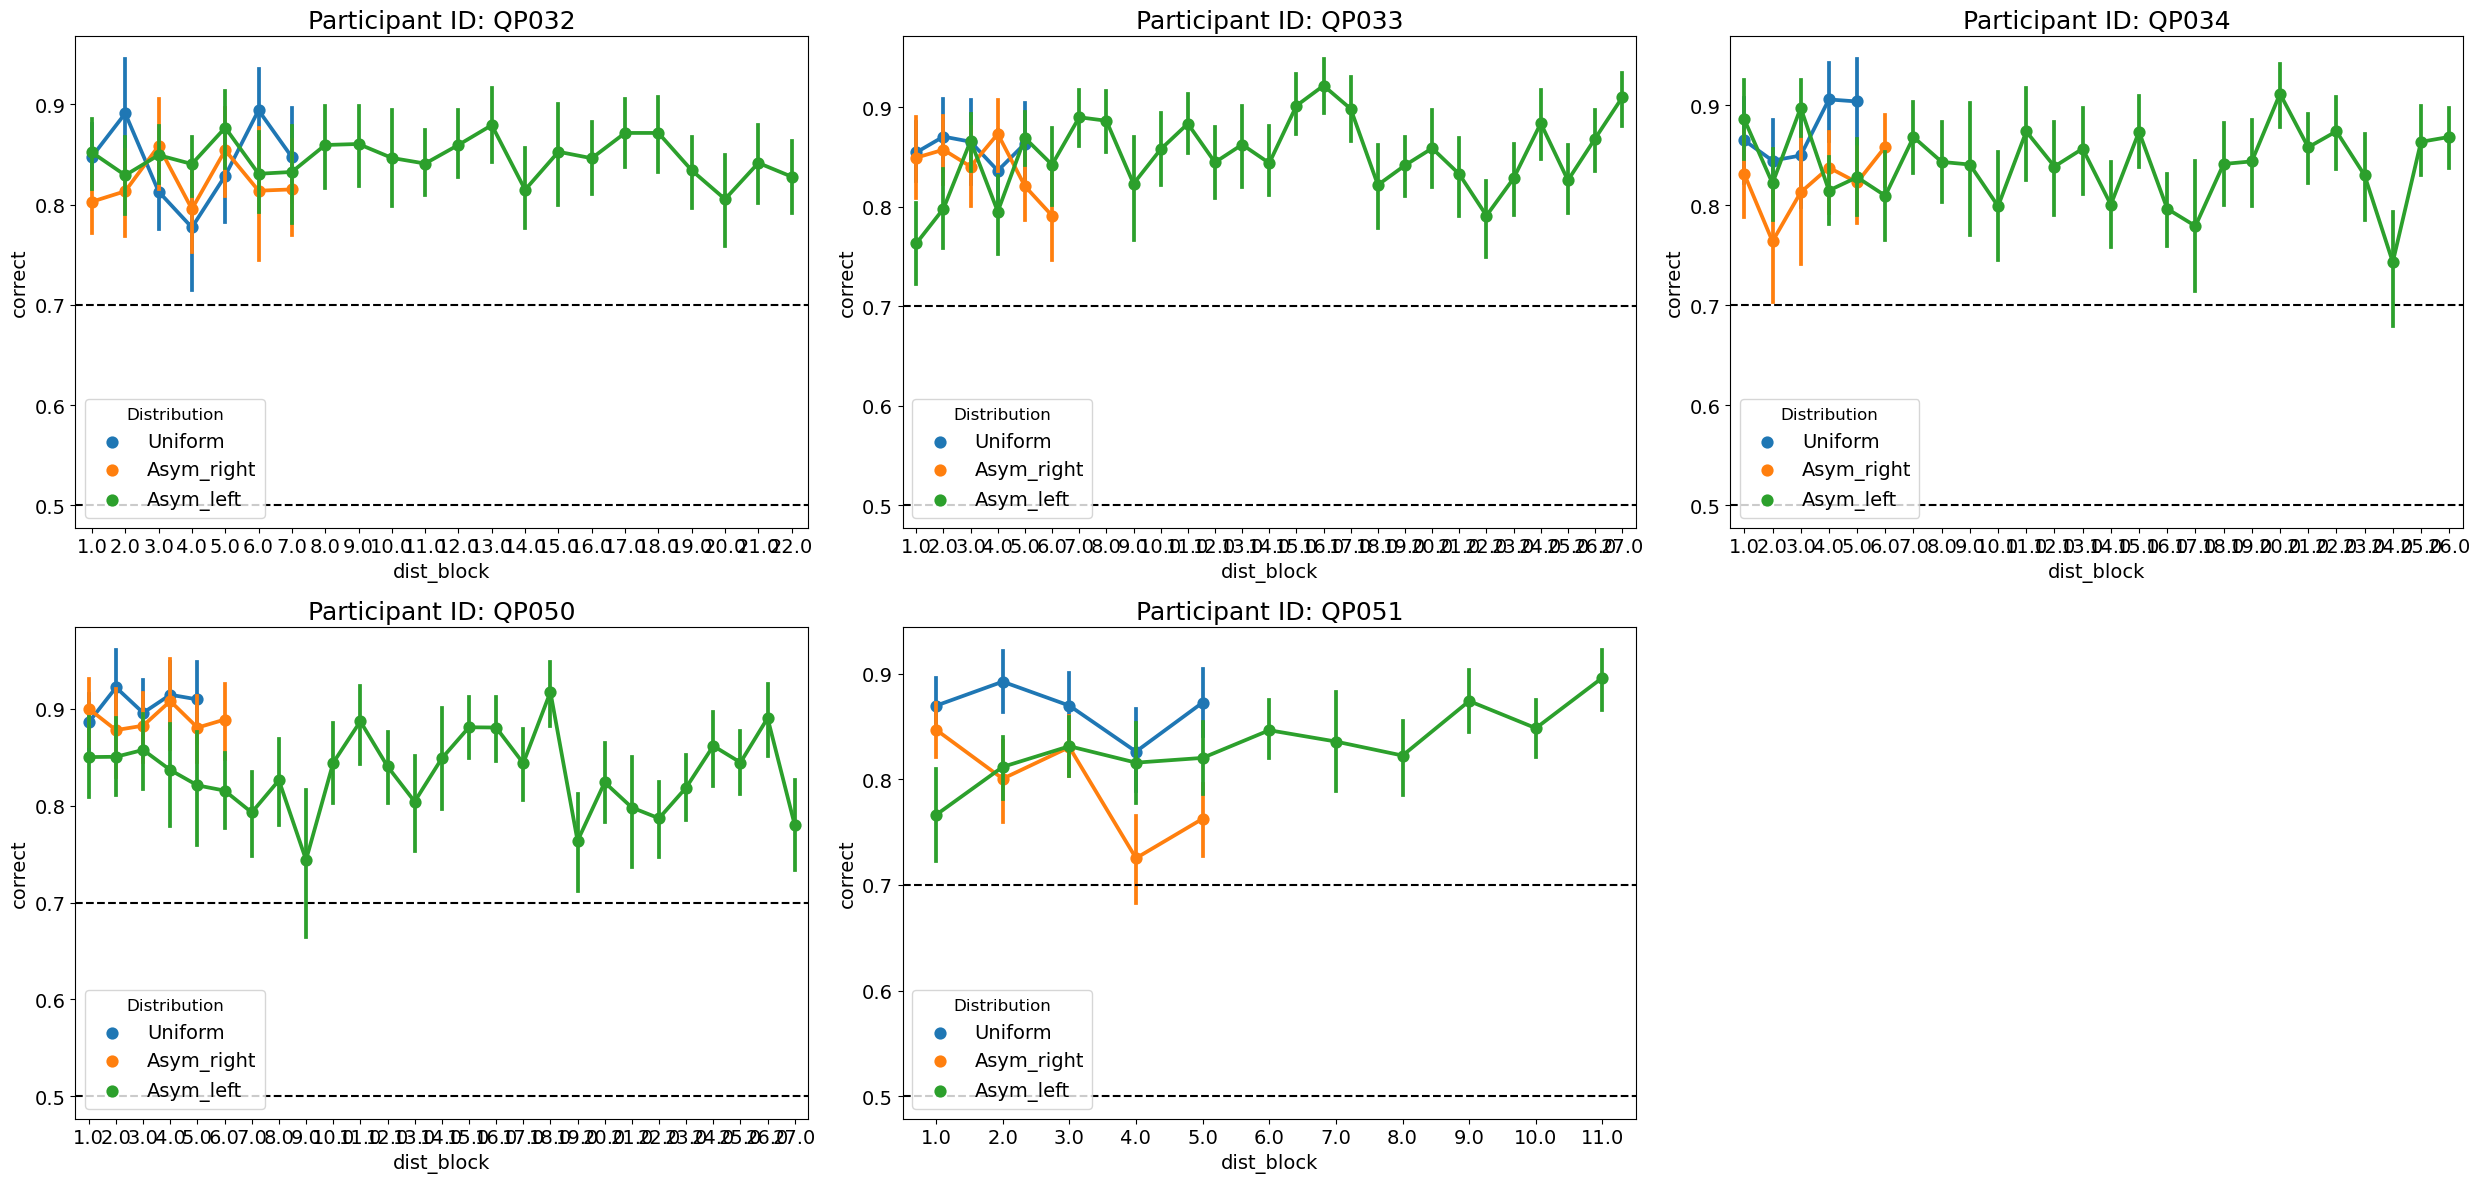

In [101]:
fig=plt.figure(figsize=(25, 12))
num_participants = df.Participant_ID.nunique()
rows = int(np.sqrt(num_participants))
cols = int(np.ceil(num_participants / rows))

# df = filter_min_trials(df,100)
for i, participant_id in enumerate(df.Participant_ID.unique()):
    filtered_df = df[df.Participant_ID == participant_id]
    plt.subplot(rows, cols, i+1)
    sns.pointplot(data = filtered_df, x= 'dist_block', y = 'correct', hue = 'Distribution', ci = 95)
    plt.title(f"Participant ID: {participant_id}")
    plt.xticks(rotation=0)
    plt.axhline(y=0.7, linestyle = '--', color = 'k')
    plt.axhline(y=0.5, linestyle = '--', color = 'k')
plt.tight_layout()
plt.show()

In [353]:
filtered_df = df.groupby(['Participant_ID','Distribution'])['block'].nunique()
filtered_df = filtered_df.reset_index()
filtered_df

Participant_ID Distribution  block
0           QP032    Asym_left      6
1           QP032   Asym_right      7
2           QP032      Uniform      5
3           QP033    Asym_left      8
4           QP033   Asym_right      6
5           QP033      Uniform      5
6           QP034    Asym_left      8
7           QP034   Asym_right      6
8           QP034      Uniform      5
9           QP040      Uniform      3
10          QP050    Asym_left      8
11          QP050   Asym_right      6
12          QP050      Uniform      5
13          QP051    Asym_left      6
14          QP051   Asym_right      5
15          QP051      Uniform      5

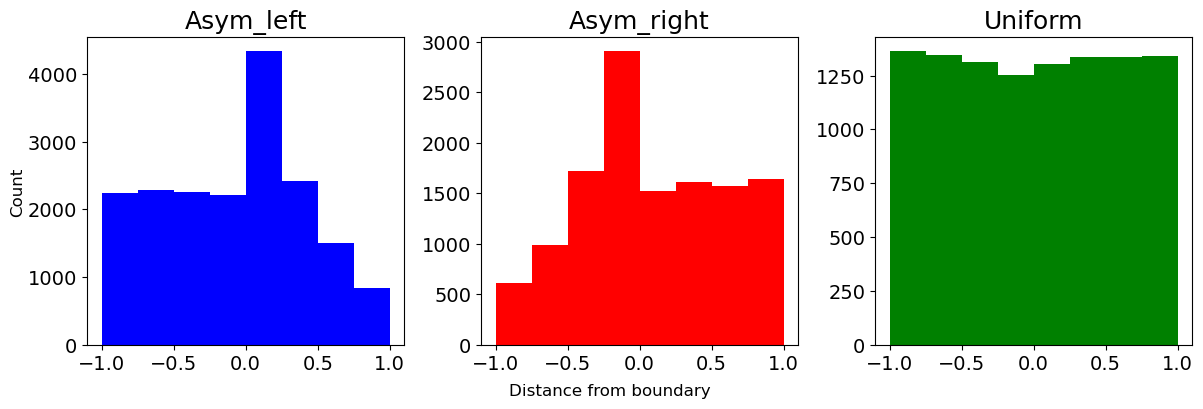

In [327]:
# check distributions are valid

filtered_df = df[df.No_response == False]

# assuming your dataframe is called df
colors = ['blue', 'red', 'green']
# group data by 'Distribution'
grouped = df.groupby('Distribution')

# create a figure and set the size
fig = plt.figure(figsize=(12, 4))

# loop through the groups
for i, (name, group) in enumerate(grouped):
    ax = fig.add_subplot(1, len(grouped), i+1)
    ax.hist(group['stim_relative'], bins=8, color =colors[i])
    ax.set_title(name)
fig.subplots_adjust(bottom=0.2)
fig.text(0.5, 0, 'Distance from boundary', ha='center', va='center')
fig.text(0, 0.5, 'Count', va='center', rotation='vertical')
plt.tight_layout()
plt.show()

# Check pre-SfN discrete dataset

In [392]:
# Import the os and pickle modules
import os
import pickle

N = 33 # search animals 1 through N
Animal_List = generate_animal_list(N)
Protocol = 'SOUND_CAT_DISC'
File_Type = 'Trial_Summary'

# Define a function for loading the data for a single animal
def load_data(animal):
    # Load the data for the current animal
    mouse_data = h_f_b.get_animal_data(
        animal, Protocol, File_Type, data_path
    )
    return mouse_data

# Define the path to the cache file
cache_path = '/Users/quentin/Desktop/HeadFixedBehavior/Data/'
cache_file = os.path.join(cache_path, "all_data_disc.pkl")

# Check if the cache file exists
if os.path.exists(cache_file):
    # If the cache file exists, load the data from the cache
    with open(cache_file, "rb") as f:
        
        all_data_disc = pickle.load(f)
else:
    # If the cache file does not exist, load the data from the remote server
    all_data_disc = pd.DataFrame()
    for animal in Animal_List:
        try:
            # Load the data for the current animal and add it to the dictionary
            mouse_data = load_data(animal)
            all_data_disc = pd.concat([all_data_disc,mouse_data])
        except:
            # If there is an error loading the data, skip the current animal
            pass

    # Save the data to the cache file
    with open(cache_file, "wb") as f:
        pickle.dump(all_data_disc, f)

/Users/quentin/Desktop/HeadFixedBehavior/Analysis/data_handlers.py:47: UserWarning: QP001: all_folders empty
  warnings.warn(f"{Animal_ID}: all_folders empty")
/Users/quentin/Desktop/HeadFixedBehavior/Analysis/data_handlers.py:47: UserWarning: QP002: all_folders empty
  warnings.warn(f"{Animal_ID}: all_folders empty")
/Users/quentin/Desktop/HeadFixedBehavior/Analysis/data_handlers.py:47: UserWarning: QP003: all_folders empty
  warnings.warn(f"{Animal_ID}: all_folders empty")
/Users/quentin/Desktop/HeadFixedBehavior/Analysis/data_handlers.py:47: UserWarning: QP004: all_folders empty
  warnings.warn(f"{Animal_ID}: all_folders empty")
/Users/quentin/Desktop/HeadFixedBehavior/Analysis/data_handlers.py:47: UserWarning: QP005: all_folders empty
  warnings.warn(f"{Animal_ID}: all_folders empty")
/Users/quentin/Desktop/HeadFixedBehavior/Analysis/data_handlers.py:47: UserWarning: QP006: all_folders empty
  warnings.warn(f"{Animal_ID}: all_folders empty")
/Users/quentin/Desktop/HeadFixedBehavior

In [501]:
## Read file if data already fetched

all_data_disc = pd.read_pickle(cache_path +"all_data_disc.pkl")

In [502]:
# Re-label appropriately
df = all_data_disc
df['Octave'] = df.apply(lambda row:  round((np.log(row.Tone/4)) / np.log(2),1), axis=1)
df["Distribution"] = 'Uniform'
df['block'] = df['block'].apply(lambda x: x - 1) # apply 0 indexing to block
df = df.drop(['TrialNumber'], axis=1)
df['TrialNumber'] = df['Trial_Number'].apply(lambda x: x - 1) # apply 0 indexing to TrialNumber
df['stim_relative'] = np.where(np.isnan(df['Octave']), 
                                        np.nan, 
                                        df['Octave'].apply(normalize_oct))
df['choice'] = df['FirstLick'].apply(lambda x: x -1 ) # 0 for left (A), 1 for B (right)
df = df.rename(columns={'Animal_ID': 'Participant_ID',
                        'TrialNumber': 'Trial', 
                        'Correct': 'correct',
                        'AbortTrial': 'No_response'})

# only keep columns used by ELV
df = df[['Date', 'Participant_ID','Distribution','Trial','correct',
         'block','stim_relative','choice',
         'No_response', 'Response_Latency']]

# label correct, choice and response latency as np.nan for no_response trials
df.loc[df["No_response"] == True, "correct"] = np.nan
df.loc[df["No_response"] == True, "choice"] = np.nan
df.loc[df["No_response"] == True, "Response_Latency"] = np.nan

In [503]:
# keep subjects we need before SfN

In [504]:
participant_ids = ['QP033']

# define the start and end dates of the date range
start_date = '2022-10-28'
end_date = '2022-11-01'

# convert the 'Date' column to datetime type
df['Date'] = pd.to_datetime(df['Date'])

# filter the DataFrame based on the participant IDs
df = df[df['Participant_ID'].isin(participant_ids)]

# filter the DataFrame based on the date range
df = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]

In [505]:
# keep at least 100 valid trials per sessions
df = filter_min_trials(df, 100)

## Only keep sessions where %correct is > threshold

threshold = 0.7 
# group the dataframe by 'Participant_ID' and 'block'  
valid_blocks = df.groupby(['Participant_ID','block'])['correct'].mean()
# filter out blocks where average 'correct' is less than threshold and add new block index
valid_blocks = valid_blocks[valid_blocks >= threshold].reset_index()
# re-index blocks
valid_blocks['new_block_index'] = valid_blocks.groupby('Participant_ID').cumcount()
valid_blocks = valid_blocks[['Participant_ID','block','new_block_index']]
filtered_df = df.merge(valid_blocks, on=['Participant_ID','block'])
# remove old block column
filtered_df = filtered_df.drop(columns=['block']) 
# rename new block column
filtered_df = filtered_df.rename(columns={'new_block_index':'block'})
df = filtered_df

In [506]:
all_unif_data_disc = df

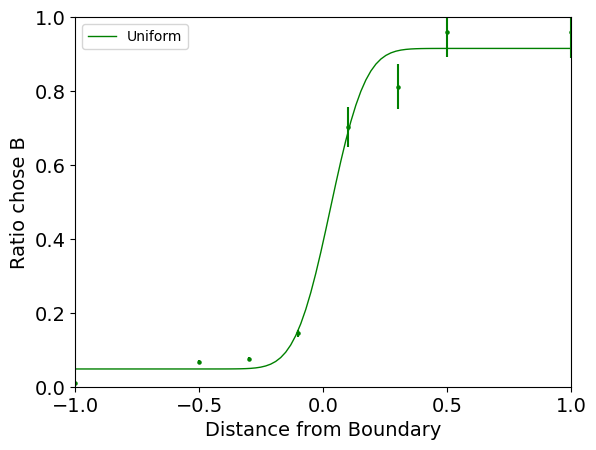

In [507]:
# Special case 

filtered_df = df[df.No_response == False]

color = 'g'
binned_data = filtered_df.groupby('stim_relative')['choice'].mean()
x = binned_data.index
y = binned_data.values
par, mcov = curve_fit(psychometric, x, y, bounds=([-1., 0.01, 0., 0.], [1., 10, .5, .5]))
x = np.linspace(x.min(), x.max(), 100)
y = psychometric(x, *par)
plt.plot(x, y, label='Uniform', color=color, linewidth = 1)
plt.scatter(binned_data.index, binned_data.values, c = color, s = 5)
binned_data = filtered_df.groupby('stim_relative')['choice'].agg(['mean','count'])
binned_data['sem'] = binned_data['mean']/np.sqrt(binned_data['count'])
plt.errorbar(binned_data.index, binned_data['mean'], yerr=binned_data['sem'], 
             fmt='.', markersize=2, ecolor=color, c = color)
plt.ylim(0,1)
plt.xlim(-1,1) 
plt.xticks(np.linspace(-1, 1, 5))
plt.xlabel('Distance from Boundary')
plt.ylabel('Ratio chose B')
# Add a legend
plt.legend(prop={'size': 10})
plt.show()

In [488]:
# Import the os and pickle modules
import os
import pickle

N = 33 # search animals 1 through N
Animal_List = generate_animal_list(N)
Protocol = 'SC_DISC_ASYM_LEFT'
File_Type = 'Trial_Summary'

# Define a function for loading the data for a single animal
def load_data(animal):
    # Load the data for the current animal
    mouse_data = h_f_b.get_animal_data(
        animal, Protocol, File_Type, data_path
    )
    return mouse_data

# Define the path to the cache file
cache_path = '/Users/quentin/Desktop/HeadFixedBehavior/Data/'
cache_file = os.path.join(cache_path, "all_asym_l_data_disc.pkl")

# Check if the cache file exists
if os.path.exists(cache_file):
    # If the cache file exists, load the data from the cache
    with open(cache_file, "rb") as f:
        
        all_asym_l_data_disc = pickle.load(f)
else:
    # If the cache file does not exist, load the data from the remote server
    all_asym_l_data_disc = pd.DataFrame()
    for animal in Animal_List:
        try:
            # Load the data for the current animal and add it to the dictionary
            mouse_data = load_data(animal)
            all_asym_l_data_disc = pd.concat([all_asym_l_data_disc,mouse_data])
        except:
            # If there is an error loading the data, skip the current animal
            pass

    # Save the data to the cache file
    with open(cache_file, "wb") as f:
        pickle.dump(all_asym_l_data_disc, f)

/Users/quentin/Desktop/HeadFixedBehavior/Analysis/data_handlers.py:47: UserWarning: QP001: all_folders empty
  warnings.warn(f"{Animal_ID}: all_folders empty")
/Users/quentin/Desktop/HeadFixedBehavior/Analysis/data_handlers.py:47: UserWarning: QP002: all_folders empty
  warnings.warn(f"{Animal_ID}: all_folders empty")
/Users/quentin/Desktop/HeadFixedBehavior/Analysis/data_handlers.py:47: UserWarning: QP003: all_folders empty
  warnings.warn(f"{Animal_ID}: all_folders empty")
/Users/quentin/Desktop/HeadFixedBehavior/Analysis/data_handlers.py:47: UserWarning: QP004: all_folders empty
  warnings.warn(f"{Animal_ID}: all_folders empty")
/Users/quentin/Desktop/HeadFixedBehavior/Analysis/data_handlers.py:47: UserWarning: QP005: all_folders empty
  warnings.warn(f"{Animal_ID}: all_folders empty")
/Users/quentin/Desktop/HeadFixedBehavior/Analysis/data_handlers.py:47: UserWarning: QP006: all_folders empty
  warnings.warn(f"{Animal_ID}: all_folders empty")
/Users/quentin/Desktop/HeadFixedBehavior

In [508]:
## Read file if data already fetched

all_asym_l_data_disc = pd.read_pickle(cache_path +"all_asym_l_data_disc.pkl")

In [509]:
# Re-label appropriately
df = all_asym_l_data_disc
df['Octave'] = df.apply(lambda row:  round((np.log(row.Tone/4)) / np.log(2),1), axis=1)
df["Distribution"] = 'Asym_left'
df['block'] = df['block'].apply(lambda x: x - 1) # apply 0 indexing to block
df = df.drop(['TrialNumber'], axis=1)
df['TrialNumber'] = df['Trial_Number'].apply(lambda x: x - 1) # apply 0 indexing to TrialNumber
df['stim_relative'] = np.where(np.isnan(df['Octave']), 
                                        np.nan, 
                                        df['Octave'].apply(normalize_oct))
df['choice'] = df['FirstLick'].apply(lambda x: x -1 ) # 0 for left (A), 1 for B (right)
df = df.rename(columns={'Animal_ID': 'Participant_ID',
                        'TrialNumber': 'Trial', 
                        'Correct': 'correct',
                        'AbortTrial': 'No_response'})

# only keep columns used by ELV
df = df[['Date', 'Participant_ID','Distribution','Trial','correct',
         'block','stim_relative','choice',
         'No_response', 'Response_Latency']]

# label correct, choice and response latency as np.nan for no_response trials
df.loc[df["No_response"] == True, "correct"] = np.nan
df.loc[df["No_response"] == True, "choice"] = np.nan
df.loc[df["No_response"] == True, "Response_Latency"] = np.nan

In [510]:
participant_ids = ['QP033']

# define the start and end dates of the date range
start_date = '2022-11-02'
end_date = '2022-11-08'

# convert the 'Date' column to datetime type
df['Date'] = pd.to_datetime(df['Date'])

# filter the DataFrame based on the participant IDs
df = df[df['Participant_ID'].isin(participant_ids)]

# filter the DataFrame based on the date range
df = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]

In [511]:
# keep at least 100 valid trials per sessions
df = filter_min_trials(df, 100)

## Only keep sessions where %correct is > threshold

threshold = 0.7 
# group the dataframe by 'Participant_ID' and 'block'  
valid_blocks = df.groupby(['Participant_ID','block'])['correct'].mean()
# filter out blocks where average 'correct' is less than threshold and add new block index
valid_blocks = valid_blocks[valid_blocks >= threshold].reset_index()
# re-index blocks
valid_blocks['new_block_index'] = valid_blocks.groupby('Participant_ID').cumcount()
valid_blocks = valid_blocks[['Participant_ID','block','new_block_index']]
filtered_df = df.merge(valid_blocks, on=['Participant_ID','block'])
# remove old block column
filtered_df = filtered_df.drop(columns=['block']) 
# rename new block column
filtered_df = filtered_df.rename(columns={'new_block_index':'block'})
df = filtered_df

In [512]:
all_asym_l_data_disc = df

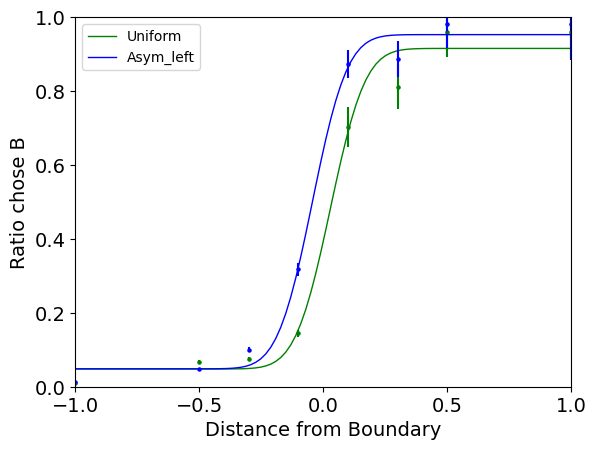

In [520]:
filtered_df = all_unif_data_disc[all_unif_data_disc.No_response == False]
color = 'g'
binned_data = filtered_df.groupby('stim_relative')['choice'].mean()
x = binned_data.index
y = binned_data.values
par, mcov = curve_fit(psychometric, x, y, bounds=([-1., 0.01, 0., 0.], [1., 10, .5, .5]))
x = np.linspace(x.min(), x.max(), 100)
y = psychometric(x, *par)
plt.plot(x, y, label='Uniform', color=color, linewidth = 1)
plt.scatter(binned_data.index, binned_data.values, c = color, s = 5)
binned_data = filtered_df.groupby('stim_relative')['choice'].agg(['mean','count'])
binned_data['sem'] = binned_data['mean']/np.sqrt(binned_data['count'])
plt.errorbar(binned_data.index, binned_data['mean'], yerr=binned_data['sem'], 
             fmt='.', markersize=2, ecolor=color, c = color)

filtered_df = all_asym_l_data_disc[all_asym_l_data_disc.No_response == False]
color = 'b'
binned_data = filtered_df.groupby('stim_relative')['choice'].mean()
x = binned_data.index
y = binned_data.values
par, mcov = curve_fit(psychometric, x, y, bounds=([-1., 0.01, 0., 0.], [1., 10, .5, .5]))
x = np.linspace(x.min(), x.max(), 100)
y = psychometric(x, *par)
plt.plot(x, y, label='Asym_left', color=color, linewidth = 1)
plt.scatter(binned_data.index, binned_data.values, c = color, s = 5)
binned_data = filtered_df.groupby('stim_relative')['choice'].agg(['mean','count'])
binned_data['sem'] = binned_data['mean']/np.sqrt(binned_data['count'])
plt.errorbar(binned_data.index, binned_data['mean'], yerr=binned_data['sem'], 
             fmt='.', markersize=2, ecolor=color, c = color)
plt.ylim(0,1)
plt.xticks(np.linspace(-1, 1, 5))
plt.xlim(-1,1) 
plt.xlabel('Distance from Boundary')
plt.ylabel('Ratio chose B')
# Add a legend
plt.legend(prop={'size': 10})
plt.show()

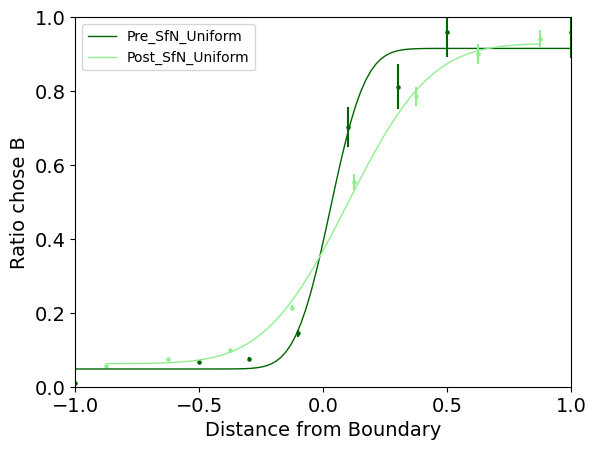

In [538]:
filtered_df = all_unif_data_disc[all_unif_data_disc.No_response == False]
color = 'darkgreen'
binned_data = filtered_df.groupby('stim_relative')['choice'].mean()
x = binned_data.index
y = binned_data.values
par, mcov = curve_fit(psychometric, x, y, bounds=([-1., 0.01, 0., 0.], [1., 10, .5, .5]))
x = np.linspace(x.min(), x.max(), 100)
y = psychometric(x, *par)
plt.plot(x, y, label='Pre_SfN_Uniform', color=color, linewidth = 1)
plt.scatter(binned_data.index, binned_data.values, c = color, s = 5)
binned_data = filtered_df.groupby('stim_relative')['choice'].agg(['mean','count'])
binned_data['sem'] = binned_data['mean']/np.sqrt(binned_data['count'])
plt.errorbar(binned_data.index, binned_data['mean'], yerr=binned_data['sem'], 
             fmt='.', markersize=2, ecolor=color, c = color)

filtered_df = all_data_cont[all_data_cont.No_response == False]
# filtered_df = filtered_df[filtered_df.Participant_ID == 'QP033']
filtered_df = filtered_df[filtered_df.Distribution == 'Uniform']
color = 'lightgreen'
binned_data = filtered_df.groupby('stim_relative_binned')['choice'].mean()
x = binned_data.index
y = binned_data.values
par, mcov = curve_fit(psychometric, x, y, bounds=([-1., 0.01, 0., 0.], [1., 10, .5, .5]))
x = np.linspace(x.min(), x.max(), 100)
y = psychometric(x, *par)
plt.plot(x, y, label='Post_SfN_Uniform', color=color, linewidth = 1)
plt.scatter(binned_data.index, binned_data.values, c = color, s = 5)
binned_data = filtered_df.groupby('stim_relative_binned')['choice'].agg(['mean','count'])
binned_data['sem'] = binned_data['mean']/np.sqrt(binned_data['count'])
plt.errorbar(binned_data.index, binned_data['mean'], yerr=binned_data['sem'], 
             fmt='.', markersize=2, ecolor=color, c = color)

plt.ylim(0,1)
plt.xticks(np.linspace(-1, 1, 5))
plt.xlim(-1,1) 
plt.xlabel('Distance from Boundary')
plt.ylabel('Ratio chose B')
# Add a legend
plt.legend(prop={'size': 10})
# plt.axvline(x = 0)
plt.show()

In [549]:
import itertools
colors = itertools.cycle(['b', 'r', 'g'])

def fit_and_plot(group, color):
    x = group.stim_relative.values
    y = group.choice.values
    par, mcov = curve_fit(psychometric, x, y, bounds=([0, 0.01, 0., 0.], [2, 10, .5, .5]))
    x_continuous = np.linspace(-1,1,100)
    y_continuous = psychometric(x_continuous, *par)
#     plt.scatter(x, y, s=1)
    plt.plot(x_continuous, y_continuous, color, label=group.name)
    plt.axvline(x = 0, c ='gray', linestyle = '--')
    plt.legend(loc='upper left')
    plt.xlabel('stim_relative')
    plt.ylabel('Choice')

df_grouped = df[df.No_response == False].groupby('Distribution')
df_grouped.apply(lambda x: fit_and_plot(x, next(colors)))
plt.show()

In [550]:
from scipy.optimize import curve_fit
colors_map = {'Asym_left': 'b', 'Asym_right': 'r', 'Uniform': 'g'}

def fit_and_plot(group, color, ax):
    x = group.stim_relative.values
    y = group.choice.values
    par, mcov = curve_fit(psychometric, x, y, bounds=([0, 0.01, 0., 0.], [2, 10, .5, .5]))
    x_continuous = np.linspace(-1,1,100)
    y_continuous = psychometric(x_continuous, *par)
    color = colors_map[group.Distribution.iloc[0]]
    ax.plot(x_continuous, y_continuous, color, label=group.Distribution.iloc[0])
    ax.axvline(x = 0, c ='gray', linestyle = '--')
    ax.set_xlabel('stim_relative', size = 10)
    ax.set_ylabel('Choice', size = 10)
#     ax.legend()
    
# fig, axes = plt.subplots(3,3)
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 10), sharex=False, sharey=True)
df_grouped = df[df.No_response == False].groupby('Participant_ID')
i = 0
for name, group in df_grouped:
    ax = axes[i//3, i%3]
    i+=1
    for dist_name, dist_group in group.groupby('Distribution'):
        fit_and_plot(dist_group, next(colors),ax)
    ax.set_title(f"Participant ID: {name}", size = 10)
plt.tight_layout()    
plt.show()


In [551]:
# add column that tracks distribution and mouse specific block_nb

In [578]:
df['block_change'] = df.groupby(['Participant_ID', 'Distribution'])['block'].diff().ne(0).astype(int)
df['dist_block'] = df.groupby(['Participant_ID', 'Distribution'])['block_change'].cumsum()
df.drop('block_change', axis=1, inplace=True)

In [580]:
df = df[df.No_response == False]

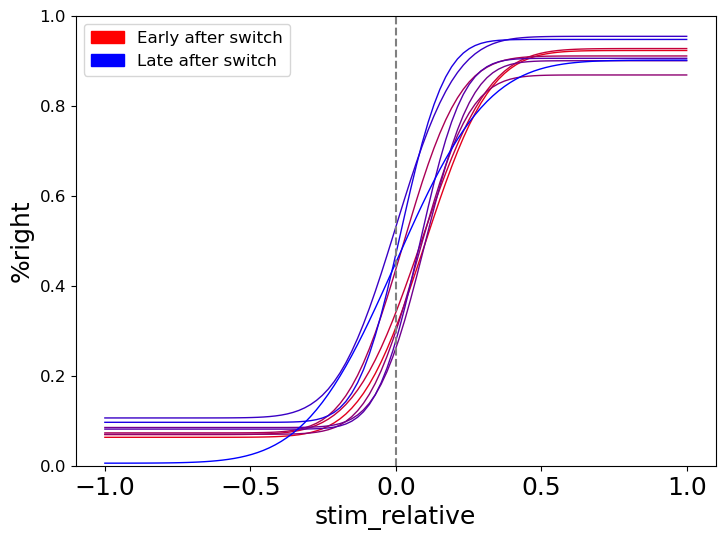

In [756]:
fig = plt.figure(figsize=(8,6))
fig.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.15)
ax = fig.add_subplot(1, 1, 1)

c1='red'
c2='blue'
n = len(df.dist_block.dropna().unique())

# pre-calculate the color for each block
colors = [colorFader(c1,c2,block/9) for block in df.dist_block.dropna().unique()]

# vectorize the psychometric function
psychometric_vec = np.vectorize(psychometric)

# loop over the unique blocks
for block, color in zip(df.dist_block.dropna().unique(), colors):
    df_block = df[df.dist_block == block]
    x = df_block.stim_relative.values
    y = df_block.choice.values
    par, mcov = curve_fit(psychometric, x, y, bounds=([0, 0.01, 0., 0.], [2, 10, .5, .5]))
    x_continuous = np.linspace(-1,1,100)
    y_continuous = psychometric_vec(x_continuous, *par)
    ax.plot(x_continuous, y_continuous,color=color,linewidth = 1)
    ax.set_ylim(0,1)
    ax.set_xlabel('stim_relative')
    ax.set_ylabel('%right')

# Create a patch for the minimum value
min_patch = mpatches.Patch(color=c1, label='Early after switch')
# Create a patch for the maximum value
max_patch = mpatches.Patch(color=c2, label='Late after switch')
# Add the patches to the legend
plt.axvline(x=0, c ='gray', linestyle = '--')
plt.legend(handles=[min_patch, max_patch])


In [569]:
fig = plt.figure(figsize=(8,6))
fig.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.15)
ax = fig.add_subplot(1, 1, 1)

first_block = df.dist_block.dropna().unique()[0]
df_first = df[df.dist_block == first_block]
x_first = df_first.stim_relative.values
y_first = df_first.choice.values
par_first, mcov_first = curve_fit(psychometric, x_first, y_first, bounds=([0, 0.01, 0., 0.], [2, 10, .5, .5]))
x_continuous_first = np.linspace(-1,1,100)
y_continuous_first = psychometric_vec(x_continuous_first, *par_first)
ax.plot(x_continuous_first, y_continuous_first,color=colors[0],linewidth = 1,label = 'First Block After Switch')

last_block = df.dist_block.dropna().unique()[-1]
df_last = df[df.dist_block == last_block]
x_last = df_last.stim_relative.values
y_last = df_last.choice.values
par_last, mcov_last = curve_fit(psychometric, x_last, y_last, bounds=([0, 0.01, 0., 0.], [2, 10, .5, .5]))
x_continuous_last = np.linspace(-1,1,100)
y_continuous_last = psychometric_vec(x_continuous_last, *par_last)
ax.plot(x_continuous_last, y_continuous_last,color=colors[-1],linewidth = 1,label = 'Last Block After Switch')

ax.set_ylim(0,1)
ax.set_xlabel('stim_relative')
ax.set_ylabel('%right')

# Add the patches to the legend
plt.axvline(x=0, c ='gray', linestyle = '--')
plt.legend(handles=[mpatches.Patch(color=colors[0],label = 'First Block'), mpatches.Patch(color=colors[-1],label = 'Last Block')])


In [7]:
df = all_data_cont
# keep data with a min of 100 trials
df = h_f_b.filter_min_trials(df, 100)
# convert tone to octave
df['Octave'] = df.apply(lambda row:  round((np.log(row.Tone/4)) / np.log(2),1), axis=1)
# # remove no-response trials
# all_data = all_data[all_data.AbortTrial == False]
# label columns like ELV
df['block'] = df['block'].apply(lambda x: x - 1) # apply 0 indexing to block
df['TrialNumber'] = df['TrialNumber'].apply(lambda x: x - 1) # apply 0 indexing to TrialNumber
df['Tone'] = df['Tone'].apply(lambda x: x * 1000) # go from kHz to Hz
df['stimulus'] = np.where(np.isnan(df['Tone']), df['WN_Amp'], df['Tone'])
# df['stim_relative'] = df['Octave'].apply(lambda x: x - 1) # yields values between -1 and 1
df['stim_relative'] = df['Octave'].apply(normalize_oct)
df['stim_relative'] = df['WN_Amp'].apply(normalize_amp)

df['choice'] = df['FirstLick'].apply(lambda x: x -1 ) # 0 for left (A), 1 for B (right)
df = df.rename(columns={'Animal_ID': 'Participant_ID',
                                    'TrialNumber': 'Trial', 
                                    'Correct': 'correct',
                                   'AbortTrial': 'No_response'})
# only keep columns used by ELV
df = df[['Participant_ID','Distribution','Trial','correct',
                     'block','stimulus','stim_relative','choice','No_response', 'Response_Latency']]
# label correct, choice and response latency as np.nan for no_response trials
df.loc[df["No_response"] == True, "correct"] = np.nan
df.loc[df["No_response"] == True, "choice"] = np.nan
df.loc[df["No_response"] == True, "Response_Latency"] = np.nan
unif_data = df

/Users/quentin/Desktop/HeadFixedBehavior/Analysis/data_handlers.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['Session'] = df1['Session'].ne(df1['Session'].shift()).cumsum()


In [8]:
# only keep blocks where eperformance is > threshold
threshold = 0.65

df = unif_data[unif_data.No_response == False]
animal_list = []
session_list = []
for mouse in df.Participant_ID.unique():
    df2 = df[df.Participant_ID == mouse]
    df3 = df2.groupby(by=["block"], dropna=True).mean().reset_index()
    df4 = df3[df3.correct>threshold].block.values
    animal_list.append(mouse)
    session_list.append(df4)
final_list = list(zip(animal_list, session_list))
blocks_to_keep = pd.DataFrame(final_list, columns =  ['Participant_ID', 'Blocks'])

df = pd.DataFrame()
for mouse in unif_data.Participant_ID.unique():
    try:
        blocks = blocks_to_keep[blocks_to_keep.Participant_ID == mouse].Blocks.to_list()[0]
        mouse_data = unif_data[unif_data.Participant_ID == mouse]
        mouse_data = mouse_data.loc[mouse_data['block'].isin(blocks)] 
        df = pd.concat([df, mouse_data])
    except:
        pass
data_above_thresh = df
data_above_thresh = data_above_thresh.reset_index(drop = True)
df = data_above_thresh

In [1813]:
# # reset trial index of each session (applies in No_Response trials are rmeoved from dataframe)
# df = pd.DataFrame()

# for mouse in data_above_thresh.Participant_ID.unique():
#     for block in data_above_thresh.block.unique():
#         mouse_block_data = data_above_thresh[(data_above_thresh.Participant_ID == mouse) 
#                                            & (data_above_thresh.block == block)]
#         mouse_block_data['Trial']= np.arange(0,len(mouse_block_data))
#         df = pd.concat([df,mouse_block_data])
# #         print(mouse, block)
# data_above_thresh = df

# Asymmetric Left Data 

In [1814]:
Animal_List = [
    'QP019','QP020','QP032','QP033','QP034','QP035','QP040'
]
Protocol = 'ASYM_LEFT'
File_Type = 'Trial_Summary'
data_path = data_path
all_data = pd.DataFrame()

for animal in Animal_List:
    try:
        mouse_data = h_f_b.get_animal_data(animal, Protocol, File_Type, data_path)
        all_data = pd.concat([all_data,mouse_data])
    except:
        pass
all_asym_l_data = all_data

/Users/quentin/Desktop/HeadFixedBehavior/Analysis/data_handlers.py:48: UserWarning: QP019: all_folders empty
  warnings.warn(f"{Animal_ID}: all_folders empty")
/Users/quentin/Desktop/HeadFixedBehavior/Analysis/data_handlers.py:48: UserWarning: QP020: all_folders empty
  warnings.warn(f"{Animal_ID}: all_folders empty")
/Users/quentin/Desktop/HeadFixedBehavior/Analysis/data_handlers.py:48: UserWarning: QP032: all_folders empty
  warnings.warn(f"{Animal_ID}: all_folders empty")
QP033 progress: 100%|█████████████████████████████| 6/6 [00:15<00:00,  2.53s/it]
/Users/quentin/Desktop/HeadFixedBehavior/Analysis/data_handlers.py:48: UserWarning: QP034: all_folders empty
  warnings.warn(f"{Animal_ID}: all_folders empty")
/Users/quentin/Desktop/HeadFixedBehavior/Analysis/data_handlers.py:48: UserWarning: QP035: all_folders empty
  warnings.warn(f"{Animal_ID}: all_folders empty")
/Users/quentin/Desktop/HeadFixedBehavior/Analysis/data_handlers.py:48: UserWarning: QP040: all_folders empty
  warnings

In [1815]:
df = all_asym_l_data
# keep data with a min of 100 trials
df = h_f_b.filter_min_trials(df, 100)
# convert tone to octave
df['Octave'] = df.apply(lambda row:  round((np.log(row.Tone/4)) / np.log(2),1), axis=1)
# keep data with 8 tones
df = df[df.Nb_Of_Tones ==4]
# # remove no-response trials
# all_data = all_data[all_data.AbortTrial == False]
# label columns like ELV
df['block'] = df['block'].apply(lambda x: x - 1) # apply 0 indexing to block
df['TrialNumber'] = df['TrialNumber'].apply(lambda x: x - 1) # apply 0 indexing to TrialNumber
df['stimulus'] = df['Tone'].apply(lambda x: x * 1000) # go from kHz to Hz
df['stim_relative'] = df['Octave'].apply(lambda x: x - 1) # yields values between -1 and 1
df['choice'] = df['FirstLick'].apply(lambda x: x -1 ) # 0 for left (A), 1 for B (right)
df['Distribution'] = 'Asym_left'
df = df.rename(columns={'Animal_ID': 'Participant_ID',
                                    'TrialNumber': 'Trial', 
                                    'Correct': 'correct',
                                   'AbortTrial': 'No_response'})
# only keep columns used by ELV
df = df[['Participant_ID','Distribution','Trial','correct',
                     'block','stimulus','stim_relative','choice','No_response', 'Response_Latency']]
# label correct, choice and response latency as np.nan for no_response trials
df.loc[df["No_response"] == True, "correct"] = np.nan
df.loc[df["No_response"] == True, "choice"] = np.nan
df.loc[df["No_response"] == True, "Response_Latency"] = np.nan
asym_l_data = df

In [1816]:
# only keep blocks where eperformance is > threshold
threshold = 0.65

df = asym_l_data[asym_l_data.No_response == False]
animal_list = []
session_list = []
for mouse in df.Participant_ID.unique():
    df2 = df[df.Participant_ID == mouse]
    df3 = df2.groupby(by=["block"], dropna=True).mean().reset_index()
    df4 = df3[df3.correct>threshold].block.values
    animal_list.append(mouse)
    session_list.append(df4)
final_list = list(zip(animal_list, session_list))
blocks_to_keep = pd.DataFrame(final_list, columns =  ['Participant_ID', 'Blocks'])

df = pd.DataFrame()
for mouse in asym_l_data.Participant_ID.unique():
    try:
        blocks = blocks_to_keep[blocks_to_keep.Participant_ID == mouse].Blocks.to_list()[0]
        mouse_data = asym_l_data[asym_l_data.Participant_ID == mouse]
        mouse_data = mouse_data.loc[mouse_data['block'].isin(blocks)] 
        df = pd.concat([df, mouse_data])
    except:
        pass
data_above_thresh = df
data_above_thresh = data_above_thresh.reset_index(drop = True)
asym_l_data = data_above_thresh

# Asymmetric Right Data

In [1817]:
Animal_List = [
    'QP019','QP020','QP032','QP033','QP034','QP035','QP040',
]
Protocol = 'ASYM_RIGHT'
File_Type = 'Trial_Summary'
data_path = data_path
all_data = pd.DataFrame()

for animal in Animal_List:
    try:
        mouse_data = h_f_b.get_animal_data(animal, Protocol, File_Type, data_path)
        all_data = pd.concat([all_data,mouse_data])
    except:
        pass
all_asym_r_data = all_data

/Users/quentin/Desktop/HeadFixedBehavior/Analysis/data_handlers.py:48: UserWarning: QP019: all_folders empty
  warnings.warn(f"{Animal_ID}: all_folders empty")
/Users/quentin/Desktop/HeadFixedBehavior/Analysis/data_handlers.py:48: UserWarning: QP020: all_folders empty
  warnings.warn(f"{Animal_ID}: all_folders empty")
/Users/quentin/Desktop/HeadFixedBehavior/Analysis/data_handlers.py:48: UserWarning: QP032: all_folders empty
  warnings.warn(f"{Animal_ID}: all_folders empty")
QP034 progress: 100%|█████████████████████████████| 2/2 [00:05<00:00,  2.88s/it]
/Users/quentin/Desktop/HeadFixedBehavior/Analysis/data_handlers.py:48: UserWarning: QP035: all_folders empty
  warnings.warn(f"{Animal_ID}: all_folders empty")
/Users/quentin/Desktop/HeadFixedBehavior/Analysis/data_handlers.py:48: UserWarning: QP040: all_folders empty
  warnings.warn(f"{Animal_ID}: all_folders empty")


In [1818]:
df = all_asym_r_data
# keep data with a min of 100 trials
df = h_f_b.filter_min_trials(df, 100)
# convert tone to octave
df['Octave'] = df.apply(lambda row:  round((np.log(row.Tone/4)) / np.log(2),1), axis=1)
# keep data with 8 tones
# df = df[df.Nb_Of_Tones ==8]
# # remove no-response trials
# all_data = all_data[all_data.AbortTrial == False]
# label columns like ELV
df['block'] = df['block'].apply(lambda x: x - 1) # apply 0 indexing to block
df['TrialNumber'] = df['TrialNumber'].apply(lambda x: x - 1) # apply 0 indexing to TrialNumber
df['stimulus'] = df['Tone'].apply(lambda x: x * 1000) # go from kHz to Hz
df['stim_relative'] = df['Octave'].apply(lambda x: x - 1) # yields values between -1 and 1
df['choice'] = df['FirstLick'].apply(lambda x: x -1 ) # 0 for left (A), 1 for B (right)
df['Distribution'] = 'Asym_right'
df = df.rename(columns={'Animal_ID': 'Participant_ID',
                                    'TrialNumber': 'Trial', 
                                    'Correct': 'correct',
                                   'AbortTrial': 'No_response'})
# only keep columns used by ELV
df = df[['Participant_ID','Distribution','Trial','correct',
                     'block','stimulus','stim_relative','choice','No_response', 'Response_Latency']]
# label correct, choice and response latency as np.nan for no_response trials
df.loc[df["No_response"] == True, "correct"] = np.nan
df.loc[df["No_response"] == True, "choice"] = np.nan
df.loc[df["No_response"] == True, "Response_Latency"] = np.nan
asym_r_data = df

/Users/quentin/Desktop/HeadFixedBehavior/Analysis/data_handlers.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['Session'] = df1['Session'].ne(df1['Session'].shift()).cumsum()


In [1819]:
# only keep blocks where eperformance is > threshold
threshold = 0.65

df = asym_r_data[asym_r_data.No_response == False]
animal_list = []
session_list = []
for mouse in df.Participant_ID.unique():
    df2 = df[df.Participant_ID == mouse]
    df3 = df2.groupby(by=["block"], dropna=True).mean().reset_index()
    df4 = df3[df3.correct>threshold].block.values
    animal_list.append(mouse)
    session_list.append(df4)
final_list = list(zip(animal_list, session_list))
blocks_to_keep = pd.DataFrame(final_list, columns =  ['Participant_ID', 'Blocks'])

df = pd.DataFrame()
for mouse in asym_r_data.Participant_ID.unique():
    try:
        blocks = blocks_to_keep[blocks_to_keep.Participant_ID == mouse].Blocks.to_list()[0]
        mouse_data = asym_r_data[asym_r_data.Participant_ID == mouse]
        mouse_data = mouse_data.loc[mouse_data['block'].isin(blocks)] 
        df = pd.concat([df, mouse_data])
    except:
        pass
data_above_thresh = df
data_above_thresh = data_above_thresh.reset_index(drop = True)
asym_r_data = data_above_thresh

In [1820]:
Data_Sound_Cat = pd.concat([unif_data,asym_l_data, asym_r_data])
Data_Sound_Cat = Data_Sound_Cat.reset_index(drop = True) # reset index
Data_Sound_Cat.to_csv('Data_Sound_Cat.csv') # save dataframe as .csv

# Raw Data

In [1822]:
Data_Sound_Cat.head()

Participant_ID Distribution  Trial  correct  block  stimulus  stim_relative  \
0          QP019      Uniform      0      0.0      0   11300.0            0.5   
1          QP019      Uniform      1      0.0      0   16000.0            1.0   
2          QP019      Uniform      2      0.0      0    6500.0           -0.3   
3          QP019      Uniform      3      0.0      0    8600.0            0.1   
4          QP019      Uniform      4      NaN      0    9800.0            0.3   

   choice No_response Response_Latency  
0     0.0       False              899  
1     0.0       False             3533  
2     1.0       False             3249  
3     0.0       False             5333  
4     NaN        True              NaN

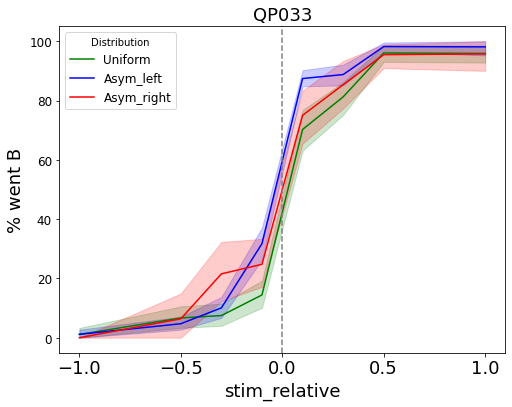

In [1823]:
fig=plt.figure(figsize=(8, 6))
mouse = 'QP033'
df_to_plot = Data_Sound_Cat[Data_Sound_Cat.Participant_ID == mouse]
# df_to_plot = df_to_plot.drop(df_to_plot[(df_to_plot.Participant_ID == 'QP033') 
#                         & (df_to_plot.block < 2)].index)
df_to_plot = df_to_plot[df_to_plot.No_response == False]

sns.lineplot(data = df_to_plot, x= 'stim_relative', y = 'choice', ci=95, hue = 'Distribution', 
              palette = ['g', 
                         'b',
                         'r'
                        ]
            )
# plt.xticks(np.arange(0,len(df_to_plot.stim_relative.unique()),1.75), 
#            np.arange(-1,1.1,0.5))
plt.yticks(np.arange(0,1.2,0.2), np.arange(0,120,20))
plt.ylabel('% went B')
plt.axvline(x = 0, color = 'gray', linestyle = '--')
plt.title(mouse)
plt.show()

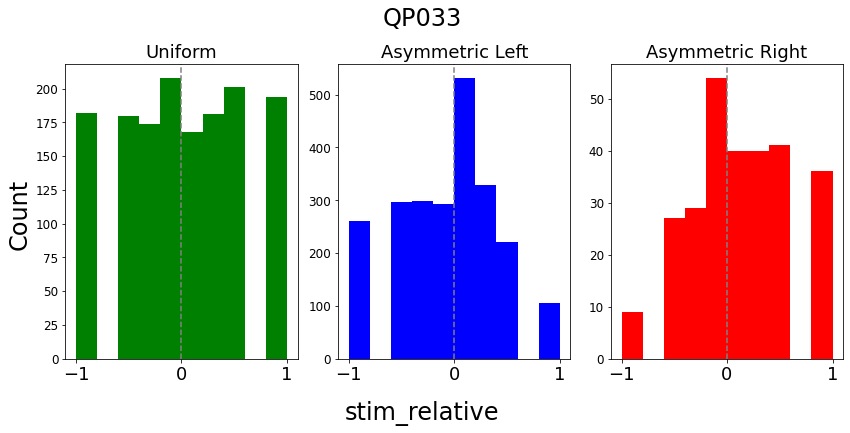

In [1747]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 6), sharex = True, sharey = False)

mouse = 'QP033'
distribution = 'Uniform'
col = 0
df_to_plot = Data_Sound_Cat[Data_Sound_Cat.Participant_ID == mouse]
df_to_plot = df_to_plot[df_to_plot.No_response == False]
df_to_plot = df_to_plot[df_to_plot.Distribution == distribution]
axes[col].hist(df_to_plot.stim_relative, bins = 10, color = 'g')
axes[col].axvline(x = 0, c = 'gray', linestyle = '--')
axes[col].set_title('Uniform')

distribution = 'Asym_left'
col = 1
df_to_plot = Data_Sound_Cat[Data_Sound_Cat.Participant_ID == mouse]
df_to_plot = df_to_plot[df_to_plot.No_response == False]
df_to_plot = df_to_plot[df_to_plot.Distribution == distribution]
axes[col].hist(df_to_plot.stim_relative, bins = 10, color = 'b')
axes[col].axvline(x = 0, c = 'gray', linestyle = '--')
axes[col].set_title('Asymmetric Left')

distribution = 'Asym_right'
col = 2
df_to_plot = Data_Sound_Cat[Data_Sound_Cat.Participant_ID == mouse]
df_to_plot = df_to_plot[df_to_plot.No_response == False]
df_to_plot = df_to_plot[df_to_plot.Distribution == distribution]
df_to_plot = df_to_plot[df_to_plot.block == 3]

axes[col].hist(df_to_plot.stim_relative, bins = 10, color = 'r')
axes[col].axvline(x = 0, c = 'gray', linestyle = '--')
axes[col].set_title('Asymmetric Right')

fig.supxlabel('stim_relative')
fig.supylabel('Count')
fig.suptitle(mouse)

fig.tight_layout()

# Model Fit

mu: 0.0296
sigma: 0.112
lapse_1: 0.0474
lapse_2: 0.0818
mu: 2.92e-19
sigma: 0.105
lapse_1: 0.0829
lapse_2: 0.0244
mu: 0.0316
sigma: 0.0927
lapse_1: 0.106
lapse_2: 0.0929


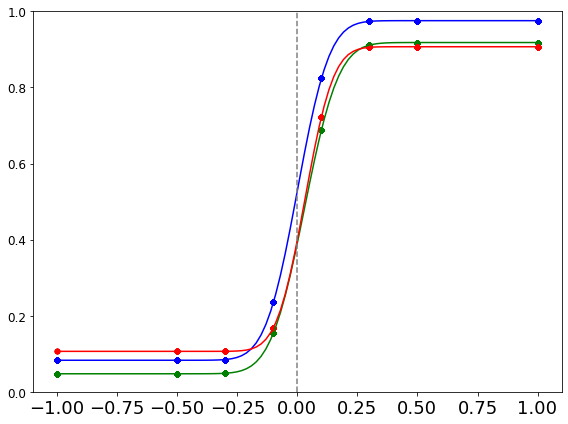

In [1755]:
fig=plt.figure(figsize=(8, 6))

mouse = 'QP033'
distribution = 'Uniform'
df_to_plot = Data_Sound_Cat[Data_Sound_Cat.No_response == False]
df_to_plot = df_to_plot[df_to_plot.Participant_ID == mouse]
df_to_plot = df_to_plot[df_to_plot.Distribution == distribution]
x = df_to_plot.stim_relative.values
y = df_to_plot.choice.values
par, mcov = curve_fit(psychometric, x, y, bounds=([0, 0.01, 0., 0.], [2, 10, .5, .5]))#, par0)
print('mu: ' + f'{par[0]:.3}')
print('sigma: '  + f'{par[1]:.3}')
print('lapse_1: ' + f'{par[2]:.3}')
print('lapse_2: ' + f'{par[3]:.3}')
plt.scatter(x, psychometric(x, *par), s = 20, color = 'g', linestyle = '-')
x_continuous = np.linspace(-1,1,100)
y_continuous = psychometric(x_continuous, *par)
plt.plot(x_continuous, y_continuous, 'g')
# sns.lineplot(x= x, y = psychometric(x, *par), color = 'g', linestyle = '-', ci = 95)
# sns.lineplot(x= x, y = y, color = 'g', ci = 95)

distribution = 'Asym_left'
df_to_plot = Data_Sound_Cat[Data_Sound_Cat.No_response == False]
df_to_plot = df_to_plot[df_to_plot.Participant_ID == mouse]
df_to_plot = df_to_plot[df_to_plot.Distribution == distribution]
x = df_to_plot.stim_relative.values
y = df_to_plot.choice.values
par, mcov = curve_fit(psychometric, x, y, bounds=([0, 0.01, 0., 0.], [2, 10, .5, .5]))#, par0)
print('mu: ' + f'{par[0]:.3}')
print('sigma: '  + f'{par[1]:.3}')
print('lapse_1: ' + f'{par[2]:.3}')
print('lapse_2: ' + f'{par[3]:.3}')
plt.scatter(x, psychometric(x, *par), s = 20, color = 'b', linestyle = '-')
x_continuous = np.linspace(-1,1,100)
y_continuous = psychometric(x_continuous, *par)
plt.plot(x_continuous, y_continuous, 'b')
# sns.lineplot(x= x, y = psychometric(x, *par), color = 'b', linestyle = '--', ci = 95)
# sns.lineplot(x= x, y = y, color = 'b', ci = 95)

distribution = 'Asym_right'
df_to_plot = Data_Sound_Cat[Data_Sound_Cat.No_response == False]
df_to_plot = df_to_plot[df_to_plot.Participant_ID == mouse]
df_to_plot = df_to_plot[df_to_plot.Distribution == distribution]
df_to_plot = df_to_plot[df_to_plot.block >2]
x = df_to_plot.stim_relative.values
y = df_to_plot.choice.values
par, mcov = curve_fit(psychometric, x, y, bounds=([0, 0.01, 0., 0.], [2, 10, .5, .5]))#, par0)
print('mu: ' + f'{par[0]:.3}')
print('sigma: '  + f'{par[1]:.3}')
print('lapse_1: ' + f'{par[2]:.3}')
print('lapse_2: ' + f'{par[3]:.3}')
plt.scatter(x, psychometric(x, *par), s = 20, color = 'r', linestyle = '-')
x_continuous = np.linspace(-1,1,100)
y_continuous = psychometric(x_continuous, *par)
plt.plot(x_continuous, y_continuous, 'r')
# sns.lineplot(x= x, y = psychometric(x, *par), color = 'b', linestyle = '--', ci = 95)
# sns.lineplot(x= x, y = y, color = 'b', ci = 95)

plt.axvline(x = 0, color = 'gray', linestyle = '--')
plt.ylim(0,1)
plt.tight_layout()
plt.show()


In [1763]:
df_to_plot[df_to_plot.block >2]

Participant_ID Distribution  Trial  correct  block  stimulus  \
5695          QP033      Uniform      0      1.0      3    7500.0   
5696          QP033      Uniform      1      1.0      3    7500.0   
5697          QP033      Uniform      2      1.0      3    7500.0   
5698          QP033      Uniform      3      1.0      3    5700.0   
5699          QP033      Uniform      4      1.0      3    6500.0   
...             ...          ...    ...      ...    ...       ...   
6078          QP033      Uniform    383      1.0      3    9800.0   
6081          QP033      Uniform    386      0.0      3    6500.0   
6083          QP033      Uniform    388      1.0      3   16000.0   
6089          QP033      Uniform    394      1.0      3   16000.0   
6116          QP033      Uniform    421      1.0      3   16000.0   

      stim_relative  choice No_response Response_Latency  
5695           -0.1     0.0       False             3833  
5696           -0.1     0.0       False              116  
5697           -0.1     0.0       False             2916  
5698           -0.5     0.0       False              716  
5699           -0.3     0.0       False              333  
...             ...     ...         ...              ...  
6078            0.3     1.0       False              333  
6081           -0.3     1.0       False             3733  
6083            1.0     1.0       False               16  
6089            1.0     1.0       False              583  
6116            1.0     1.0       False              683  

[365 rows x 10 columns]

0.027085993094026015 0.06243212864021768
0.027095086789106125 0.062448755212049824
0.033711736114366675 0.0652591257102361
0.10511471208863647 0.21169970917845227
0.5860351951618845 0.7759733133314498
0.8712187645627211 0.9294890620706731
0.8968521603779042 0.9459917304385801
0.8968536772265676 0.9483971484088444


<ErrorbarContainer object of 3 artists>

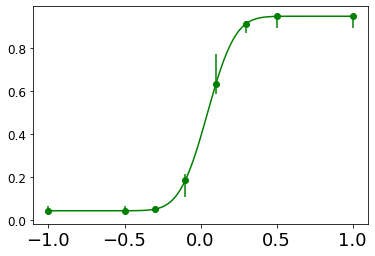

In [1788]:
mouse = 'QP032'
distribution = 'Uniform'
df_to_plot = Data_Sound_Cat[Data_Sound_Cat.No_response == False]
df_to_plot = df_to_plot[df_to_plot.Participant_ID == mouse]
df_to_plot = df_to_plot[df_to_plot.Distribution == distribution]

x = df_to_plot.stim_relative.values
y = df_to_plot.choice.values
par, mcov = curve_fit(psychometric, x, y, bounds=([0, 0.01, 0., 0.], [2, 10, .5, .5]))#, par0)

num_params = 4
num_iters = 500
x_boot, y_boot = bootstrap(x,y, num_iters = num_iters)

model_params = np.zeros((num_iters,num_params))
residuals = np.zeros(num_iters)
boot_estimates = np.zeros((num_iters, len(np.unique(x))))

for row, (x, y) in enumerate(zip(boot_x, boot_y)):
    par, mcov = curve_fit(psychometric, x, y, bounds=([0, 0.01, 0., 0.], [2, 10, .5, .5]))
    residuals[row] = ((y - psychometric(x, *par))**2).mean()
    model_params[row,:] = par  
    for column, boot_x_val in enumerate(np.unique(boot_x)):
        boot_y_val = psychometric(x, *par)[np.where(x == boot_x_val)][0]
        boot_estimates[row,column] = boot_y_val
        
low_bound_array = np.zeros(8)
high_bound_array = np.zeros(8)

for column in np.arange(np.shape(boot_estimates)[1]):
    low_bound = np.percentile(psych_points[:, column], 2.5)
    high_bound = np.percentile(psych_points[:, column], 97.5)
    low_bound_array[column] = low_bound
    high_bound_array[column] = high_bound
    print(low_bound, high_bound)
    
x_continuous = np.linspace(-1,1,100)
y_continuous = psychometric(x_continuous, *par)
plt.plot(x_continuous, y_continuous, color = 'g')
y_errormin = np.unique(psychometric(x, *par)) - low_bound_mat
y_errormax = high_bound_mat - np.unique(psychometric(x, *par))
y_error = [y_errormin, y_errormax]
plt.errorbar(np.unique(x),psychometric(np.unique(x), *par), yerr = y_error,fmt='go')

In [1795]:
mouse = 'QP033'
distribution = 'Uniform'
df_to_plot = Data_Sound_Cat[Data_Sound_Cat.No_response == False]
df_to_plot = df_to_plot[df_to_plot.Participant_ID == mouse]
df_to_plot = df_to_plot[df_to_plot.Distribution == distribution]

x = df_to_plot.stim_relative.values
y = df_to_plot.choice.values
pars, mcovs = curve_fit(psychometric, x, y, bounds=([0, 0.01, 0., 0.], [2, 10, .5, .5]))#, par0)

num_params = 4
num_iters = 500
x_boot, y_boot = bootstrap(x,y, num_iters = num_iters)

model_params = np.zeros((num_iters,num_params))
residuals = np.zeros(num_iters)
boot_estimates = np.zeros((num_iters, len(np.unique(x))))

for row, (x, y) in enumerate(zip(boot_x, boot_y)):
    par, mcov = curve_fit(psychometric, x, y, bounds=([0, 0.01, 0., 0.], [2, 10, .5, .5]))
    residuals[row] = ((y - psychometric(x, *par))**2).mean()
    model_params[row,:] = par  
    for column, boot_x_val in enumerate(np.unique(boot_x)):
        boot_y_val = psychometric(x, *par)[np.where(x == boot_x_val)][0]
        boot_estimates[row,column] = boot_y_val
        
low_bound_array = np.zeros(8)
high_bound_array = np.zeros(8)

for column in np.arange(np.shape(boot_estimates)[1]):
    low_bound = np.percentile(psych_points[:, column], 2.5)
    high_bound = np.percentile(psych_points[:, column], 97.5)
    low_bound_array[column] = low_bound
    high_bound_array[column] = high_bound
    print(low_bound, high_bound)
    
    
x_continuous = np.linspace(-1,1,100)
y_continuous = psychometric(x_continuous, *pars)
plt.plot(x_continuous, y_continuous, color = 'g')
y_errormin = np.unique(psychometric(x, *pars)) - low_bound_array
y_errormax = high_bound_array - np.unique(psychometric(x, *pars))
y_error = [y_errormin, y_errormax]
plt.errorbar(np.unique(x),psychometric(np.unique(x), *pars), yerr = y_error,fmt='go')

0.027085993094026015 0.06243212864021768
0.027095086789106125 0.062448755212049824
0.033711736114366675 0.0652591257102361
0.10511471208863647 0.21169970917845227
0.5860351951618845 0.7759733133314498
0.8712187645627211 0.9294890620706731
0.8968521603779042 0.9459917304385801
0.8968536772265676 0.9483971484088444


<ErrorbarContainer object of 3 artists>

In [1787]:
# need to fix bug above, only seems for work for QP033

Participant_ID Distribution  Trial  correct  block  stimulus  \
3026          QP032      Uniform      0      1.0     10   11300.0   
3028          QP032      Uniform      2      1.0     10    6500.0   
3029          QP032      Uniform      3      1.0     10    7500.0   
3030          QP032      Uniform      4      1.0     10    4000.0   
3031          QP032      Uniform      5      0.0     10    9800.0   
...             ...          ...    ...      ...    ...       ...   
4093          QP032      Uniform    161      1.0     12    4000.0   
4113          QP032      Uniform    181      1.0     12    6500.0   
4117          QP032      Uniform    185      1.0     12    4000.0   
4166          QP032      Uniform    234      0.0     12    8600.0   
4169          QP032      Uniform    237      1.0     12    4000.0   

      stim_relative  choice No_response Response_Latency  
3026            0.5     1.0       False             2499  
3028           -0.3     0.0       False               99  
3029           -0.1     0.0       False             5249  
3030           -1.0     0.0       False              699  
3031            0.3     0.0       False             1233  
...             ...     ...         ...              ...  
4093           -1.0     0.0       False              833  
4113           -0.3     0.0       False             3416  
4117           -1.0     0.0       False               66  
4166            0.1     0.0       False              916  
4169           -1.0     0.0       False              216  

[931 rows x 10 columns]

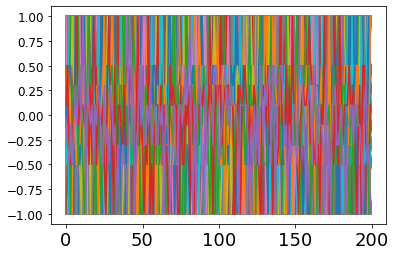

In [1003]:
plt.plot(bootstrap(x.T, psychometric(x, *par).T)[0])
plt.show()

In [1005]:
x_boot, y_boot = bootstrap(x, psychometric(x, *par))

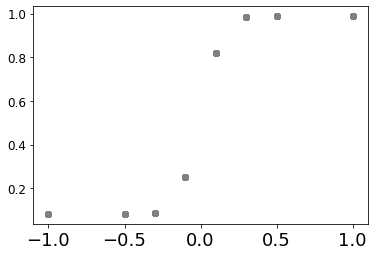

In [1011]:
plt.scatter(x_boot.T, y_boot.T, alpha = 0.1, color = 'gray')
plt.show()

In [1055]:
data = np.array([7, 9, 10, 10, 12, 14, 15, 16, 16, 17, 19, 20, 21, 21, 23])


In [1058]:
sorted_data = np.sort(data)
low_bound = sorted_data[int(np.floor(0.025 * data.shape[0]))]
print(low_bound)

7


(((([7, 9, 10, 10, 12, 14, 15, 16, 16, 17, 19, 20, 21, 21, 23],),),),)

# Update Matrix

In [793]:
Data_Sound_Cat.head()

Participant_ID Distribution  Trial  correct  block  stimulus  stim_relative  \
0          QP019      Uniform      0      0.0      0   11300.0            0.5   
1          QP019      Uniform      1      0.0      0   16000.0            1.0   
2          QP019      Uniform      2      0.0      0    6500.0           -0.3   
3          QP019      Uniform      3      0.0      0    8600.0            0.1   
4          QP019      Uniform      4      NaN      0    9800.0            0.3   

   choice No_response Response_Latency  
0     0.0       False              899  
1     0.0       False             3533  
2     1.0       False             3249  
3     0.0       False             5333  
4     NaN        True              NaN

In [1408]:
mouse = 'QP033'
distribution = 'Uniform'
# df_to_plot = Data_Sound_Cat[Data_Sound_Cat.No_response == False]
df_to_plot = Data_Sound_Cat[Data_Sound_Cat.Participant_ID == mouse]
df_to_plot = df_to_plot[df_to_plot.Distribution == distribution]


prev_stim = np.zeros((len(df_to_plot), 1))
prev_choices = np.zeros((len(df_to_plot), 1))
prev_correct = np.zeros((len(df_to_plot), 1))

for iters in np.arange(len(df_to_plot)):
    if df_to_plot.iloc[iters].Trial == 0: 
        prev_stim[iters,:] = np.nan # no previous choice, stim or correct for every first trial of every session     
        prev_choices[iters,:] = np.nan
        prev_correct[iters,:] = np.nan
    elif df_to_plot.iloc[iters-1].No_response == True:
        prev_stim[iters,:] = df_to_plot.iloc[iters-1].stim_relative   
        prev_choices[iters,:] = np.nan # no previous choice or correct if previous was a no_response trial  
        prev_correct[iters,:] = np.nan
        
    else:
        prev_stim[iters,:] = df_to_plot.iloc[iters-1].stim_relative
        prev_choices[iters,:] = df_to_plot.iloc[iters-1].choice
        prev_correct[iters,:] = df_to_plot.iloc[iters-1].correct 
        
df_to_plot['stim_relative_1'] = prev_stim
df_to_plot['choice_1'] = prev_choices
df_to_plot['correct_1'] = prev_correct

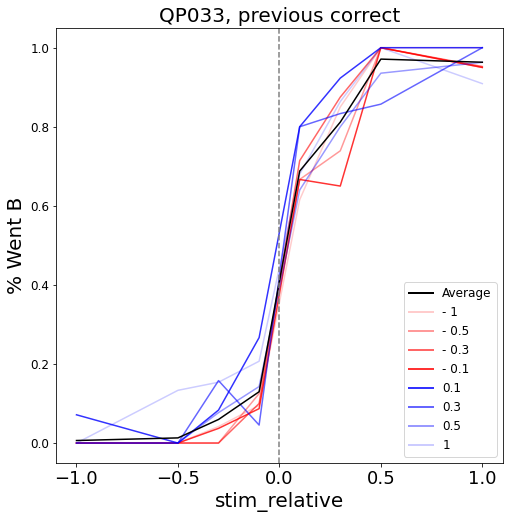

In [1409]:
fig=plt.figure(figsize=(8, 8))

prev_correct = 1

prev_stim = -1
color = 'r'
alpha = 0.2
df = df_to_plot[(df_to_plot.correct_1==prev_correct) & (df_to_plot.stim_relative_1 ==prev_stim)]
x = df.stim_relative.values
y = df.choice.values
sns.lineplot(x= x, y = y, color = color, ci = None, alpha = alpha)

prev_stim = -0.5
color = 'r'
alpha = 0.4
df = df_to_plot[(df_to_plot.correct_1==prev_correct) & (df_to_plot.stim_relative_1 ==prev_stim)]
x = df.stim_relative.values
y = df.choice.values
sns.lineplot(x= x, y = y, color = color, ci = None, alpha = alpha)

prev_stim = -0.3
color = 'r'
alpha = 0.6
df = df_to_plot[(df_to_plot.correct_1==prev_correct) & (round(df_to_plot.stim_relative_1,1) ==prev_stim)]
x = df.stim_relative.values
y = df.choice.values
sns.lineplot(x= x, y = y, color = color, ci = None, alpha = alpha)

prev_stim = -0.1
color = 'r'
alpha = 0.8
df = df_to_plot[(df_to_plot.correct_1==prev_correct) & (round(df_to_plot.stim_relative_1,1) ==prev_stim)]
x = df.stim_relative.values
y = df.choice.values
sns.lineplot(x= x, y = y, color = color, ci = None, alpha = alpha)

prev_stim = 0.1
color = 'b'
alpha = 0.8
df = df_to_plot[(df_to_plot.correct_1==prev_correct) & (round(df_to_plot.stim_relative_1,1) ==prev_stim)]
x = df.stim_relative.values
y = df.choice.values
sns.lineplot(x= x, y = y, color = color, ci = None, alpha = alpha)

prev_stim = 0.3
color = 'b'
alpha = 0.6
df = df_to_plot[(df_to_plot.correct_1==prev_correct) & (round(df_to_plot.stim_relative_1,1) ==prev_stim)]
x = df.stim_relative.values
y = df.choice.values
sns.lineplot(x= x, y = y, color = color, ci = None, alpha = alpha)

prev_stim = 0.5
color = 'b'
alpha = 0.4
df = df_to_plot[(df_to_plot.correct_1==prev_correct) & (round(df_to_plot.stim_relative_1,1) ==prev_stim)]
x = df.stim_relative.values
y = df.choice.values
sns.lineplot(x= x, y = y, color = color, ci = None, alpha = alpha)

prev_stim = 1
color = 'b'
alpha = 0.2
df = df_to_plot[(df_to_plot.correct_1==prev_correct) & (round(df_to_plot.stim_relative_1,1) ==prev_stim)]
x = df.stim_relative.values
y = df.choice.values
sns.lineplot(x= x, y = y, color = color, ci = None, alpha = alpha)

color = 'k'
alpha = 1
df = df_to_plot[df_to_plot.correct_1==prev_correct]
x = df.stim_relative.values
y = df.choice.values
sns.lineplot(x= x, y = y, color = color, ci = None, alpha = alpha)

legend_elements = [Line2D([0], [0], color='k', alpha = 1, lw=2, label='Average'),
                   Line2D([0], [0], color='r', alpha = 0.2, lw=2, label='- 1'),
                   Line2D([0], [0], color='r', alpha = 0.4, lw=2, label='- 0.5'),
                   Line2D([0], [0], color='r', alpha = 0.6, lw=2, label='- 0.3'),
                   Line2D([0], [0], color='r', alpha = 0.8, lw=2, label='- 0.1'),
                   Line2D([0], [0], color='b', alpha = 0.8, lw=2, label='0.1'),
                   Line2D([0], [0], color='b', alpha = 0.6, lw=2, label='0.3'),
                   Line2D([0], [0], color='b', alpha = 0.4, lw=2, label='0.5'),
                   Line2D([0], [0], color='b', alpha = 0.2, lw=2, label='1')]
plt.legend(handles=legend_elements, loc='lower right')

plt.axvline(x=0, c ='gray', linestyle = '--')
# plt.axhline(y=0.5, c ='gray', linestyle = '--')
plt.xlabel('stim_relative', size = 20)
plt.ylabel('% Went B', size = 20)
plt.title(mouse + ', previous correct', size = 20)

plt.ylim(-0.05,1.05)

plt.show()

In [1410]:
num_bins = len(df_to_plot.stim_relative.unique())
update_matrix = np.zeros((num_bins, num_bins))
prev_correct = 1
df1 = df_to_plot[df_to_plot.correct_1==prev_correct]

for column, prev_stim in enumerate(sorted(df1.stim_relative_1.unique())):
#     print(column, prev_stim)
    df2 = df1[df1.stim_relative_1 == prev_stim]
    for row, curr_stim in enumerate(sorted(df1.stim_relative.unique())):
#         print(row, curr_stim)
        df3 = df2[df2.stim_relative == curr_stim]
        df4 = df1[df1.stim_relative == curr_stim]
        val = df3.choice.mean() - df4.choice.mean() # difference between conditional psych at current stim
                                                    # and grand average at current stim
#         print(round(prev_stim,2), round(curr_stim,2), round(val,5))
        update_matrix[row,column] = val 
#         print(df3.choice.mean(), df4.choice.mean(), val)
update_matrix = np.flip(update_matrix, 0) # flip order of rows for plotting purposes

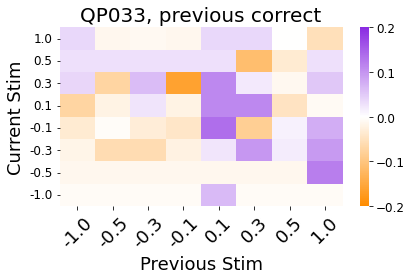

In [1411]:
cvals = [-1, 0, 1]
colors = ['darkorange', 'white', 'blueviolet']
norm2 = plt.Normalize(min(cvals), max(cvals))
tuples = list(zip(map(norm2, cvals), colors))
cmap2 = matplotlib.colors.LinearSegmentedColormap.from_list('', tuples)

g = sns.heatmap(update_matrix,cmap=cmap2, vmin=-0.20, vmax=0.20)
g.set_xticklabels([round(item, 2) for item in sorted(df1.stim_relative.unique())], rotation=45)
g.set_yticklabels([round(item, 2) for item in sorted(df1.stim_relative.unique())][::-1], rotation=0)
plt.title(mouse + ', previous correct', size = 20)
# plt.title(mouse + ', previous correct', size = 20)
plt.xlabel('Previous Stim')
plt.ylabel('Current Stim')

plt.tight_layout()
plt.show()